# 1D limit plots

This notebook plots 1D Brazil limit plots which show the observed and expected xsection limits as a function of $m_s$ for a given $m_{\phi}$, T and decay mode.  
This script firstly makes a 1D limit plot for a specific phase space point. Afterwards, it loops through all parameters $m_{\phi}$, T and decay mode and makes a limit plot for every pair.

In [17]:
# Read in packages

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import numpy as np
import glob

import pandas as pd
import os
import uproot
from scipy import interpolate
from scipy.optimize import curve_fit, fsolve
import yaml
import json

plt.style.use('physics.mplstyle')
np.seterr(divide='ignore', invalid='ignore')

import matplotlib.ticker
import mplhep as hep
hep.style.use("CMS")


In [18]:
# Define auxilary functions 

def get_limits(fn): # Returns quantile vs limits
    f = uproot.open(fn)
    limit = f["limit"]['limit'].array(library="np")
    quant = f["limit"]['quantileExpected'].array(library="np")
    if limit.shape[0] == 1:
        return -1
    else:
        return np.stack([quant,limit]) 
    
def get_SUEP_file(Mass=125, mdark=2, t=1, decay='generic', path="./"): # Returns filename
    if t < 10:
        tem = "{0:.2f}".format(t)
    else:
        tem = "{0:.1f}".format(t)
    tem = str(tem).replace(".","p")
    fname = os.path.join(
        "../higgsCombineGluGluToSUEP_HT1000_T{}_mS{:.3f}_mPhi{:.3f}_T{:.3f}_mode{}_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root".format(tem, Mass, mdark, t, decay)
    )
    if os.path.isfile(fname):
        return fname
    else:
        pass
     
def xs_scale(proc):
    xsec = 1.0
    with open(f"../config/xsections_{era}.json") as file:
            MC_xsecs = json.load(file)
    xsec  = MC_xsecs[proc]["xsec"] # Shouldn't I also multiply by this one --> will become evident!
    #xsec *= MC_xsecs[proc]["kr"]
    xsec *= MC_xsecs[proc]["br"]
    #xsec *= 1000.0
    assert xsec > 0, "{} has a null cross section!".format(proc)
    return xsec

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log(xx)
    logy = np.log(yy)
    lin_interp = interpolate.interp1d(logx, logy, bounds_error=False, fill_value="extrapolate", kind=kind)
    log_interp = lambda zz: np.power(np.e, lin_interp(np.log(zz)))
    return log_interp




In [19]:
# Take temperature, mphi/mdark, decay mode (in GeV) 
T = 4
mdark = 2
decay = 'generic'
outdir = '/home/submit/pvanstee/public_html/SUEP/1D_plots_2016-17-18_combined'
era = 2018

decays = {
    'hadronic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=15,15,70%",
    'leptonic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=40,40,20%",
    'generic' : r"$A^' \rightarrow \pi^{+}\pi^{-}$""\n""with BR=100%"
}

# List of tuples with all phase space points (mdark,T) 
mdarks = np.array([1,1.4,2,3,4,8]) #1.4 GeV only works for hadronic
ratios = np.array([1/4,1/2,1,2,4])
tuples = []

for m in mdarks:
    for r in ratios:
        tuples.append((m,m*r))
        


In [20]:
# Get all SUEP masses for a given mdark and T

def get_params(mdark=mdark,T=T,decay=decay):

    # Get files
    combine_files = glob.glob("../higgs*.root")

    # Filter out the parameters
    all_params = []
    for file in combine_files:
        file_trim = file.split("HT1000_")[1]
        proc = 'GluGluToSUEP_HT1000_' + file_trim.split('.Asymptotic')[0]
        xsec = xs_scale(proc)
        t = float(file_trim.split("_")[0].replace("p",".")[1:])
        Mass = float(file_trim.split("_")[1][2:])
        mphi = float(file_trim.split("_")[2][4:])
        mode = file_trim.split('_')[4][4:]
        all_params.append([t,Mass,mphi,xsec,mode])

    # Take params corresponding to mphi and Temperature
    params = []
    for pair in all_params:
        if pair[0] != T: continue
        if pair[2] != mdark: continue
        if pair[4] != decay: continue
        params.append([pair[1],pair[3]])

    # check if combine produced the 5 expected limits
    skip_bad = []

    for pair in params:
        try:
            limit = get_limits(get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay=decay))
            if limit.shape == (2,6):
                skip_bad.append(pair)
            else:
                print('Missing limits; ', get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay=decay))
        except:
            print('No limits; ', get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay=decay))

    return skip_bad


params = get_params()
print('params', params)

params [[200.0, 16.9], [300.0, 6.59], [600.0, 1.0], [800.0, 0.402], [700.0, 0.621], [900.0, 0.269], [1000.0, 0.185], [125.0, 45.2], [400.0, 3.16], [500.0, 1.71]]


[6.11842076e+02 1.06145337e+01 1.01885283e-02 1.18855884e-03
 2.69605472e-03 7.07455557e-04 5.09728179e-04 1.28546977e+04
 3.95421549e-01 4.37803847e-02]
[3.91868750e+02 8.28898438e+00 8.85009766e-03 1.15933228e-03
 2.56791687e-03 6.99836731e-04 5.05294800e-04 1.01474000e+04
 3.24023438e-01 3.60076904e-02]


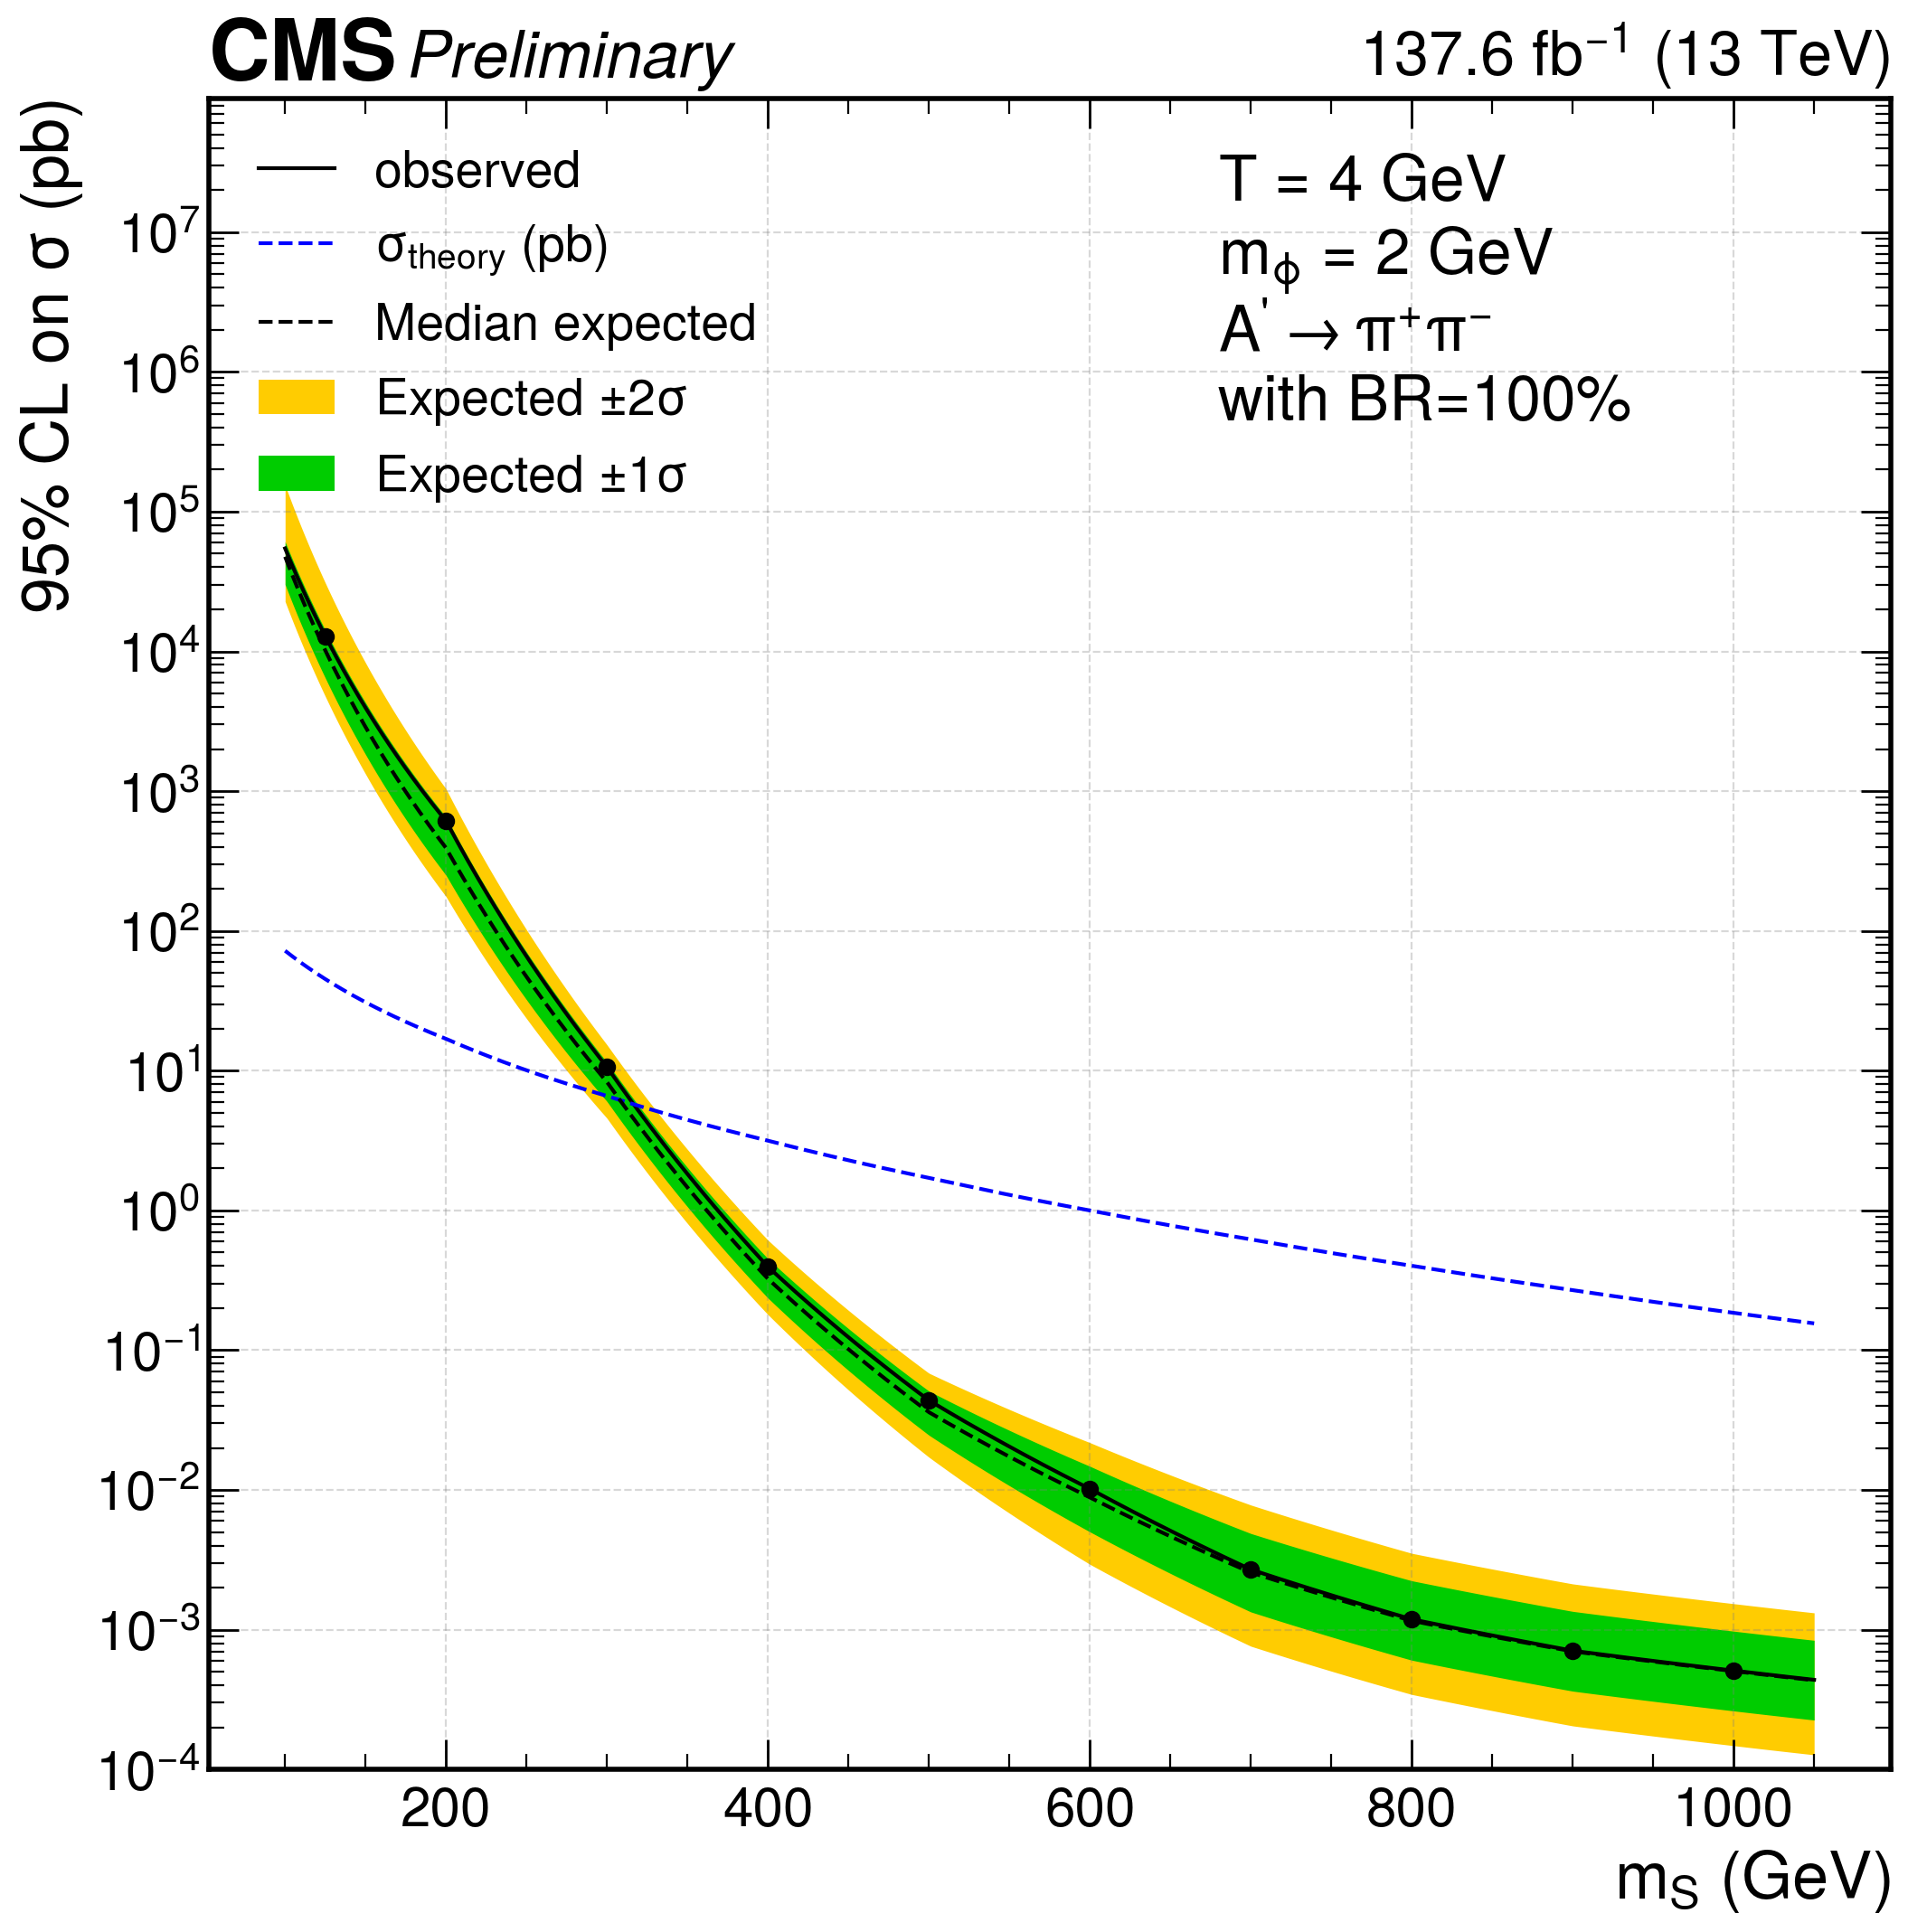

In [21]:
# Make brazil plot for all masses

def plot_dim_interpolate(params):
    
    # Get data
    limits = []
    xsec = []
    masses = []

    for pair in params:
        if pair[0] not in masses: 
            masses.append(pair[0])
            xsec.append(pair[1])
        lims = get_limits(get_SUEP_file(Mass=pair[0], mdark=mdark, t=T, decay=decay))
        lims = lims * pair[1]
        limits.append(lims)
        

    _exp = np.array([l[1][2] for l in limits])
    _s1p = np.array([l[1][1] for l in limits]) 
    _s1m = np.array([l[1][3] for l in limits]) 
    _s2p = np.array([l[1][0] for l in limits]) 
    _s2m = np.array([l[1][4] for l in limits]) 
    _obs = np.array([l[1][5] for l in limits])    
    
    
    # Define interpolation
    exp_limit = log_interp1d(masses, _exp) 
    s1p_limit = log_interp1d(masses, _s1p)
    s1m_limit = log_interp1d(masses, _s1m)
    s2p_limit = log_interp1d(masses, _s2p)
    s2m_limit = log_interp1d(masses, _s2m)
    obs_limit = log_interp1d(masses, _obs)
    th_limit =  log_interp1d(masses, xsec)
    
    
    # Make 1D limit plot
    plt.figure(figsize=(12,12))
    ax = plt.gca()
        
    xvar = np.linspace(100,1050,1000)

    # Plot observed limits
    plt.plot(masses, _obs,'.', ms=12, color='black') 
    plt.plot(xvar,obs_limit(xvar), #*.101,#* 0.101* 2/3,
             "-", ms=12, color='black', label="observed")
    
    #Plot expected limits including brazil bands
    plt.plot(xvar,th_limit(xvar), #*.101,#* 0.101* 2/3,
         "--", ms=12, color='blue', label="$\sigma_{theory}$ (pb)")
    plt.plot(xvar, exp_limit(xvar), ls="--", ms=12, color='black', label="Median expected")
    plt.fill_between(xvar, s2m_limit(xvar), s2p_limit(xvar), color="#FFCC01", lw=0, label="Expected $\pm 2\sigma$")
    plt.fill_between(xvar, s1m_limit(xvar), s1p_limit(xvar), color="#00CC00", lw=0, label="Expected $\pm 1\sigma$")
    
    # Just to make everything look nice
    plt.ylabel(r"95% CL on $\sigma$ (pb)")
    plt.xlabel(r"$m_{S}$ (GeV)") 
    plt.legend(loc="upper left", fontsize=20)

    info = plt.text(
        0.6, 0.8, r"$T$ = {} GeV""\n""$m_{{\phi}}$ = {} GeV""\n""{}".format(T,mdark,decays[decay]),
        fontsize=25, horizontalalignment='left', 
        verticalalignment='bottom', 
        transform=ax.transAxes,
    )
    
    print(_obs)
    print(_exp)
    
    
    hep.cms.label(llabel='Preliminary', data=False, lumi='137.6', ax=ax) # To add CMS lumi scripts

    plt.grid(visible=True, which='major', color='grey', linestyle='--', alpha=0.3)
    plt.ylim(1e-4,9e7)
    plt.yscale("log")
    
    y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 20)
    ax.yaxis.set_major_locator(y_major)
    y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 100)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/closure_uncertainties/NEW_FC_estimation_1D_limits_T{}_mphi{}_{}.png".format(T,mdark,decay))
    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/closure_uncertainties/NEW_FC_estimation_1D_limits_T{}_mphi{}_{}.pdf".format(T,mdark,decay))

    plt.show()
    
plot_dim_interpolate(params)



2.0 0.5 generic
[0.00082523 0.00146248 0.00325723 0.00212525 0.00099147 0.00672085
 0.00090772 0.00112374 0.16600209 0.0008435 ]
[0.00082428 0.00147423 0.00326805 0.00212158 0.00099021 0.00670471
 0.00090784 0.00112152 0.13931885 0.00084145]


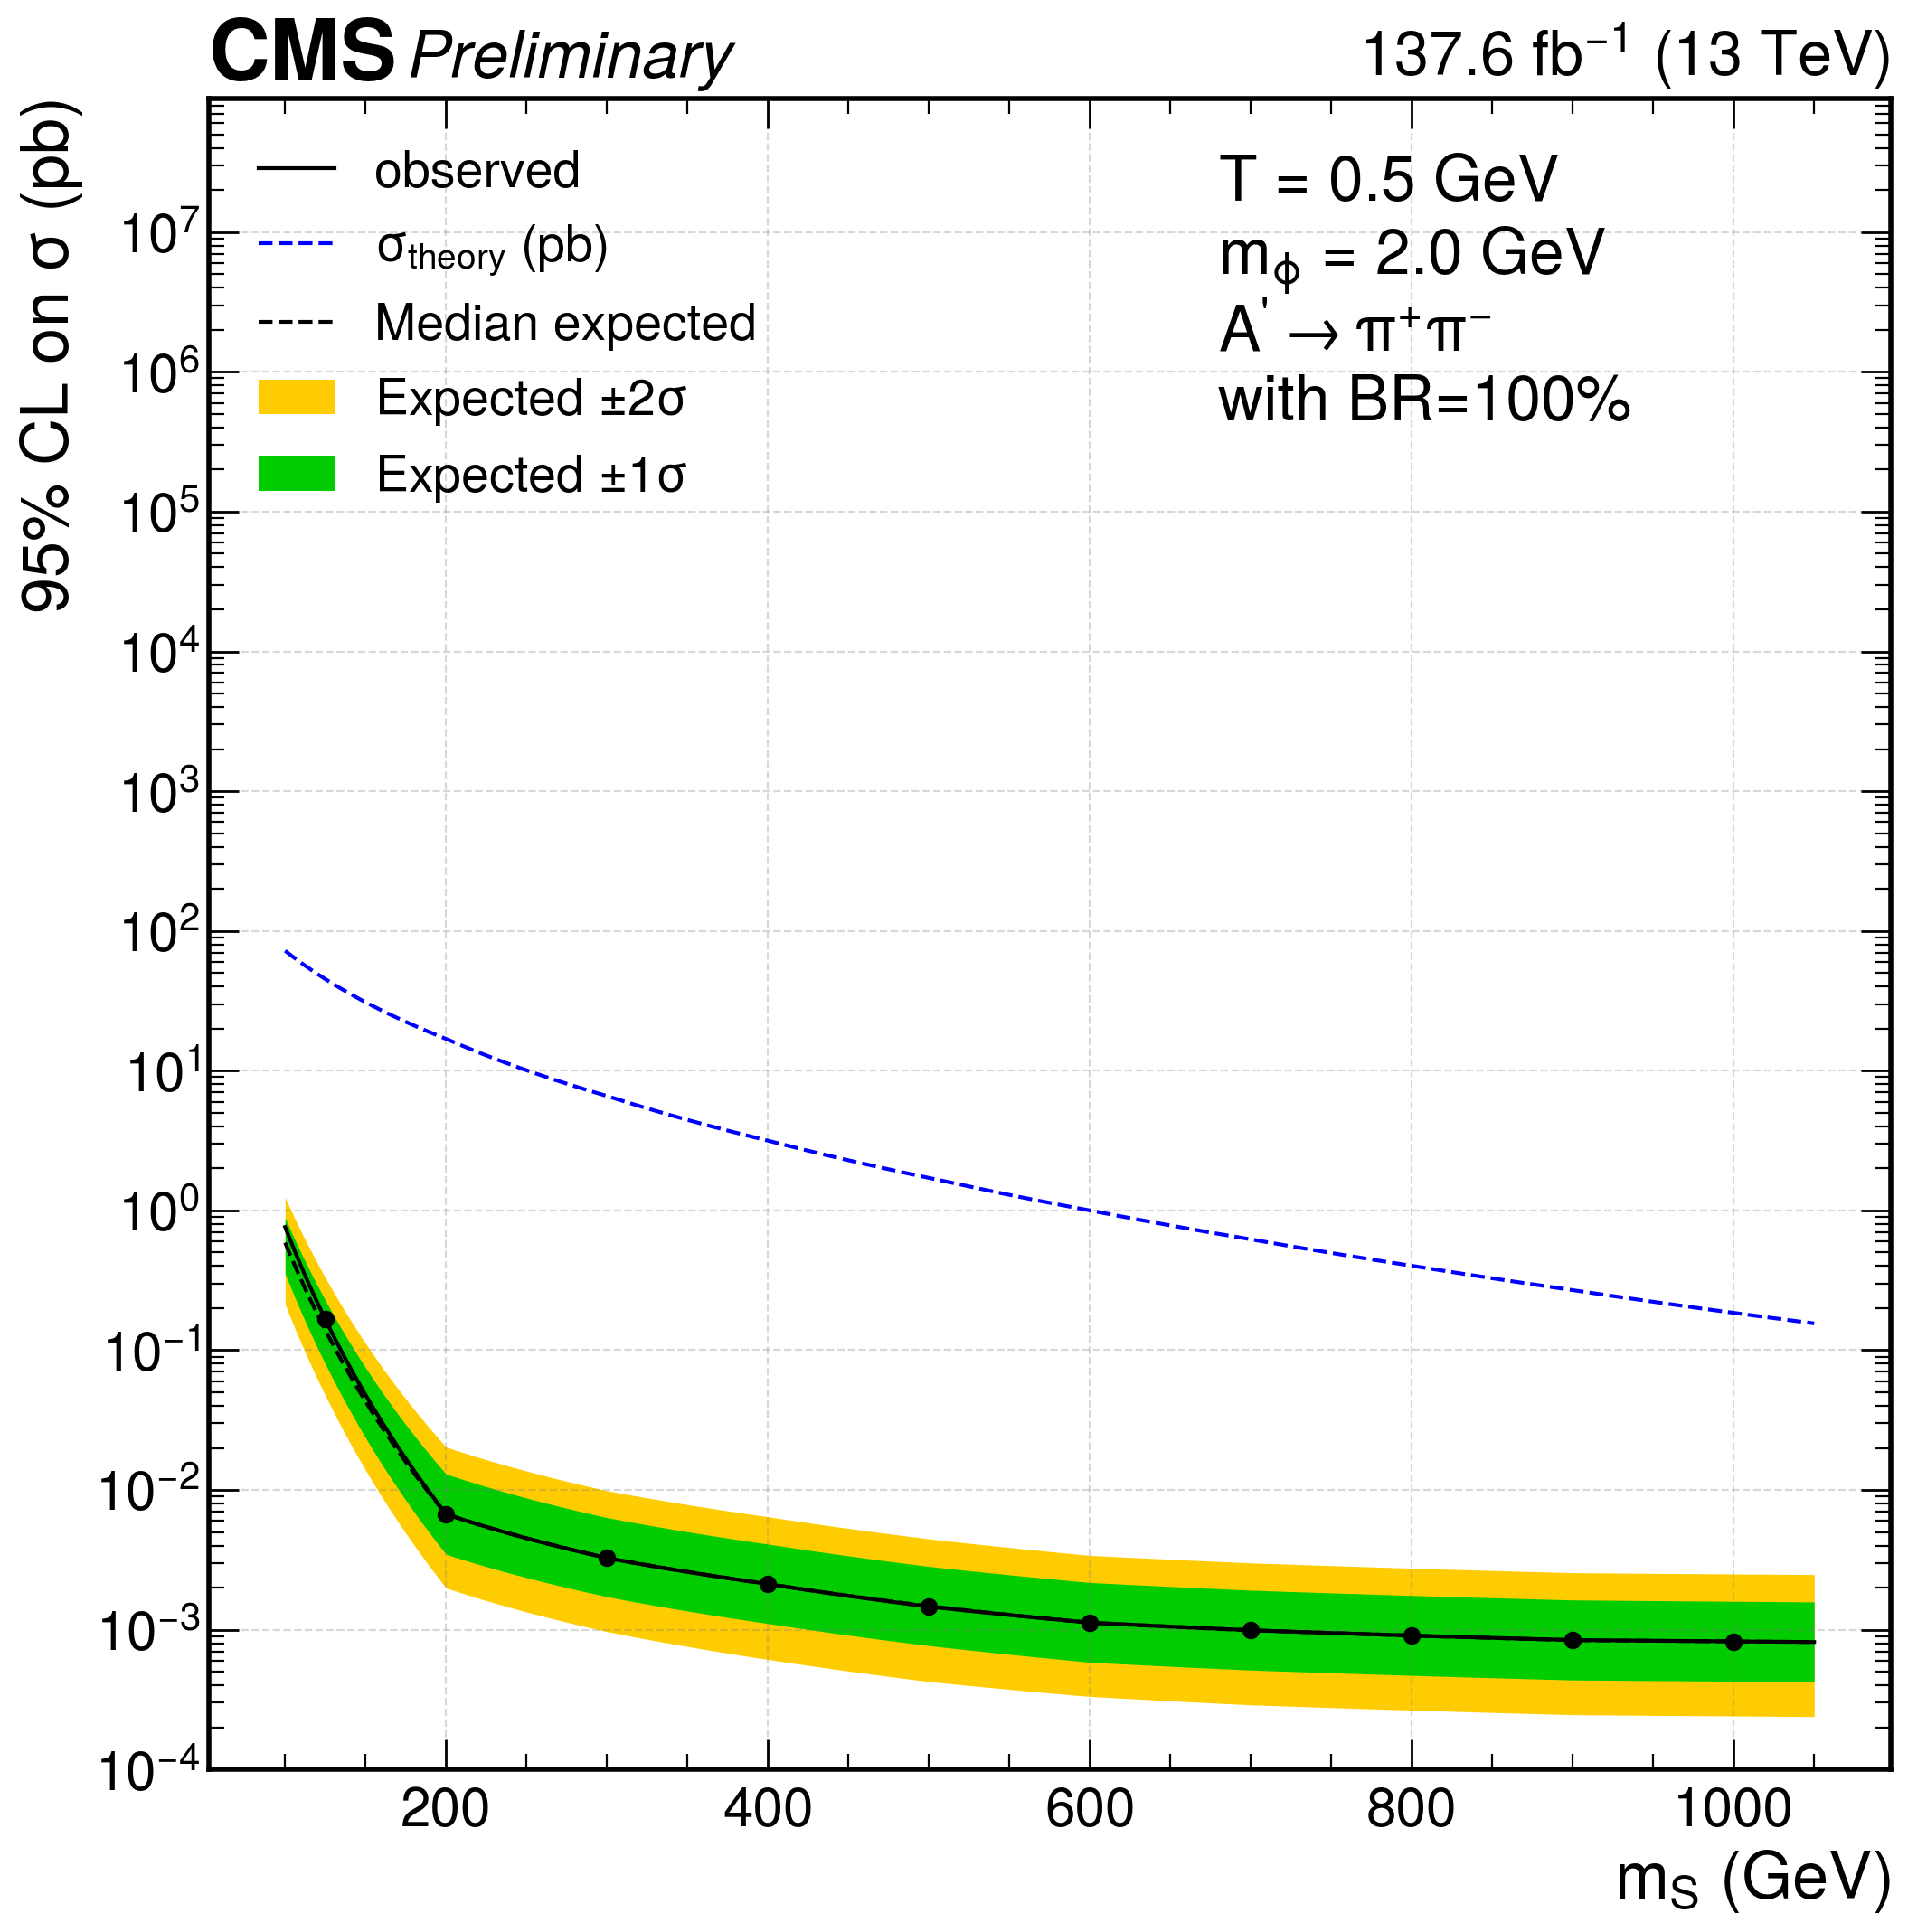

2.0 1.0 generic
[2.09871576e-02 5.18375995e-04 7.39620540e-04 1.83811219e-03
 6.04958589e-04 3.15136727e+00 5.51828396e-04 9.17829461e-04
 1.25056044e-03 3.14420746e-03]
[2.01141357e-02 5.19409180e-04 7.39105225e-04 1.85638428e-03
 6.04202271e-04 2.72568359e+00 5.50018311e-04 9.15527344e-04
 1.23939514e-03 3.16749573e-03]


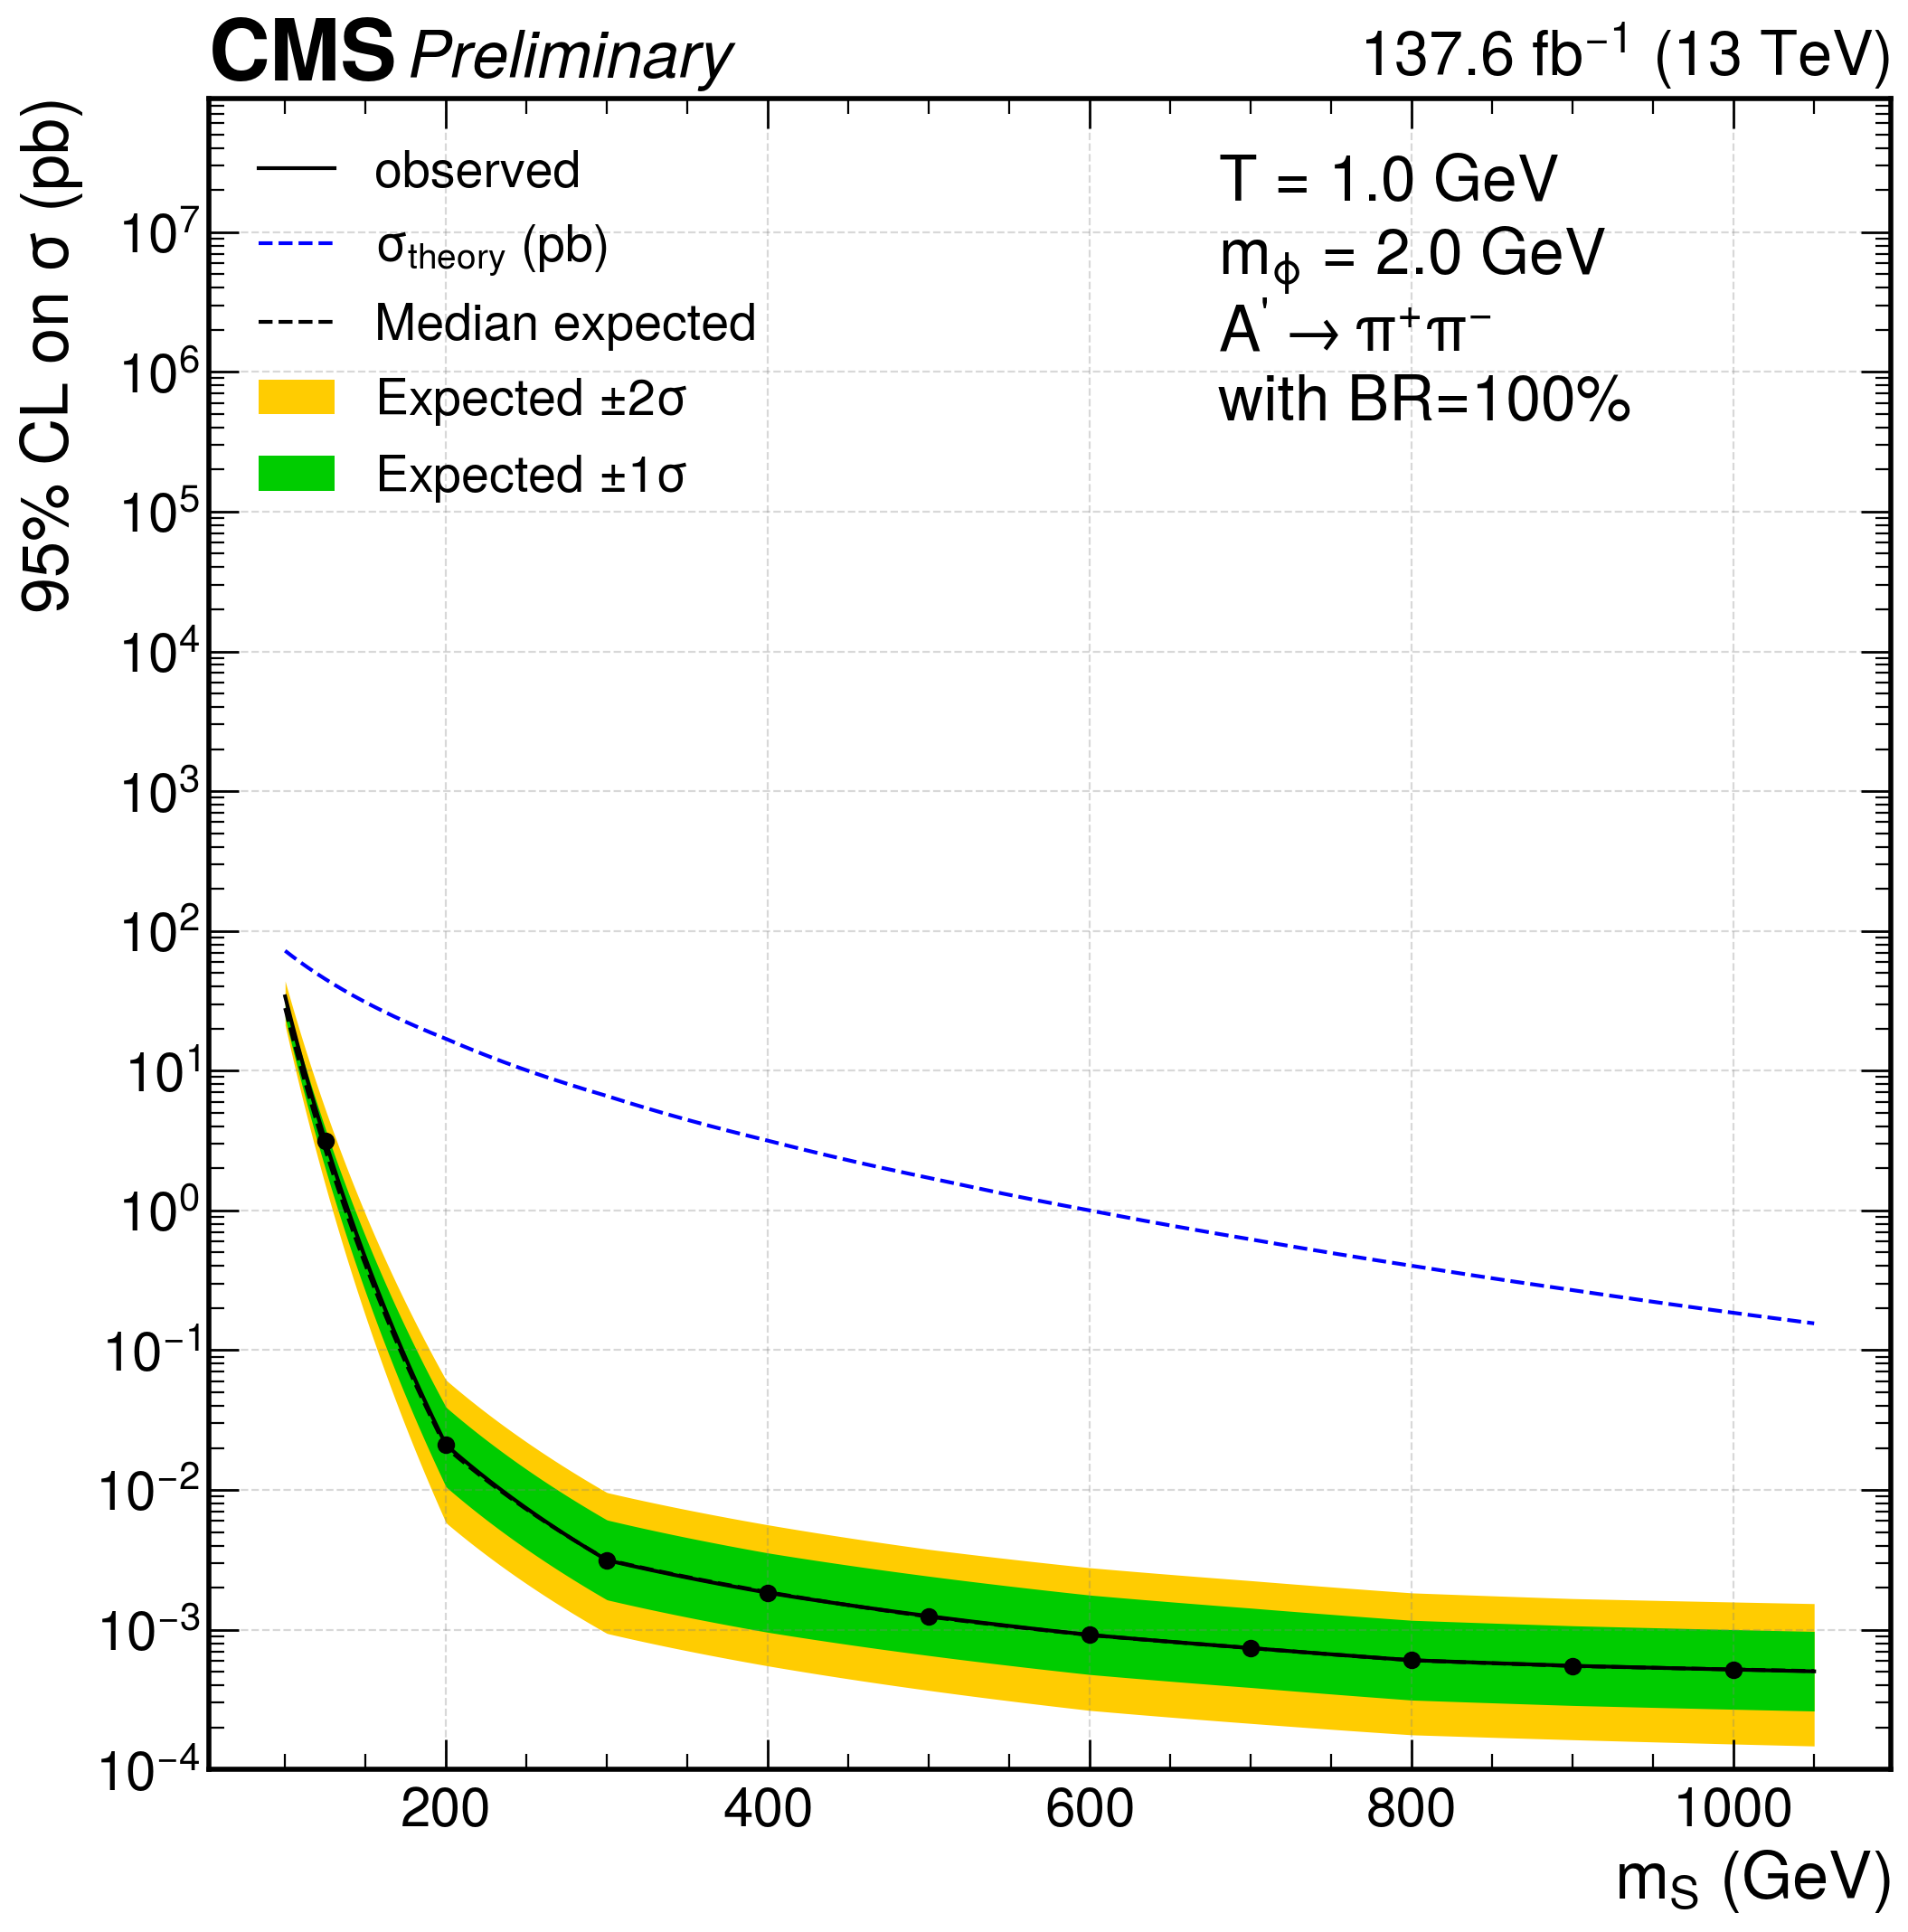

2.0 2.0 generic
[6.15816419e-04 3.60159365e-02 1.21917236e-03 4.86283345e-04
 8.05996160e-04 2.68622288e-03 3.52296373e+02 2.18898439e+00
 3.53650567e-04 4.04947593e-04]
[6.15921021e-04 3.09710693e-02 1.21330261e-03 4.87655640e-04
 8.08715820e-04 2.67608643e-03 3.29112500e+02 1.88557129e+00
 3.54270935e-04 4.04304504e-04]


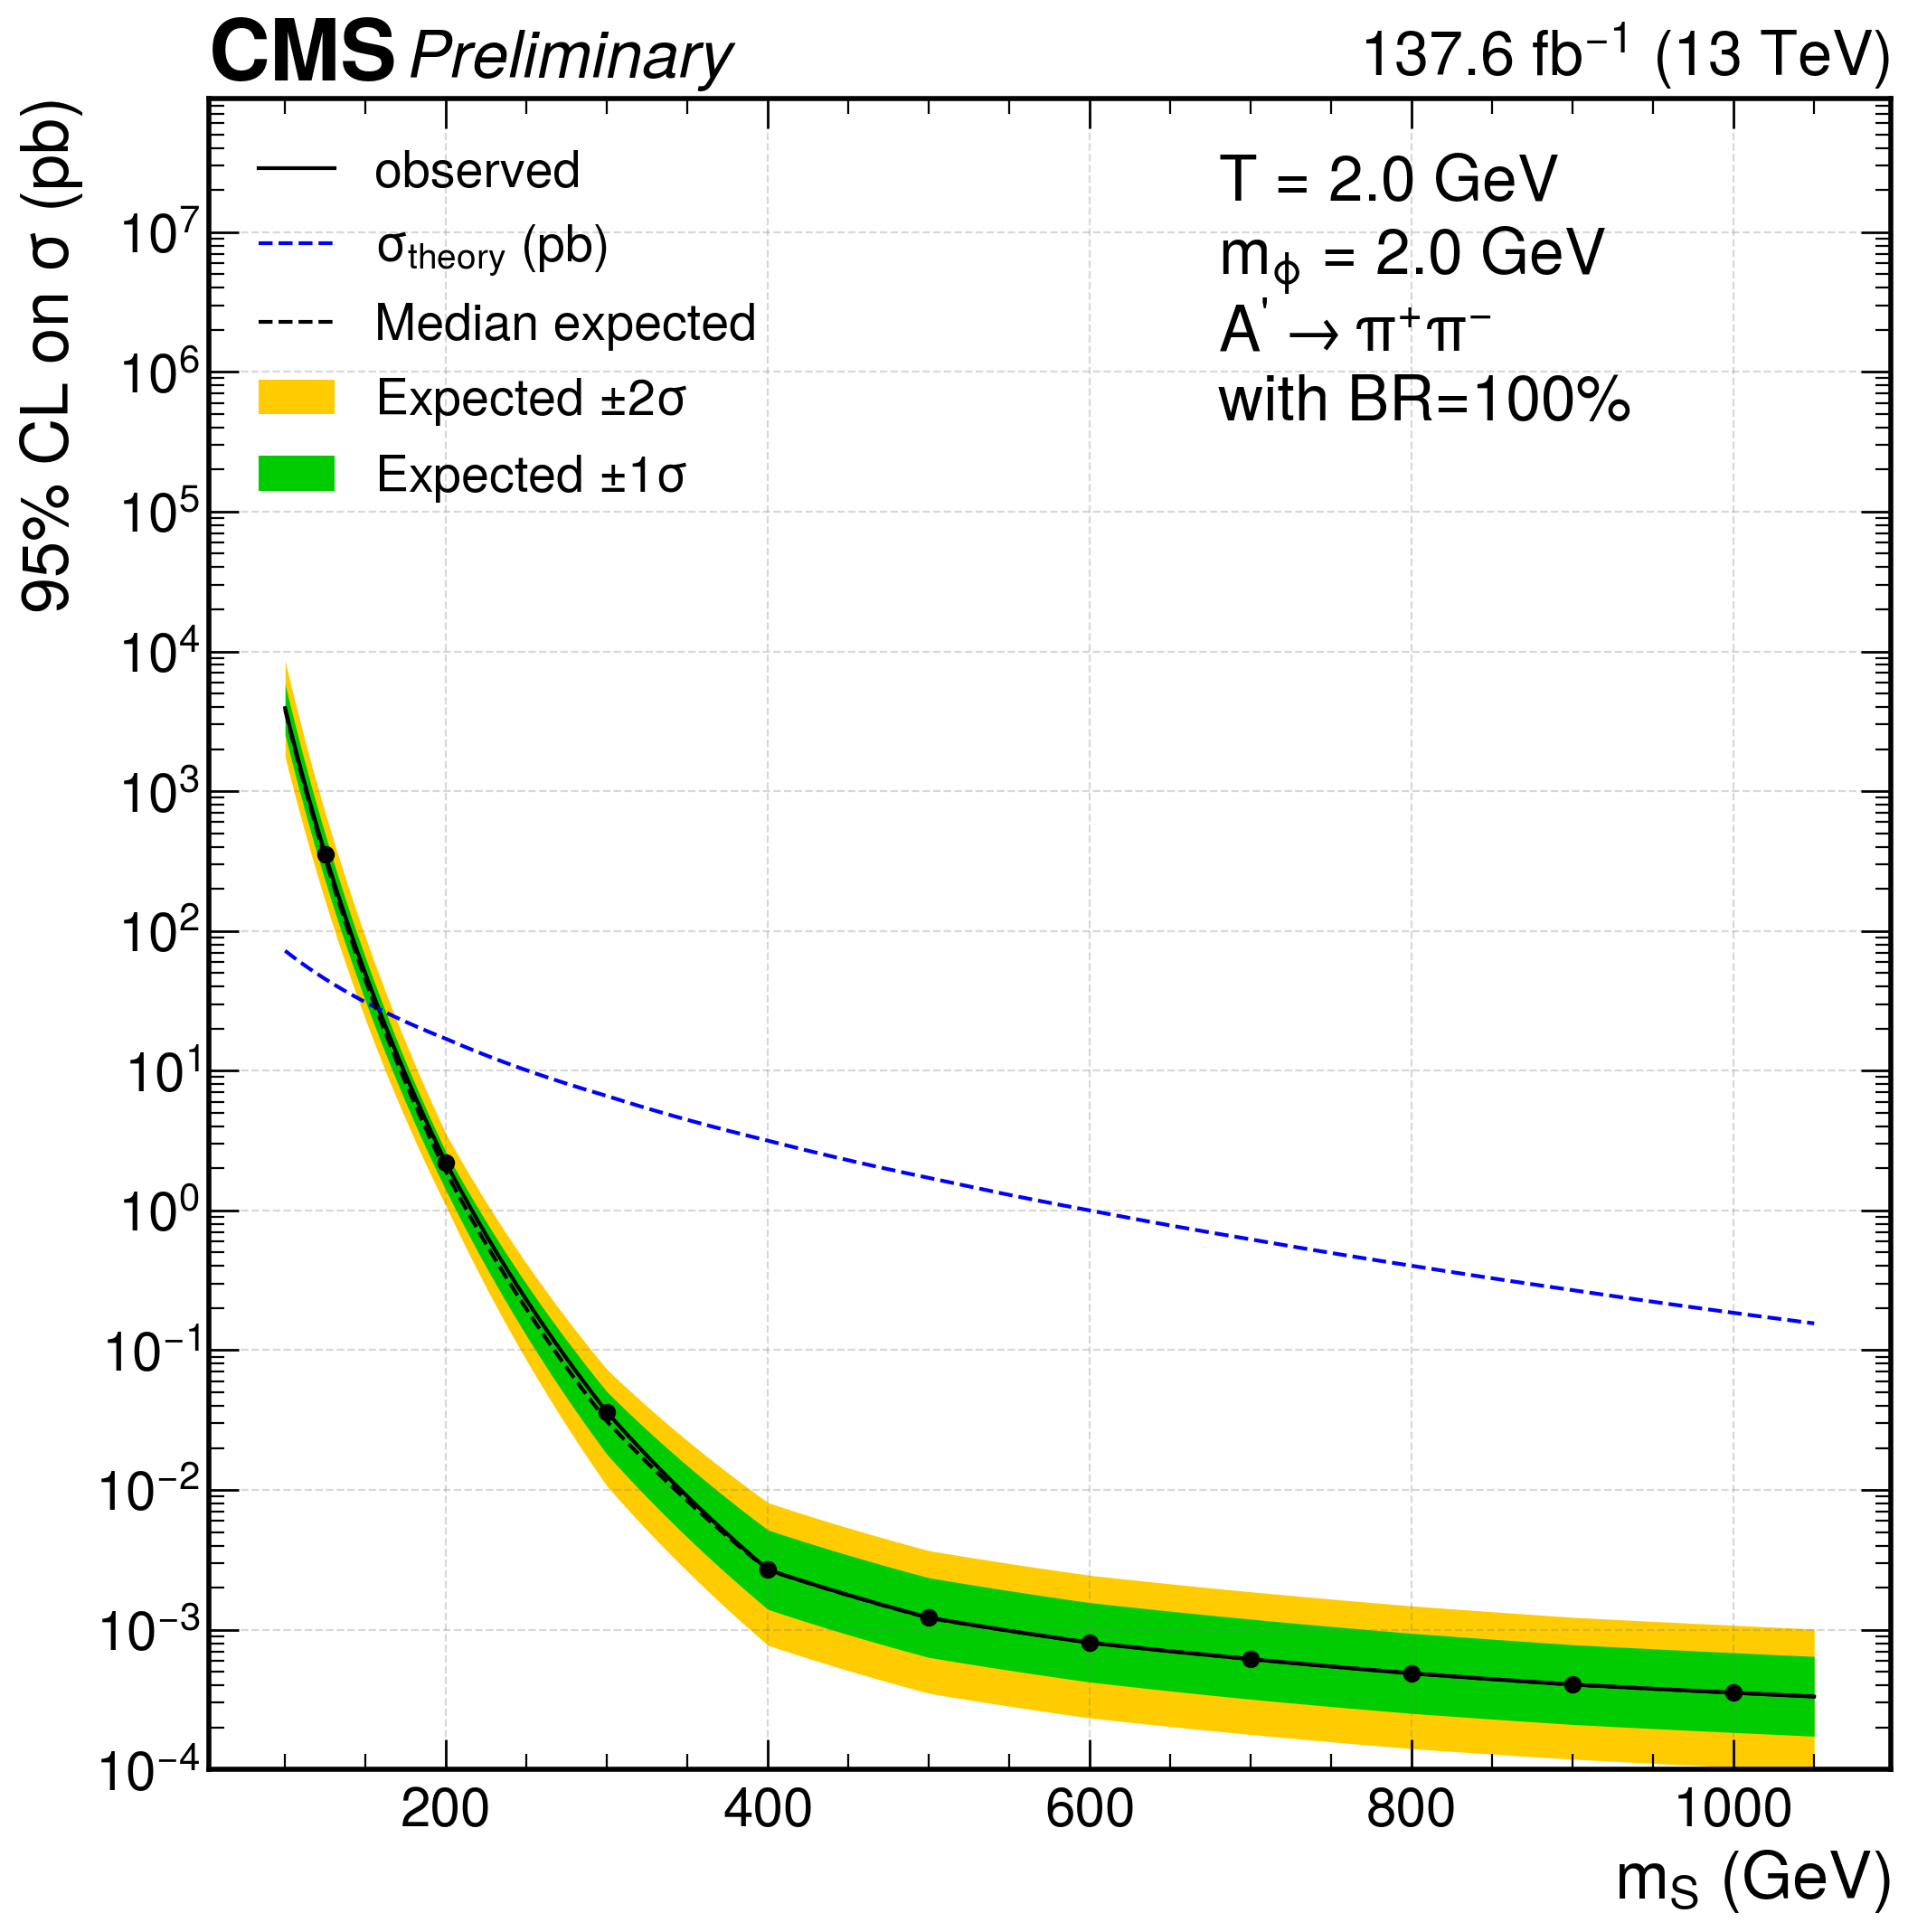

2.0 4.0 generic
[6.11842076e+02 1.06145337e+01 1.01885283e-02 1.18855884e-03
 2.69605472e-03 7.07455557e-04 5.09728179e-04 1.28546977e+04
 3.95421549e-01 4.37803847e-02]
[3.91868750e+02 8.28898438e+00 8.85009766e-03 1.15933228e-03
 2.56791687e-03 6.99836731e-04 5.05294800e-04 1.01474000e+04
 3.24023438e-01 3.60076904e-02]


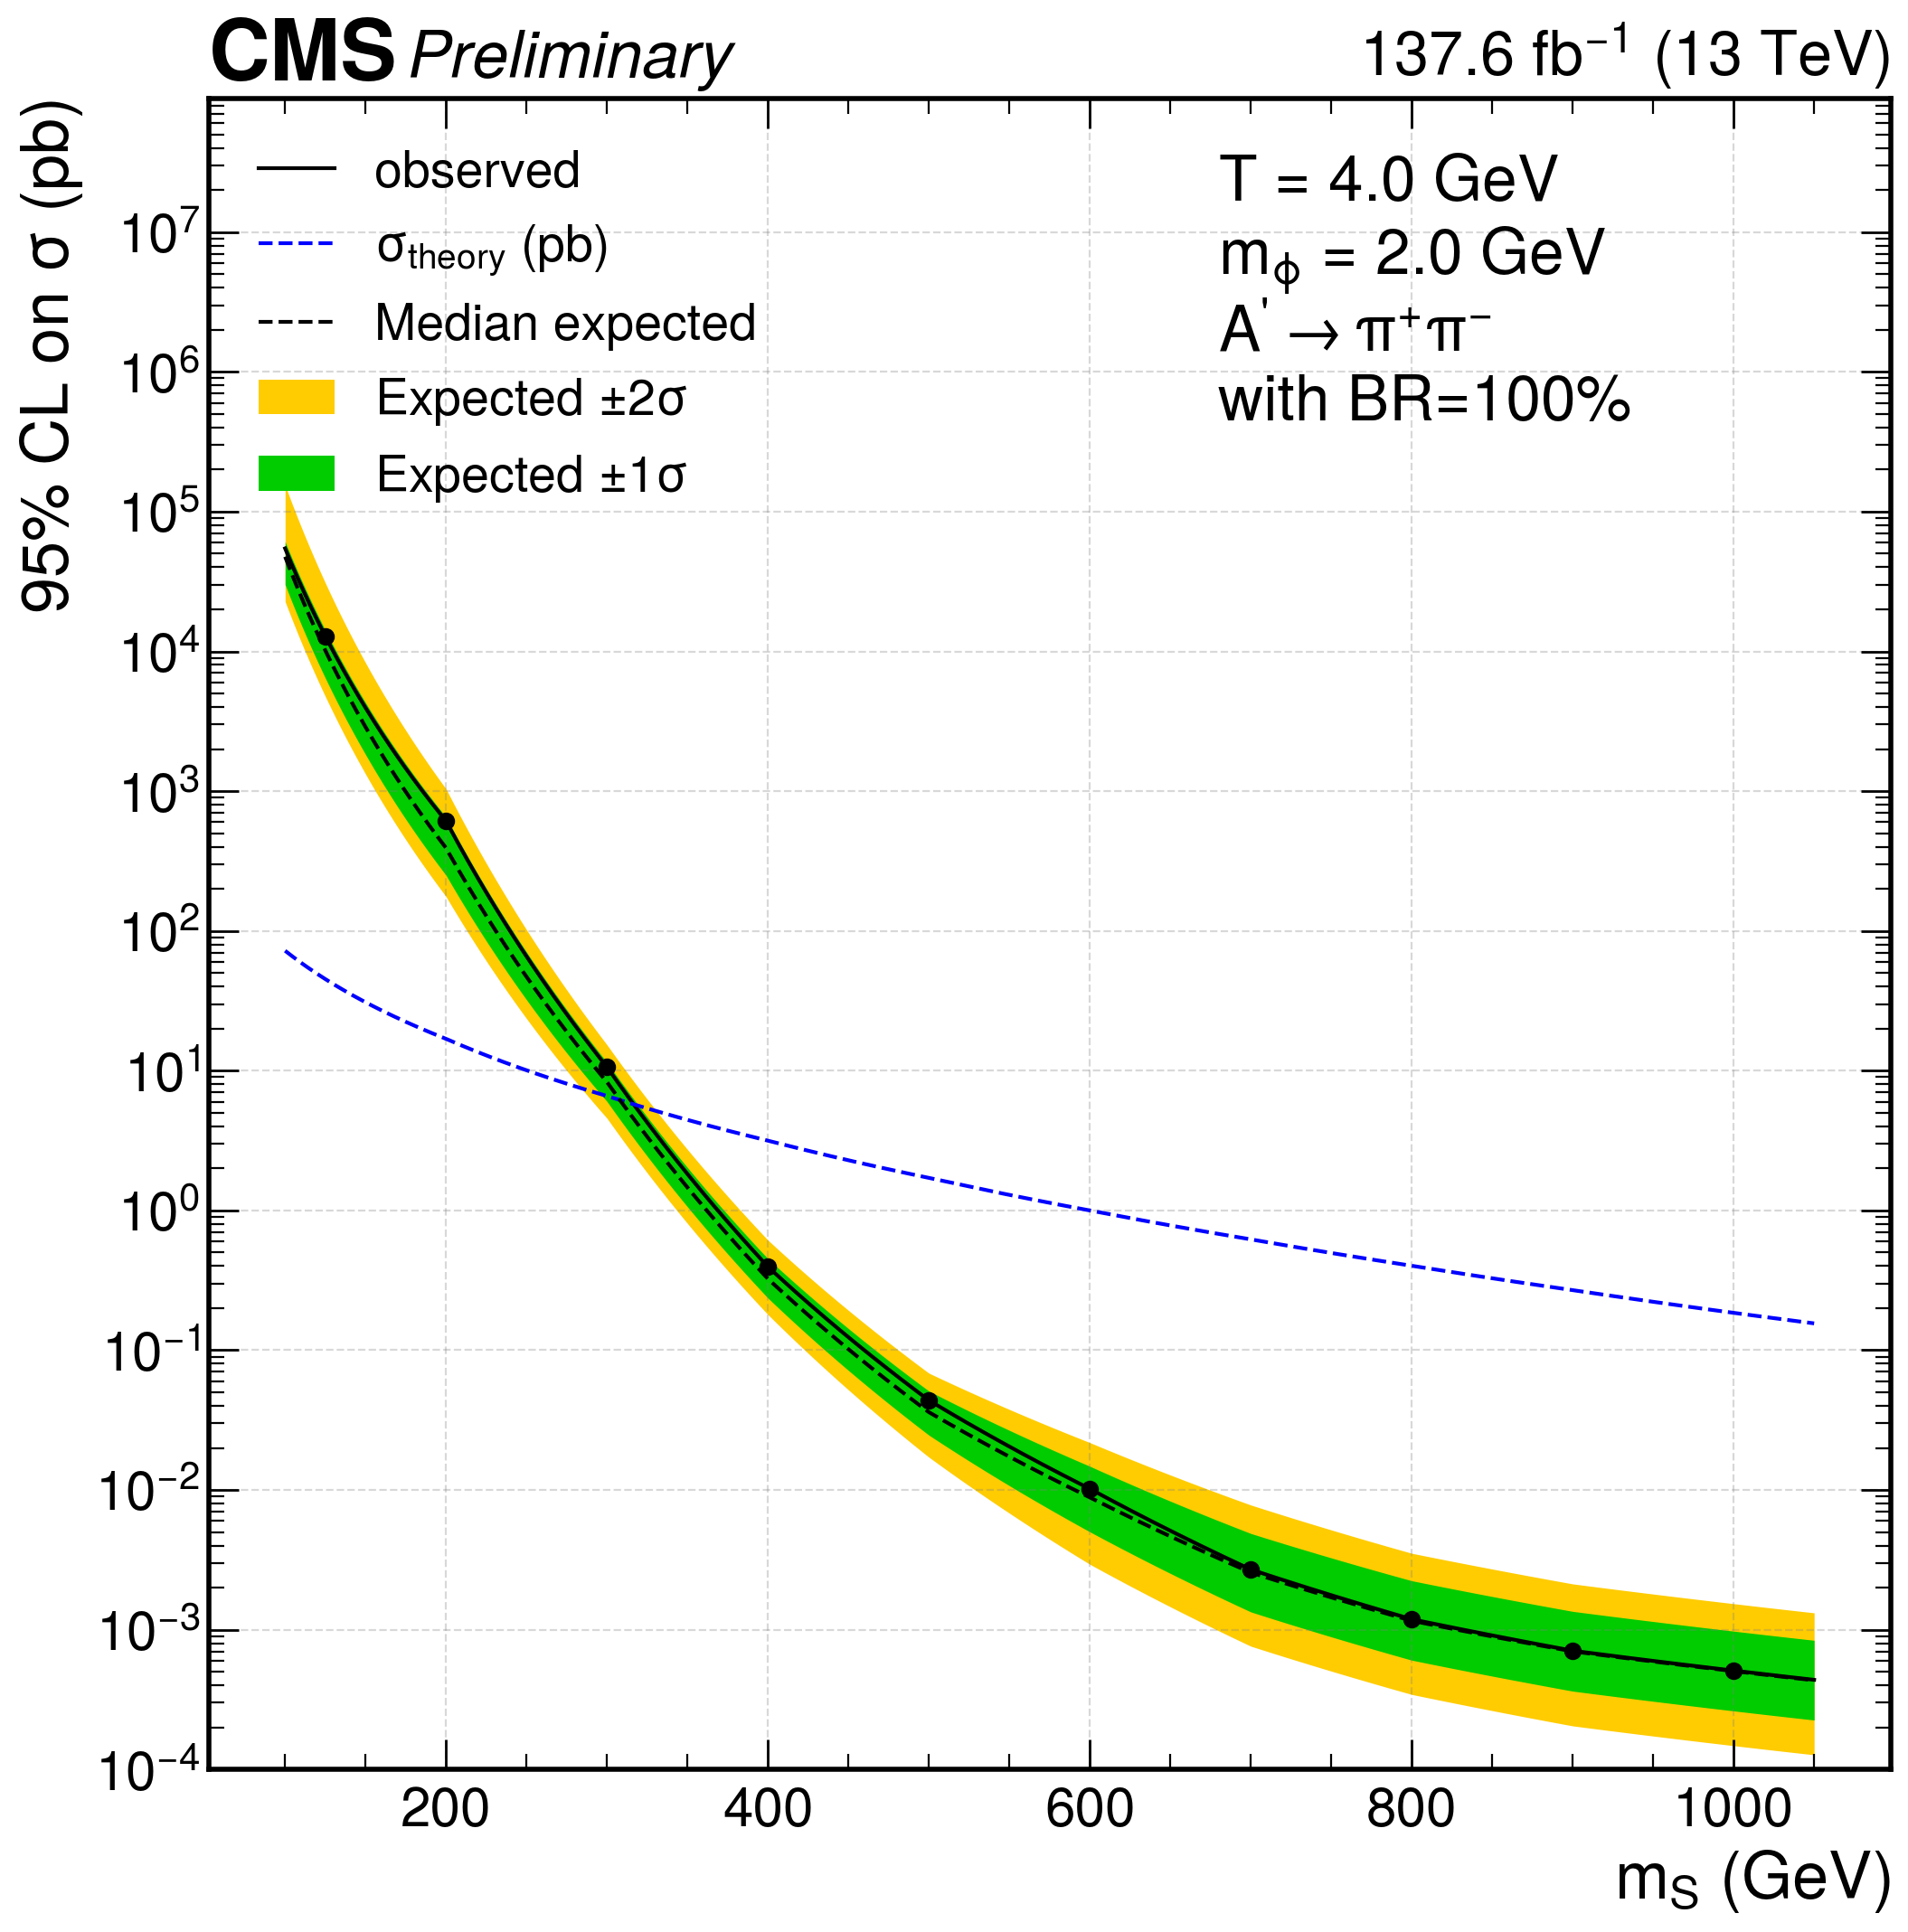

2.0 8.0 generic
[6.24528306e+02 1.56394297e+00 2.47181324e+03 7.38098029e+02
 7.42679859e-02 3.18193382e+01 3.11883874e+03 5.86610745e+00
 1.53752816e-01 4.04883762e-01]
[8.91297500e+02 1.18620703e+00 2.89835000e+03 6.65970000e+02
 6.10644531e-02 2.31384375e+01 2.63290000e+03 4.60937500e+00
 1.21890625e-01 3.17203125e-01]


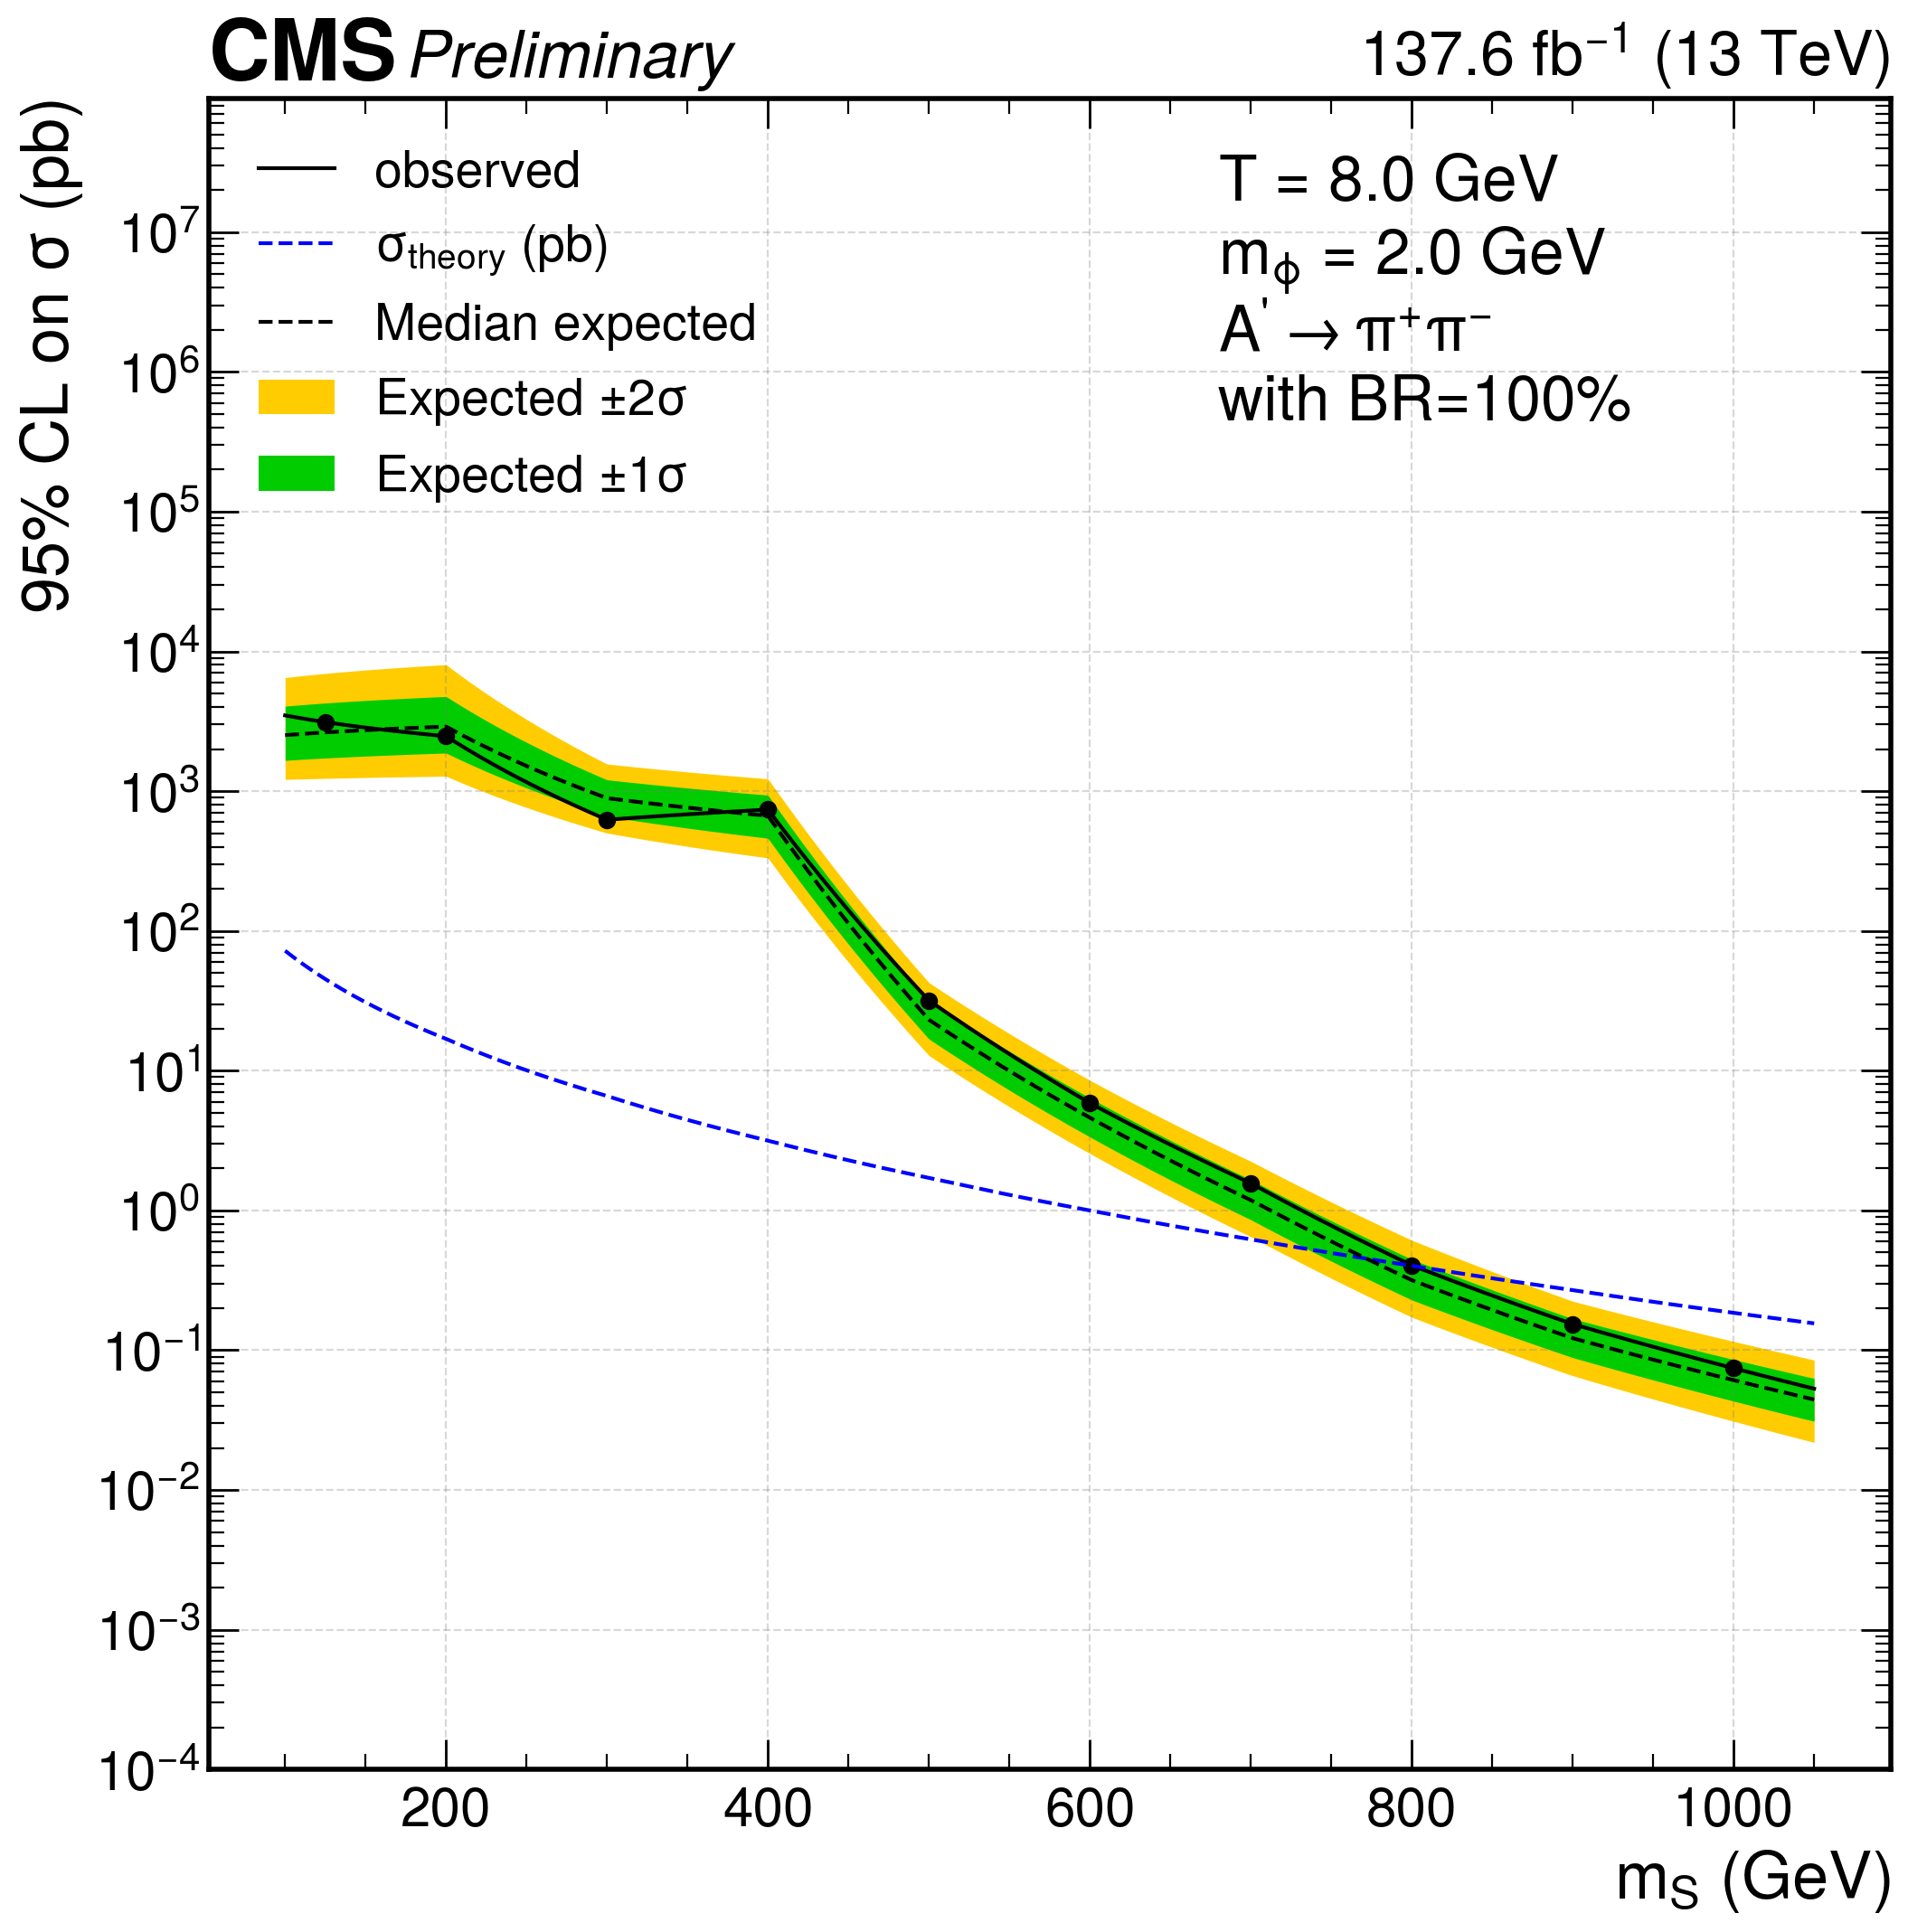

3.0 0.75 generic
[1.18319507e-03 5.54513454e-04 6.00231787e-02 6.80110943e-04
 3.09304865e-03 4.84322522e-04 4.38488246e-04 7.81897483e+00
 1.76696891e-03 8.60093553e-04]
[1.18721008e-03 5.55130005e-04 5.23483276e-02 6.82250977e-04
 3.06694031e-03 4.84344482e-04 4.37545776e-04 7.57011719e+00
 1.75994873e-03 8.62121582e-04]


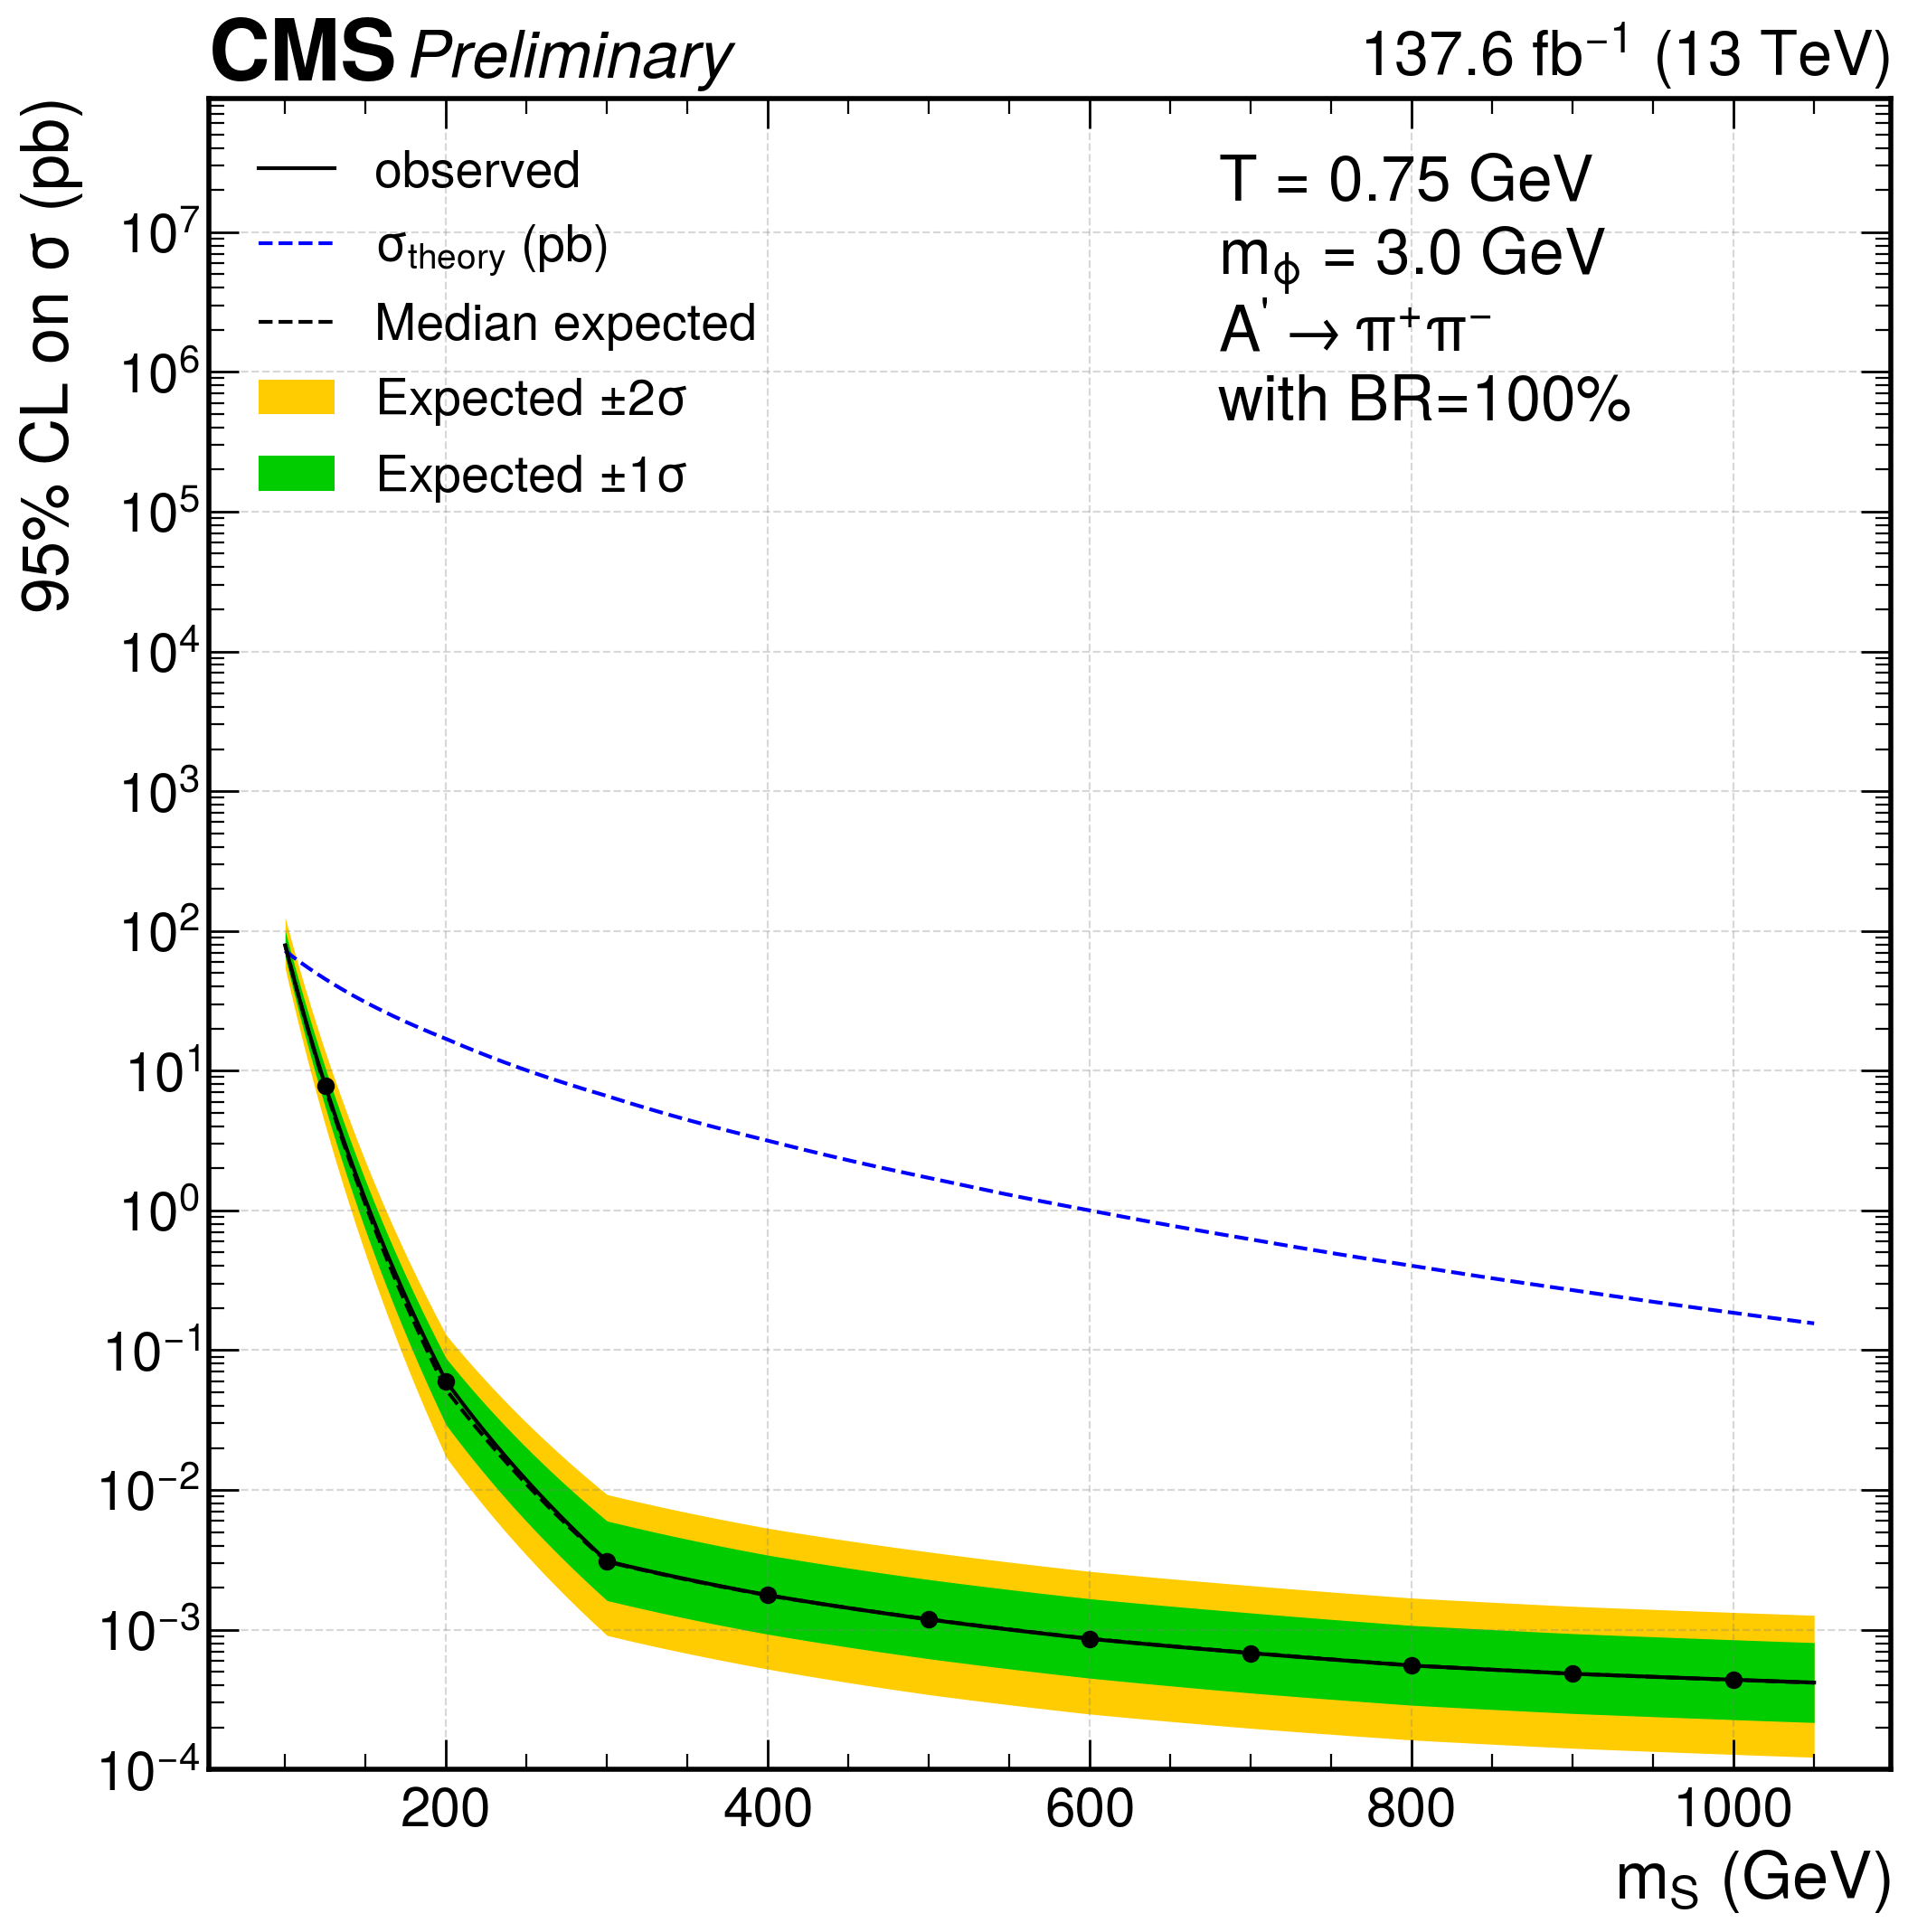

3.0 1.5 generic
[2.03997408e-03 3.90179105e-04 2.43725600e+02 6.01241725e-04
 4.72624537e-04 9.02010228e-01 1.14497837e-03 1.71990396e-02
 7.97055749e-04 3.42313748e-04]
[2.02514648e-03 3.89938354e-04 1.70559375e+02 6.01707458e-04
 4.72320557e-04 7.63305664e-01 1.13502502e-03 1.57872009e-02
 8.01086426e-04 3.42979431e-04]


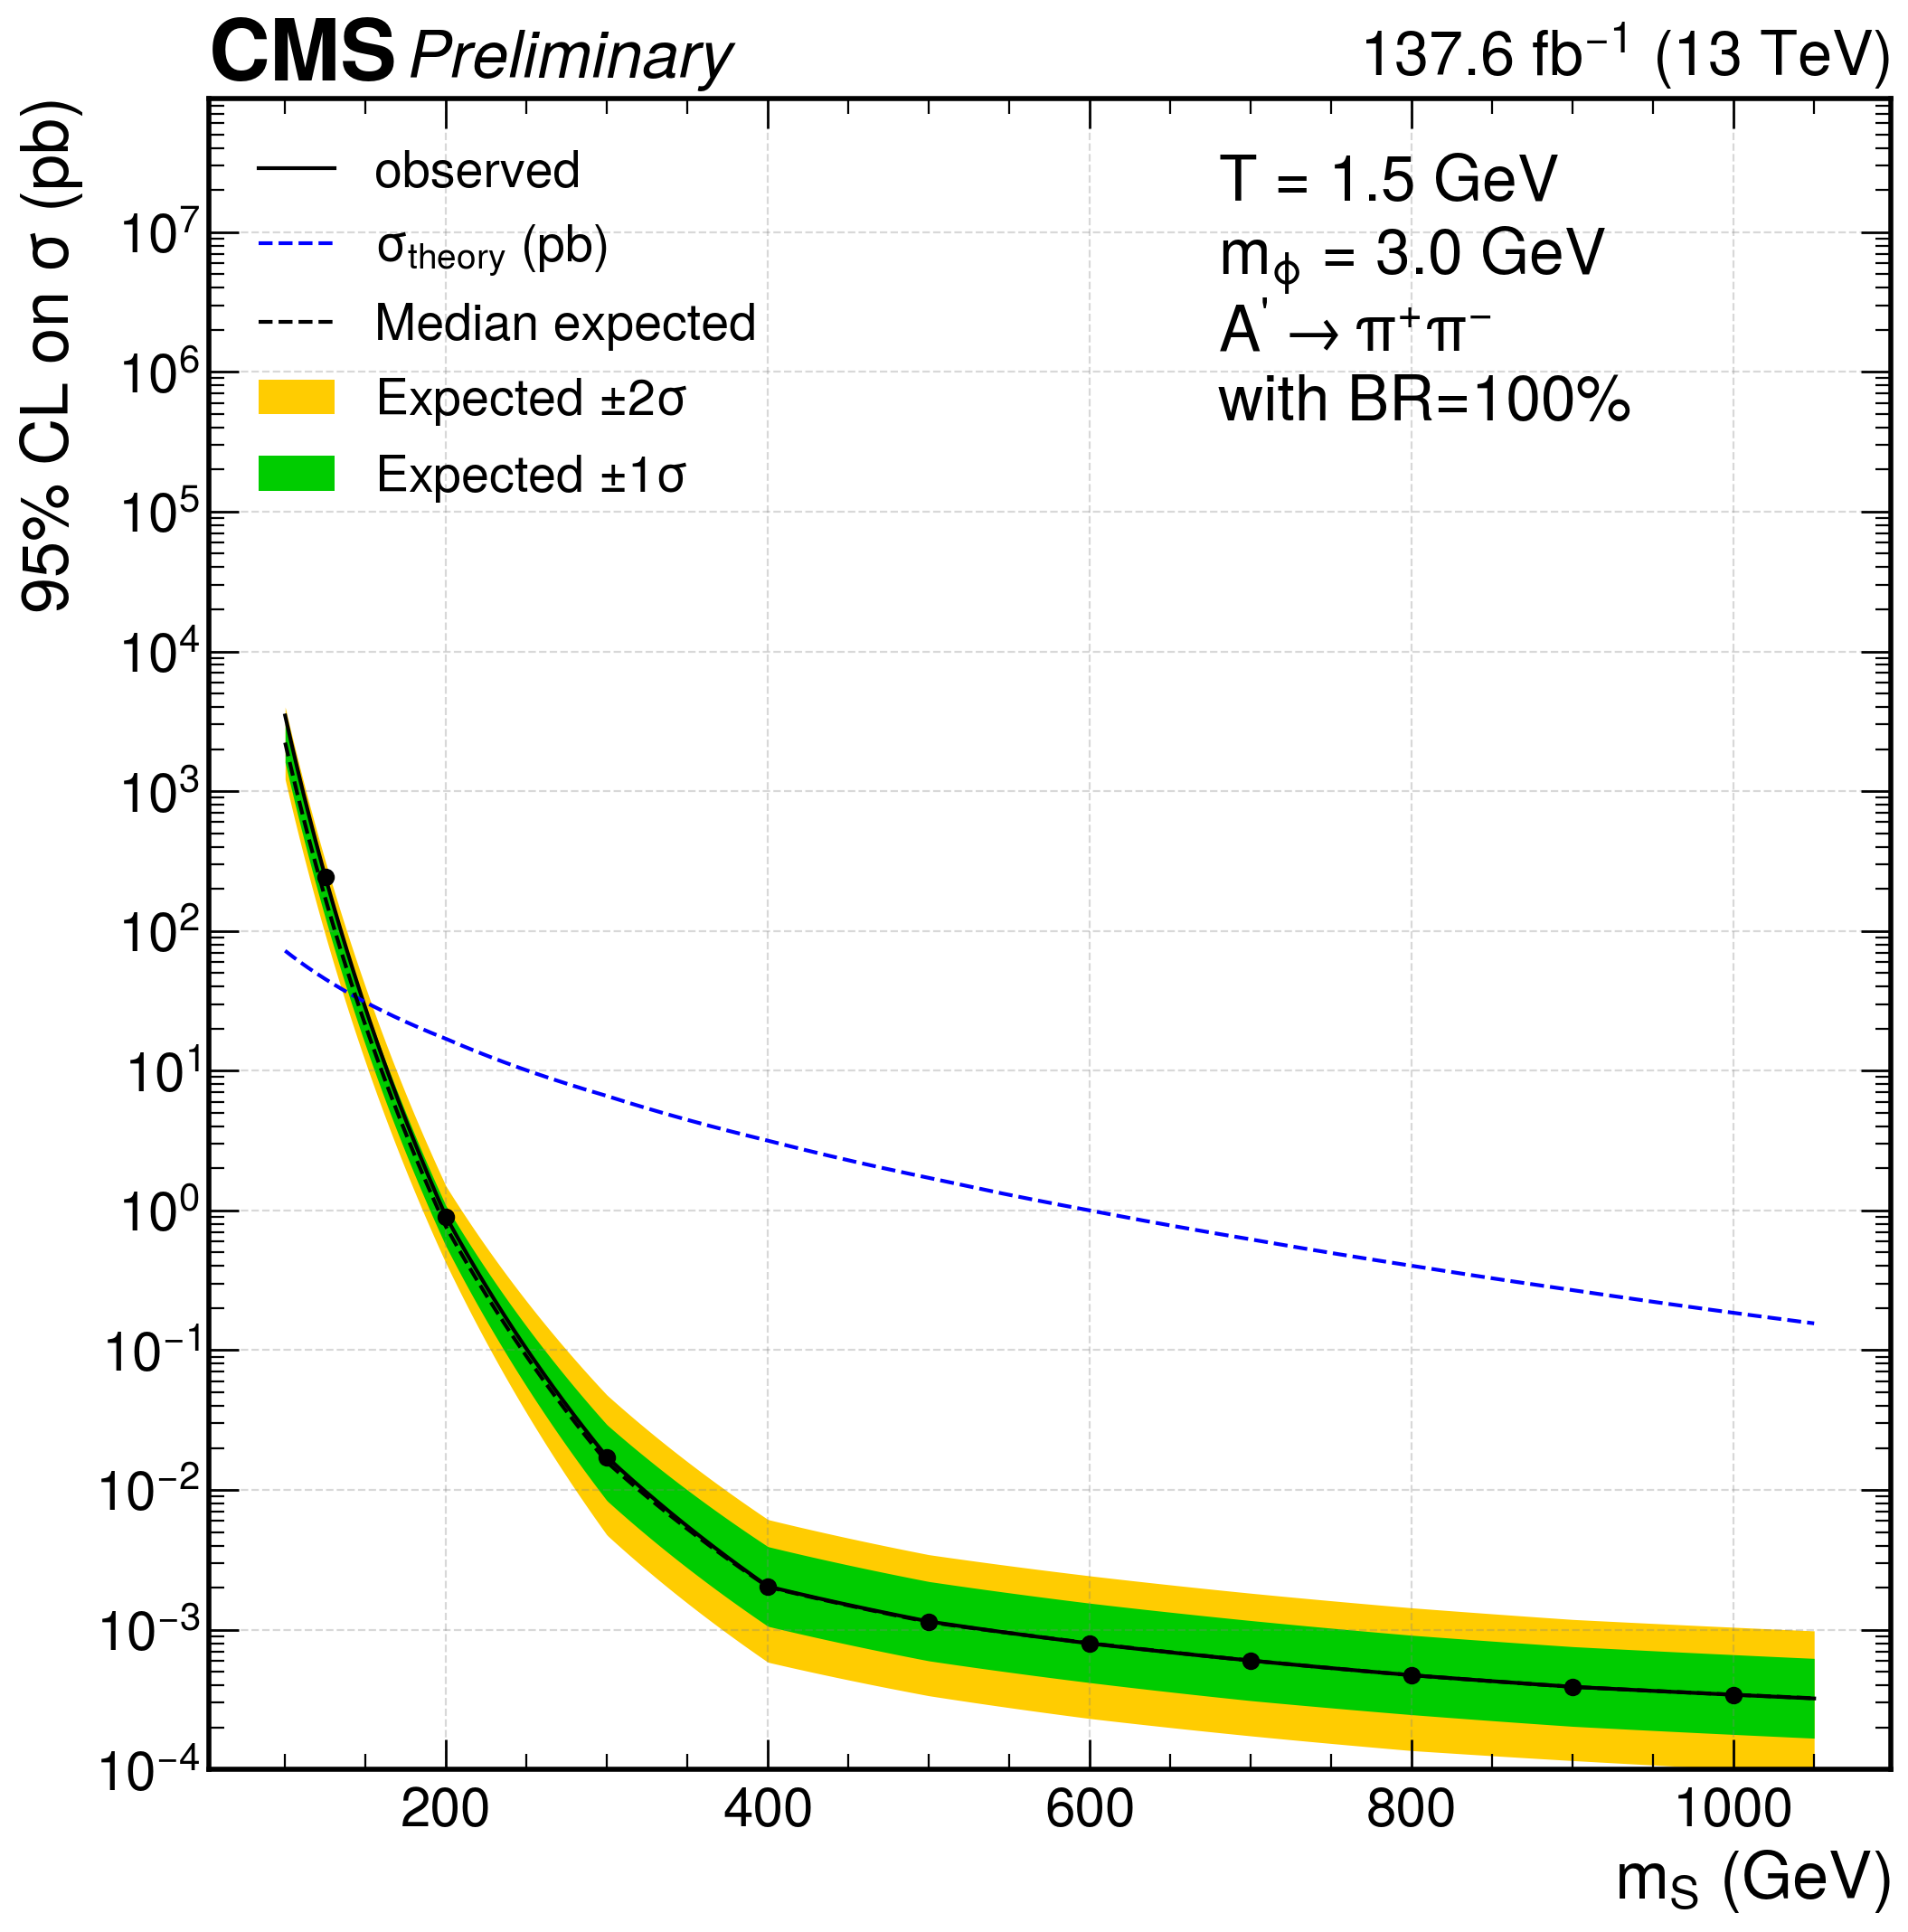

3.0 3.0 generic
[3.28200114e-04 4.13624511e-04 9.68119330e-04 1.38864708e+02
 5.78447719e-04 1.04179506e-02 2.16382429e-03 1.84102786e+03
 1.59672011e+00 6.95763365e-02]
[3.27453613e-04 4.12513733e-04 9.57046509e-04 1.01664062e+02
 5.76599121e-04 9.28894043e-03 2.10571289e-03 2.72895000e+03
 1.32250488e+00 5.72827148e-02]


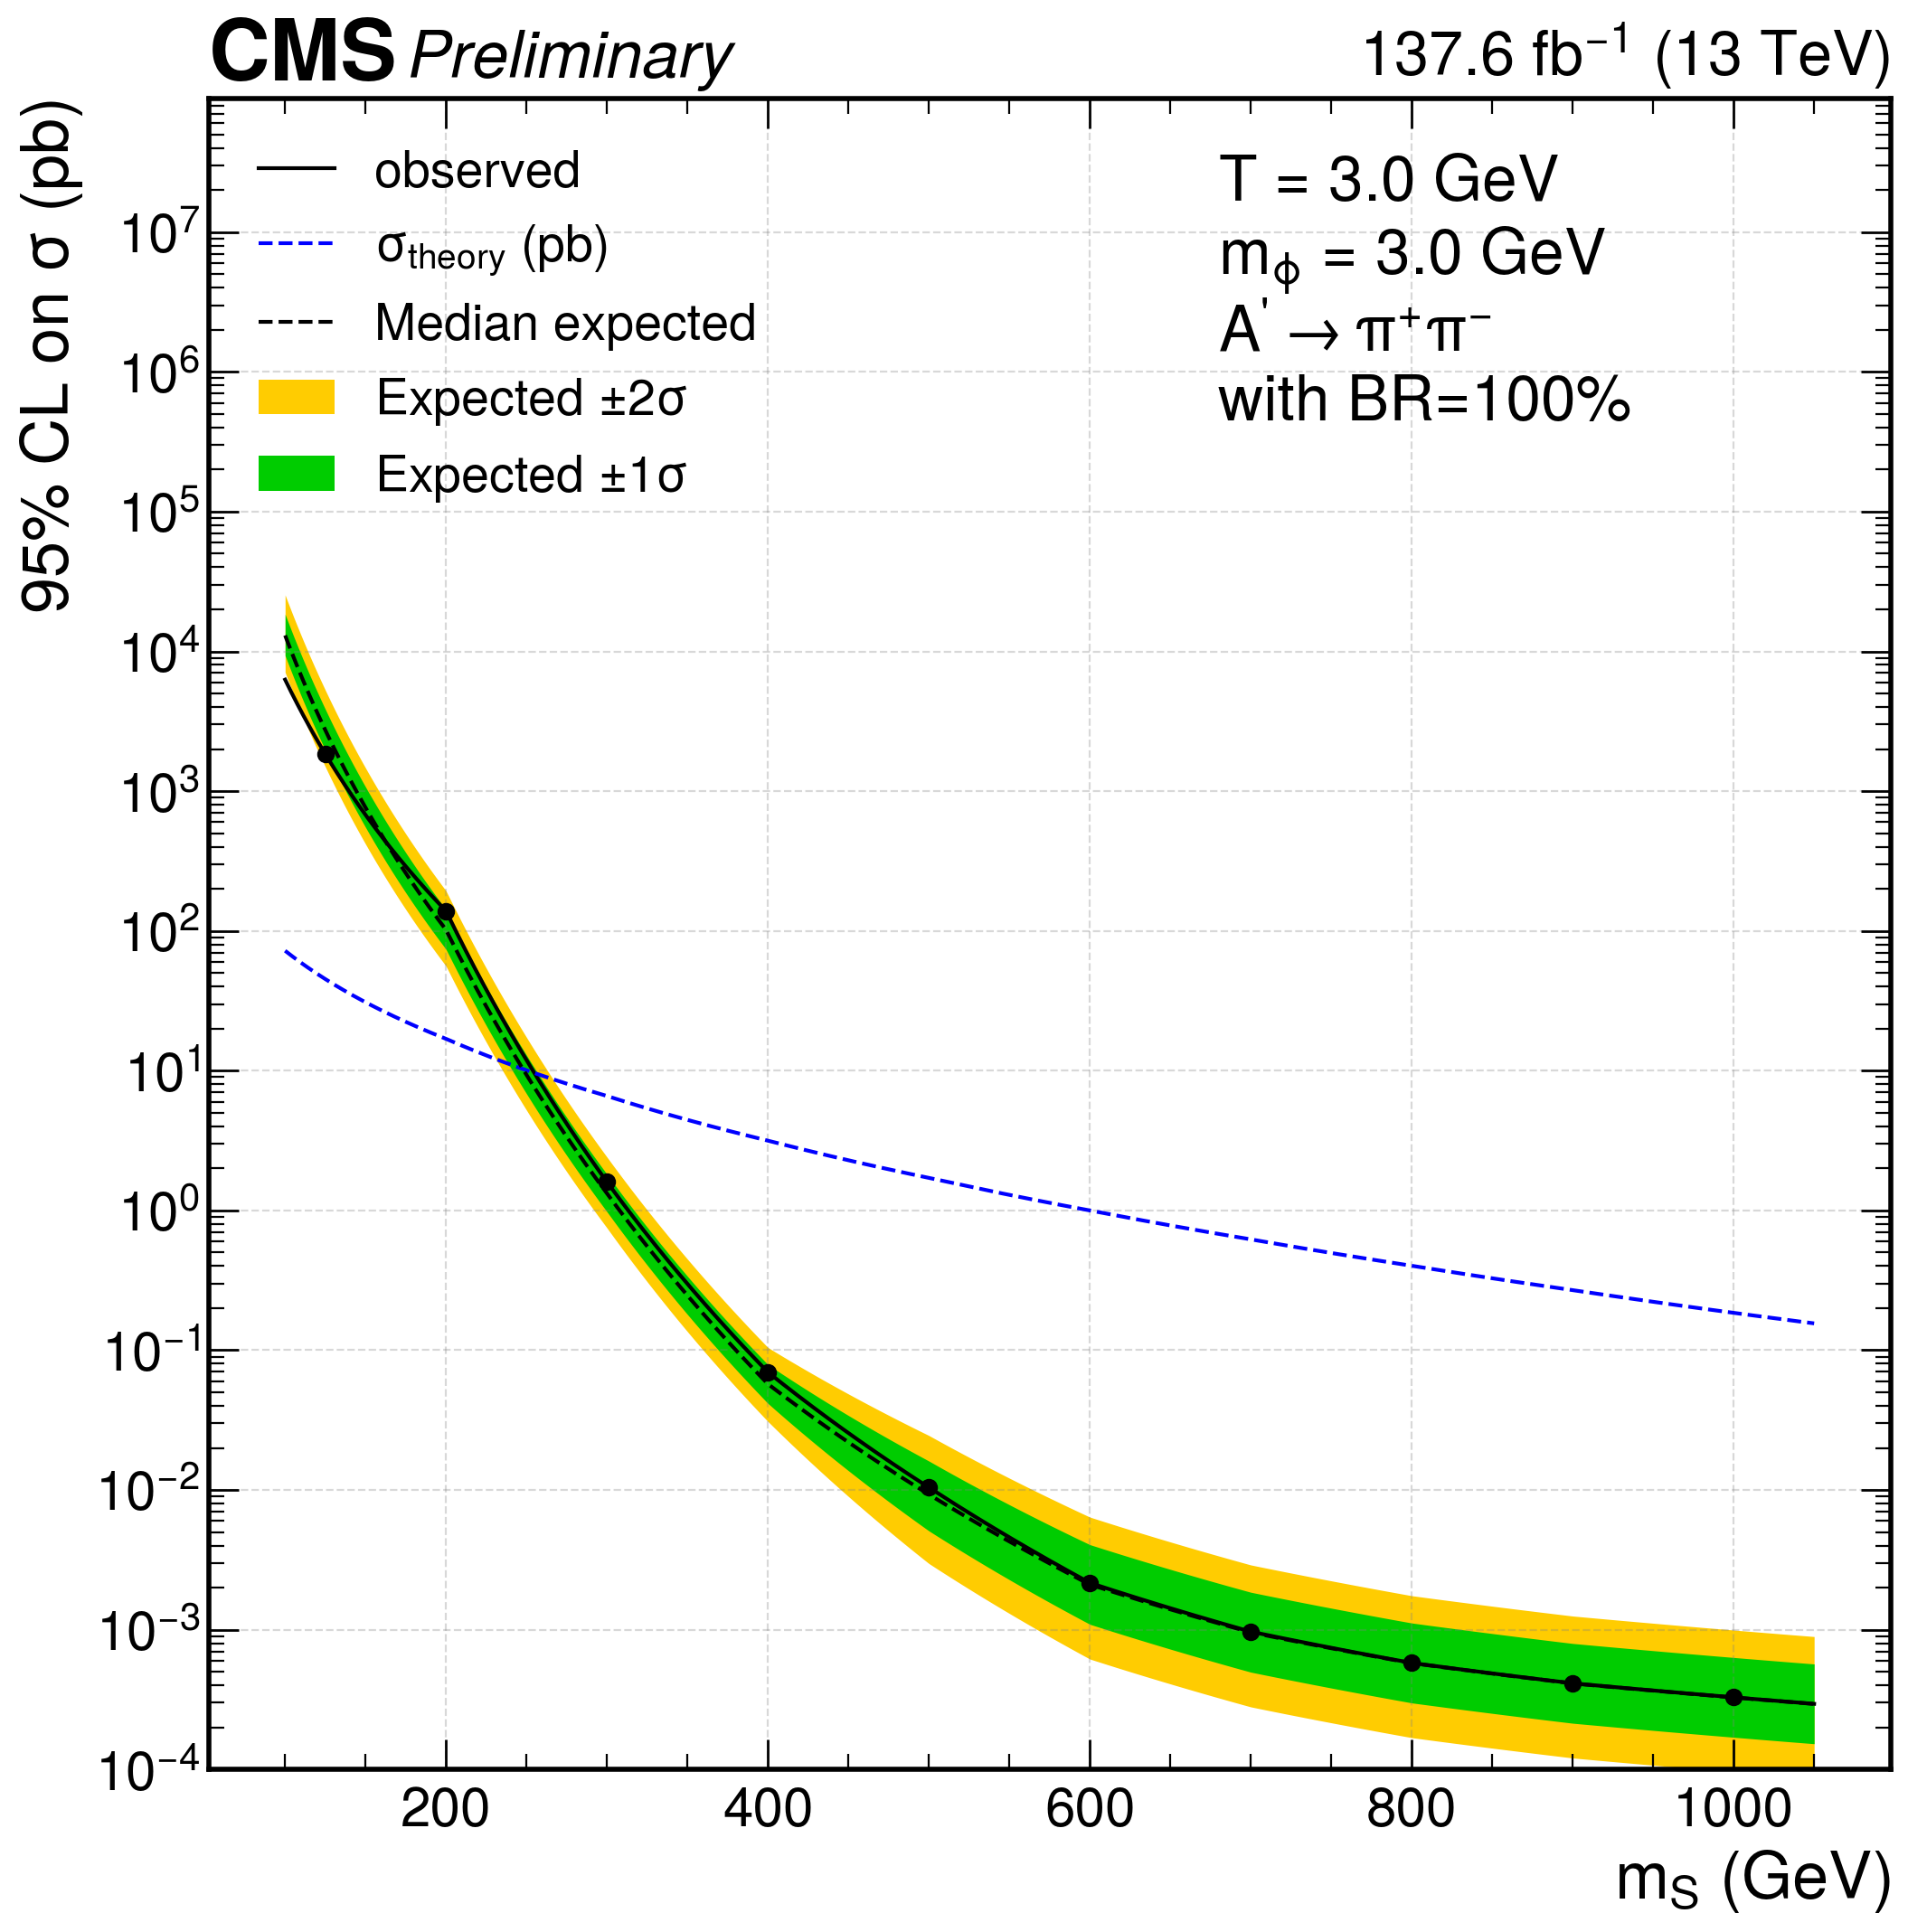

3.0 6.0 generic
[2.86449200e+04 1.06271534e-01 1.87378172e+03 1.07976582e+03
 1.60504565e-02 2.83244765e+01 7.98882098e-03 3.70693779e-02
 3.13069030e+00 4.81275709e-01]
[2.06790000e+04 8.71765137e-02 2.65330000e+03 1.11865250e+03
 1.33974609e-02 1.99968750e+01 6.77490234e-03 3.02285156e-02
 2.39132812e+00 3.82812500e-01]


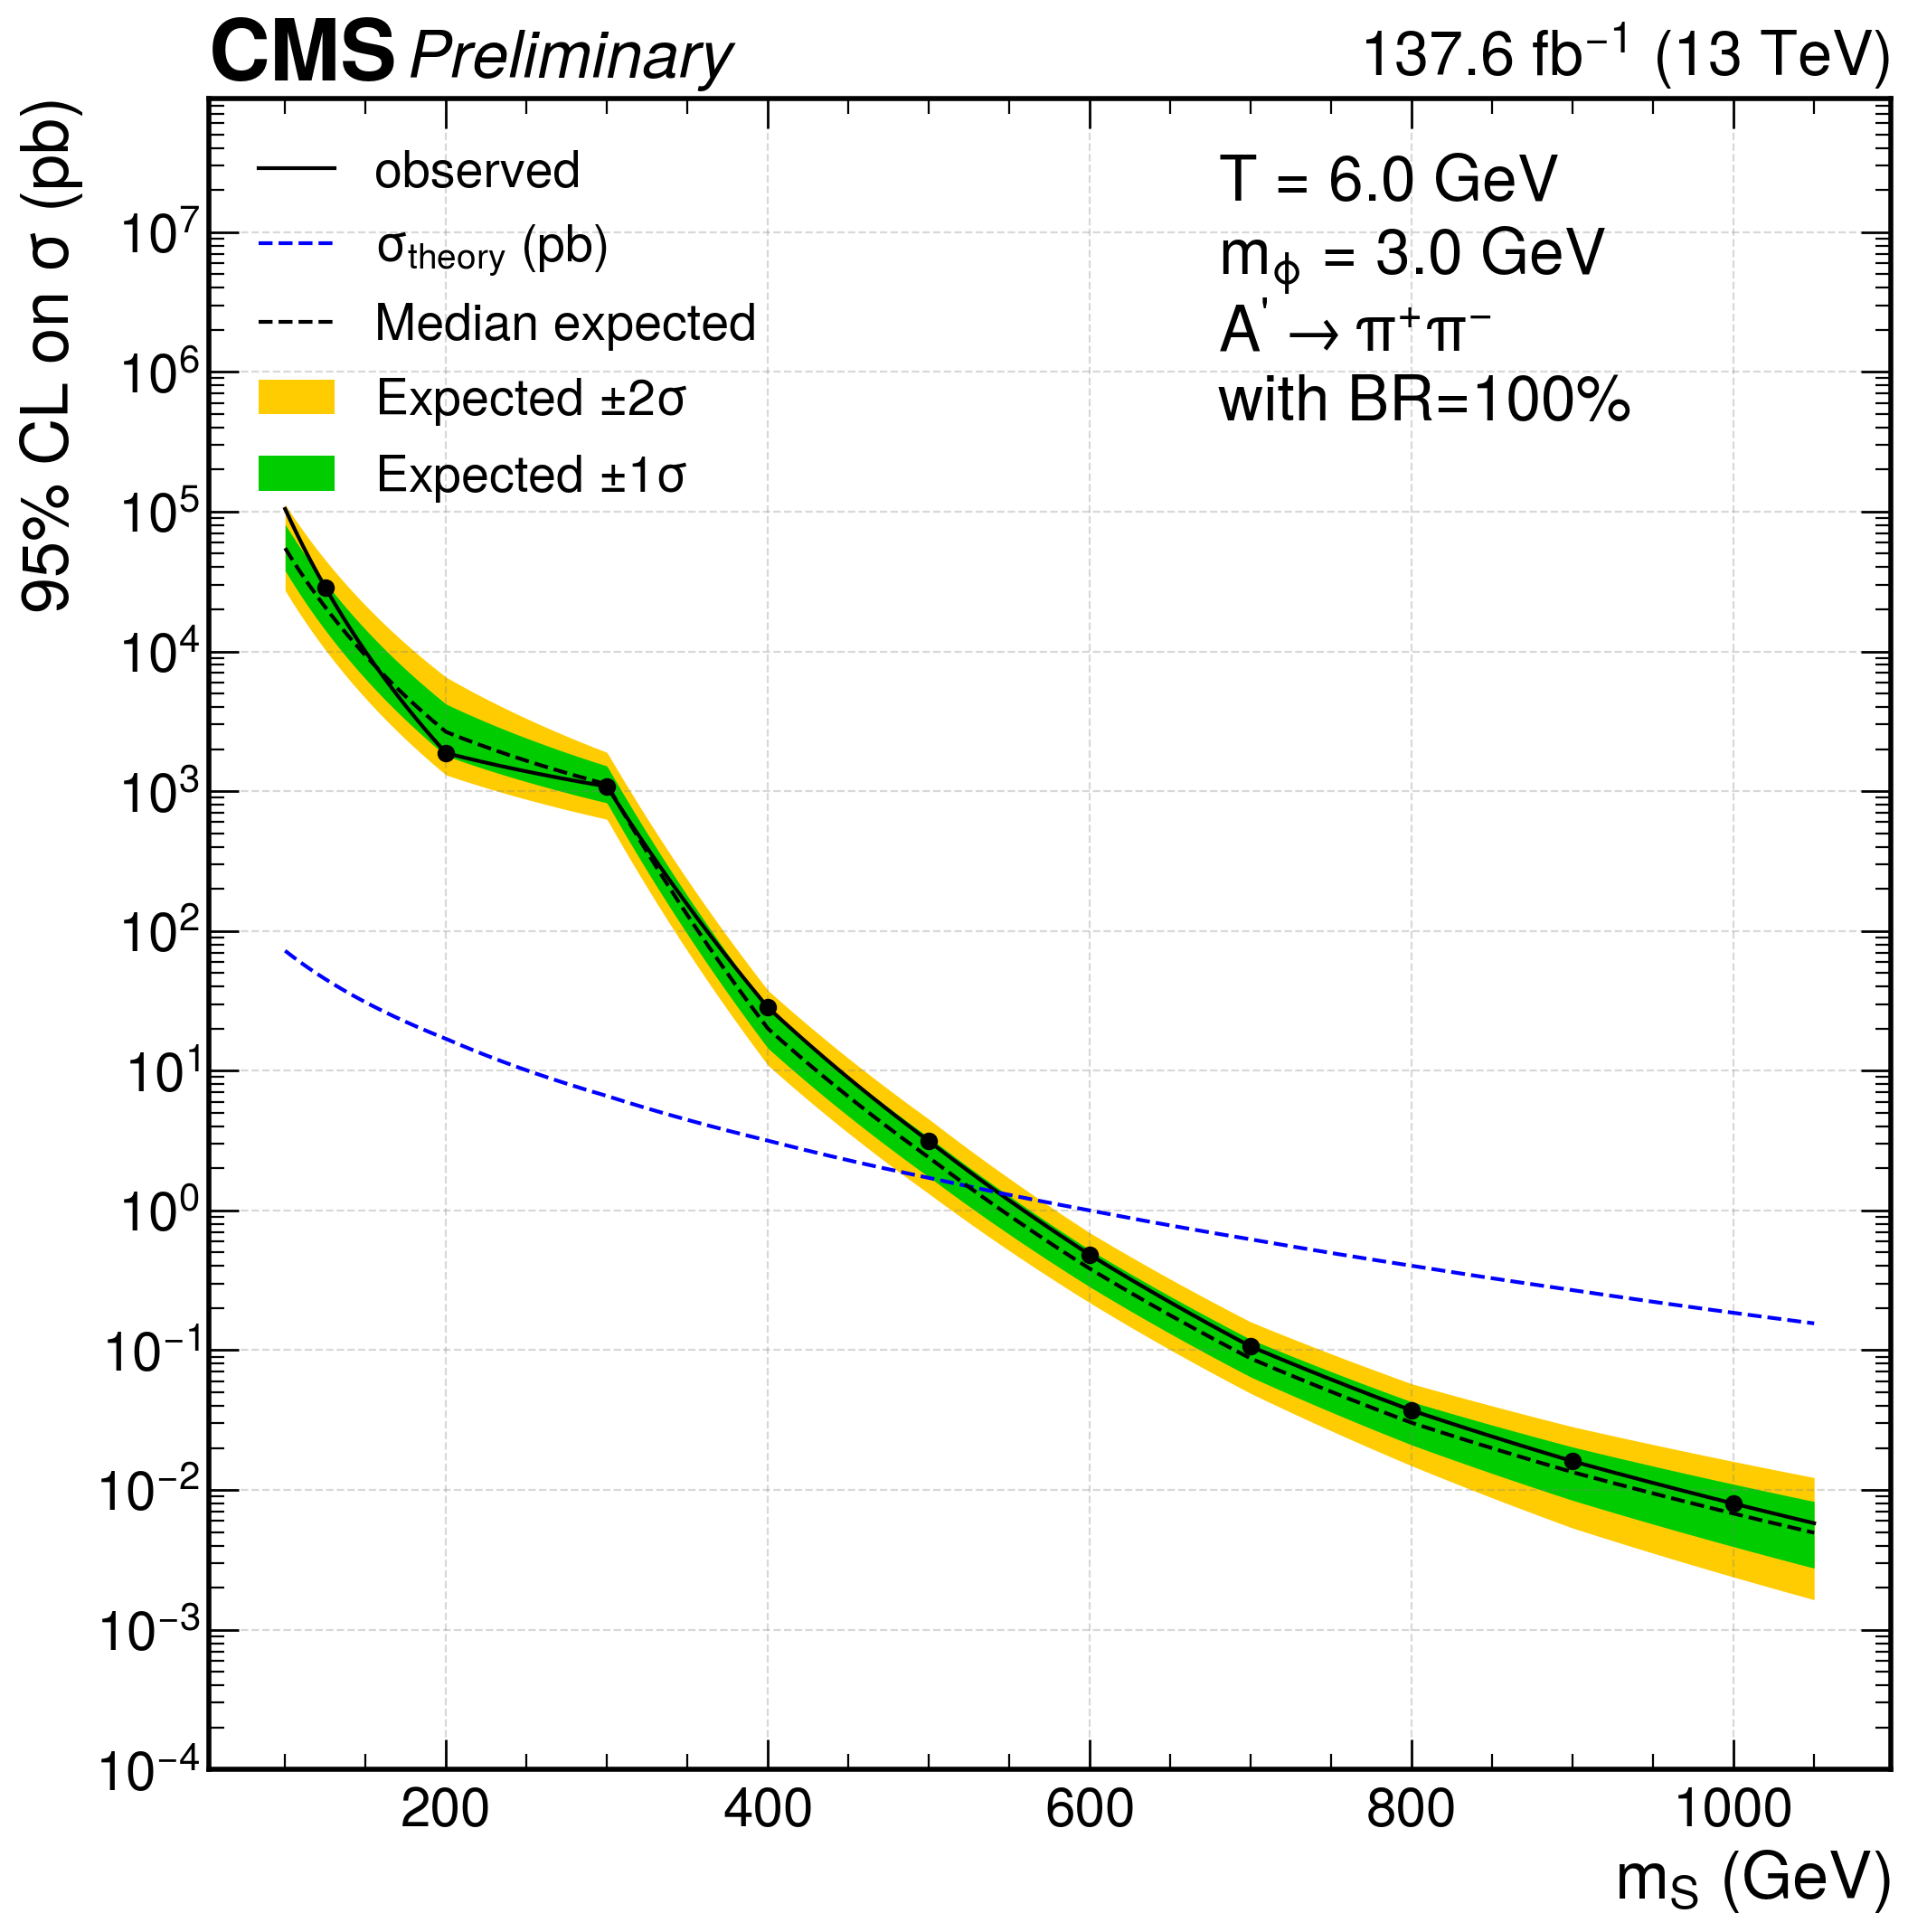

3.0 12.0 generic
[8.70159826e+02 5.84981167e+01 5.32147176e+03 3.78155014e+01
 1.88618555e+04 7.23270828e+00 7.03020711e+03 1.33486402e+01
 3.18868002e+02 2.72818995e+02]
[1.245040e+03 5.123250e+01 4.604750e+03 2.803950e+01 1.553110e+04
 4.902500e+00 8.293515e+03 9.751250e+00 4.475000e+02 3.980025e+02]


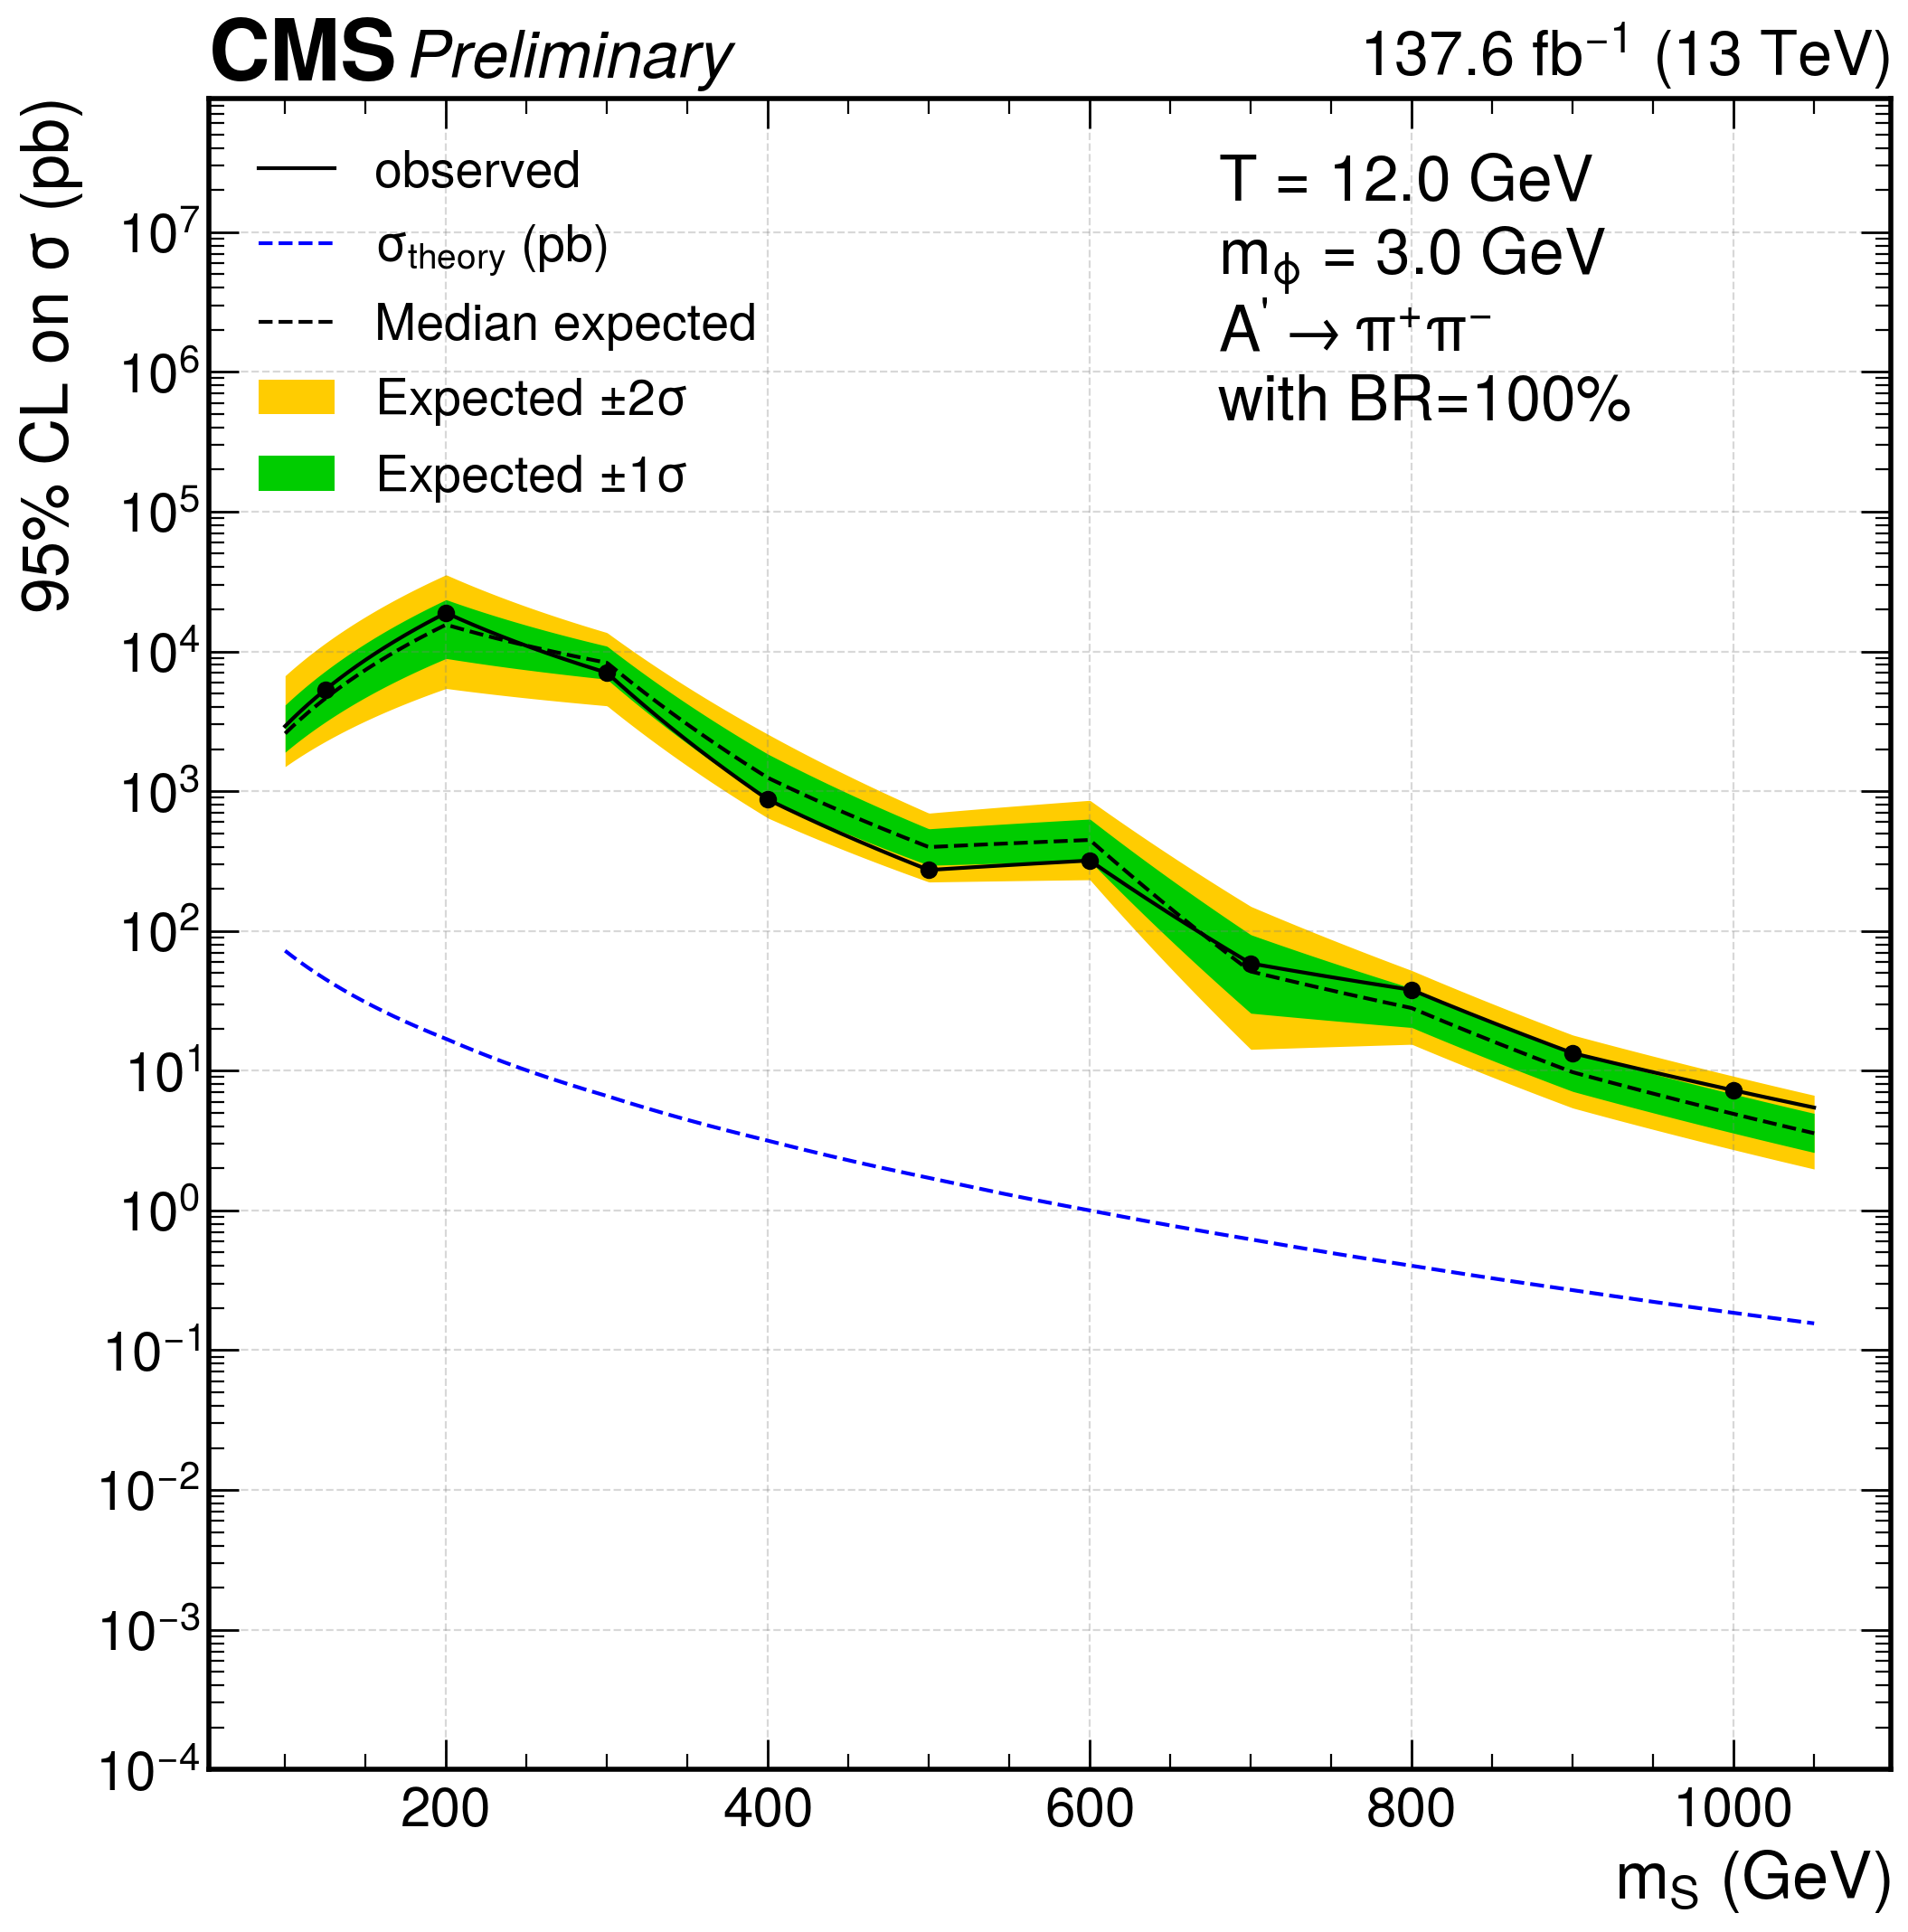

4.0 1.0 generic
[6.15274487e-01 6.01038846e-04 1.79732951e-03 3.43773761e-04
 1.75905572e+02 7.95136816e-04 3.94966050e-04 1.12356552e-03
 4.79926330e-04 1.01355244e-02]
[5.07495117e-01 6.01707458e-04 1.80816650e-03 3.44390869e-04
 1.21828125e+02 8.01086426e-04 3.96095276e-04 1.12197876e-03
 4.81521606e-04 9.70359802e-03]


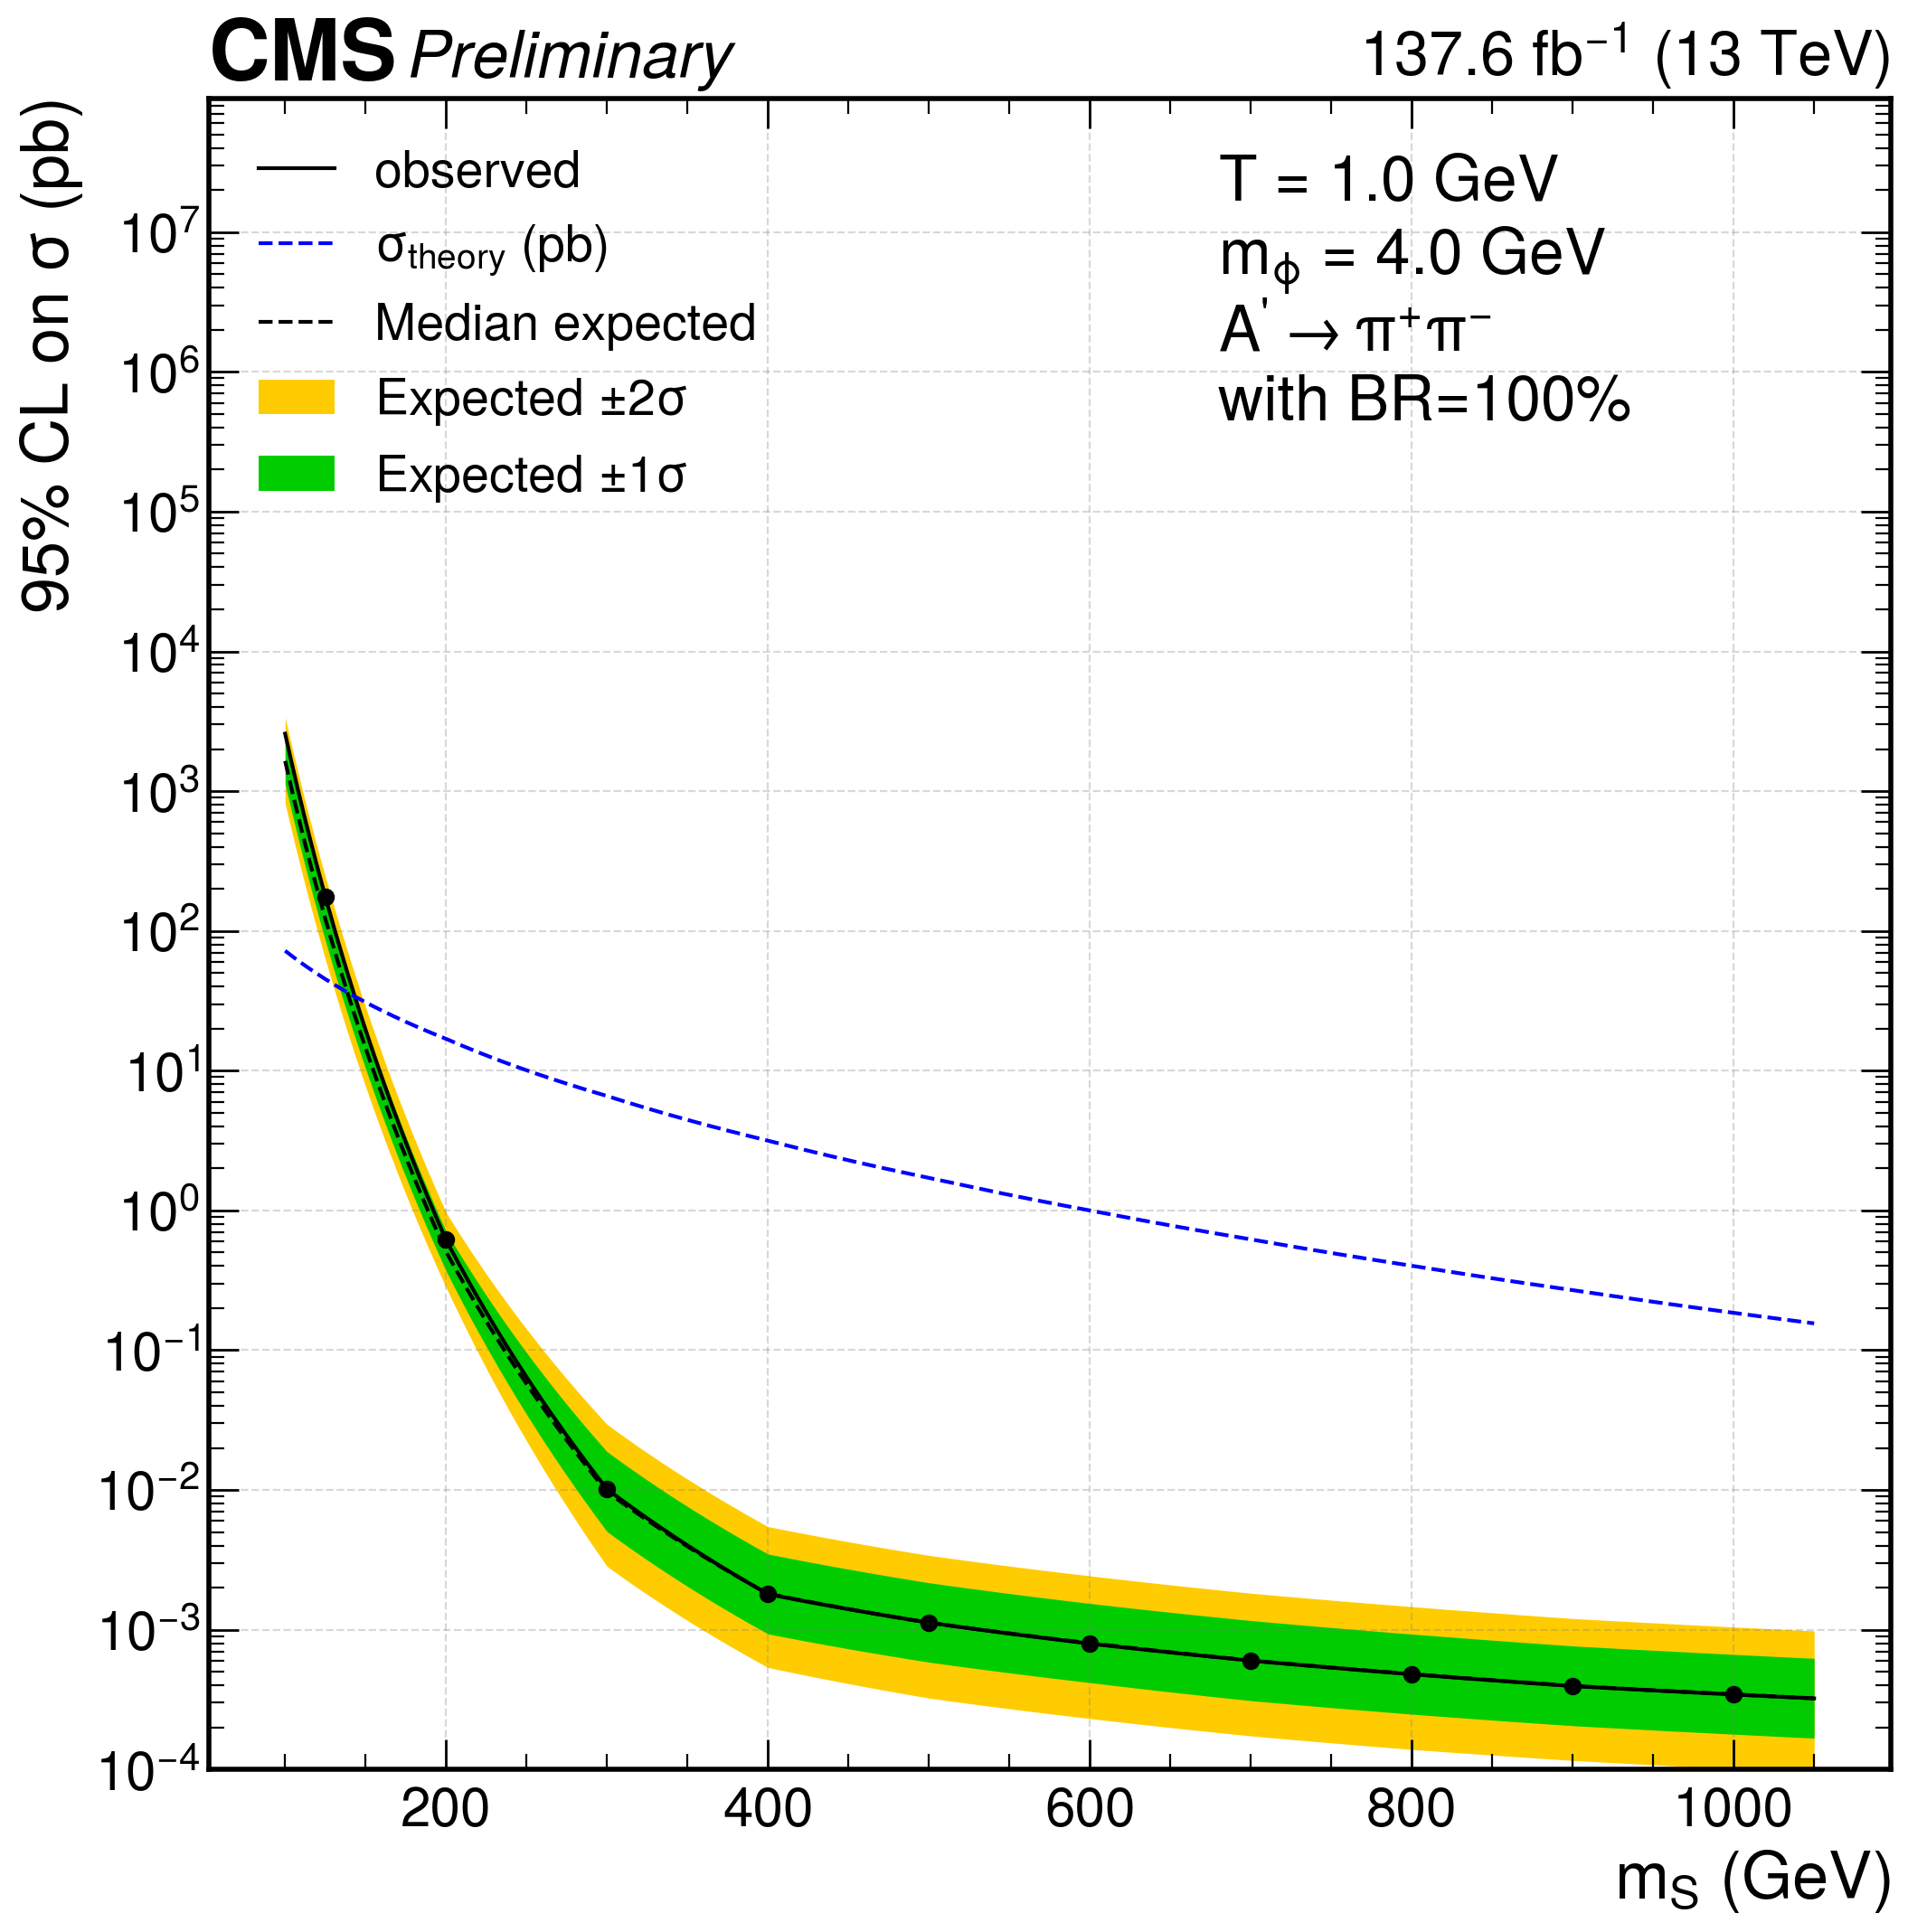

4.0 2.0 generic
[9.14387815e-04 6.01757807e-04 1.80050500e-01 1.86236557e+01
 2.01231010e-03 3.02098242e-04 3.58165337e-04 7.97672246e+02
 1.49467327e-02 4.48013923e-04]
[9.07897949e-04 6.01707458e-04 1.49626465e-01 1.50845703e+01
 1.98303223e-03 3.02047729e-04 3.59153748e-04 1.11305000e+03
 1.31634521e-02 4.47784424e-04]


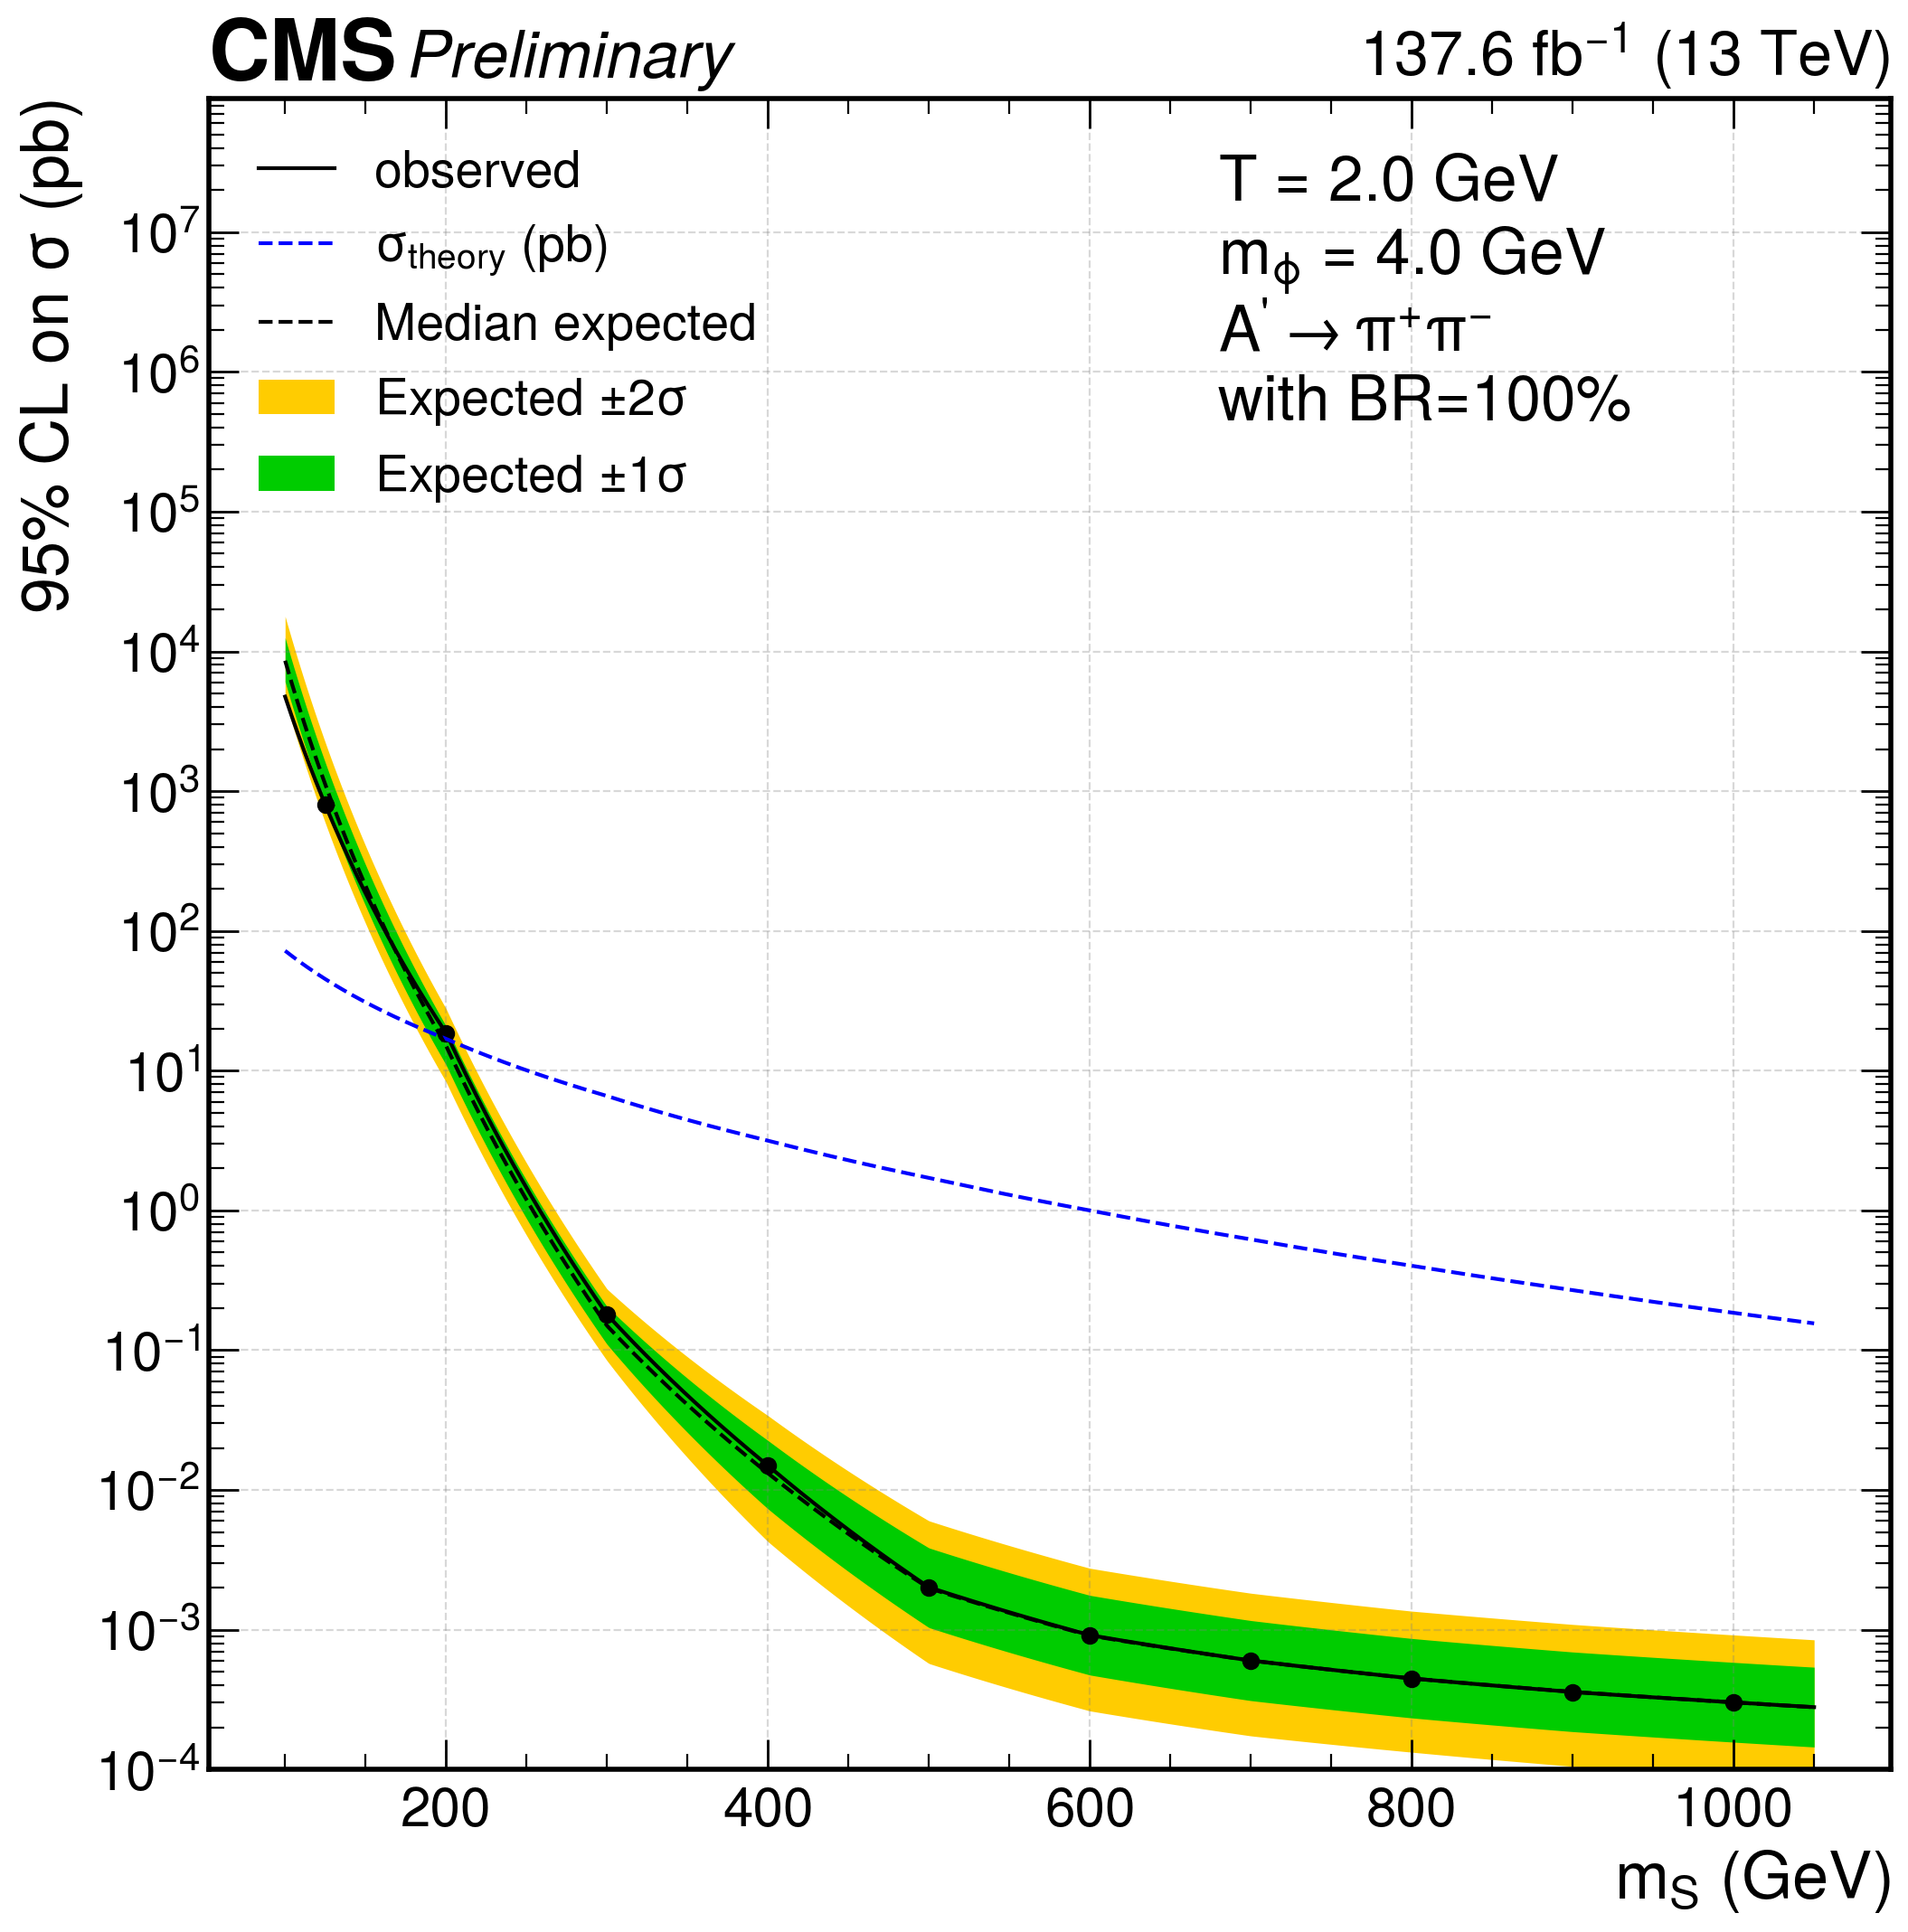

4.0 4.0 generic
[5.58360428e+02 1.36152994e-03 1.23399538e-01 8.24489042e-04
 1.39483186e+00 2.53132643e+01 7.77587353e-03 1.44147007e+04
 2.61793828e-02 2.70265066e-03]
[7.92187500e+02 1.30526733e-03 1.00195312e-01 8.01696777e-04
 1.11093750e+00 1.65264844e+01 6.76565552e-03 2.54476000e+04
 2.16674805e-02 2.51495361e-03]


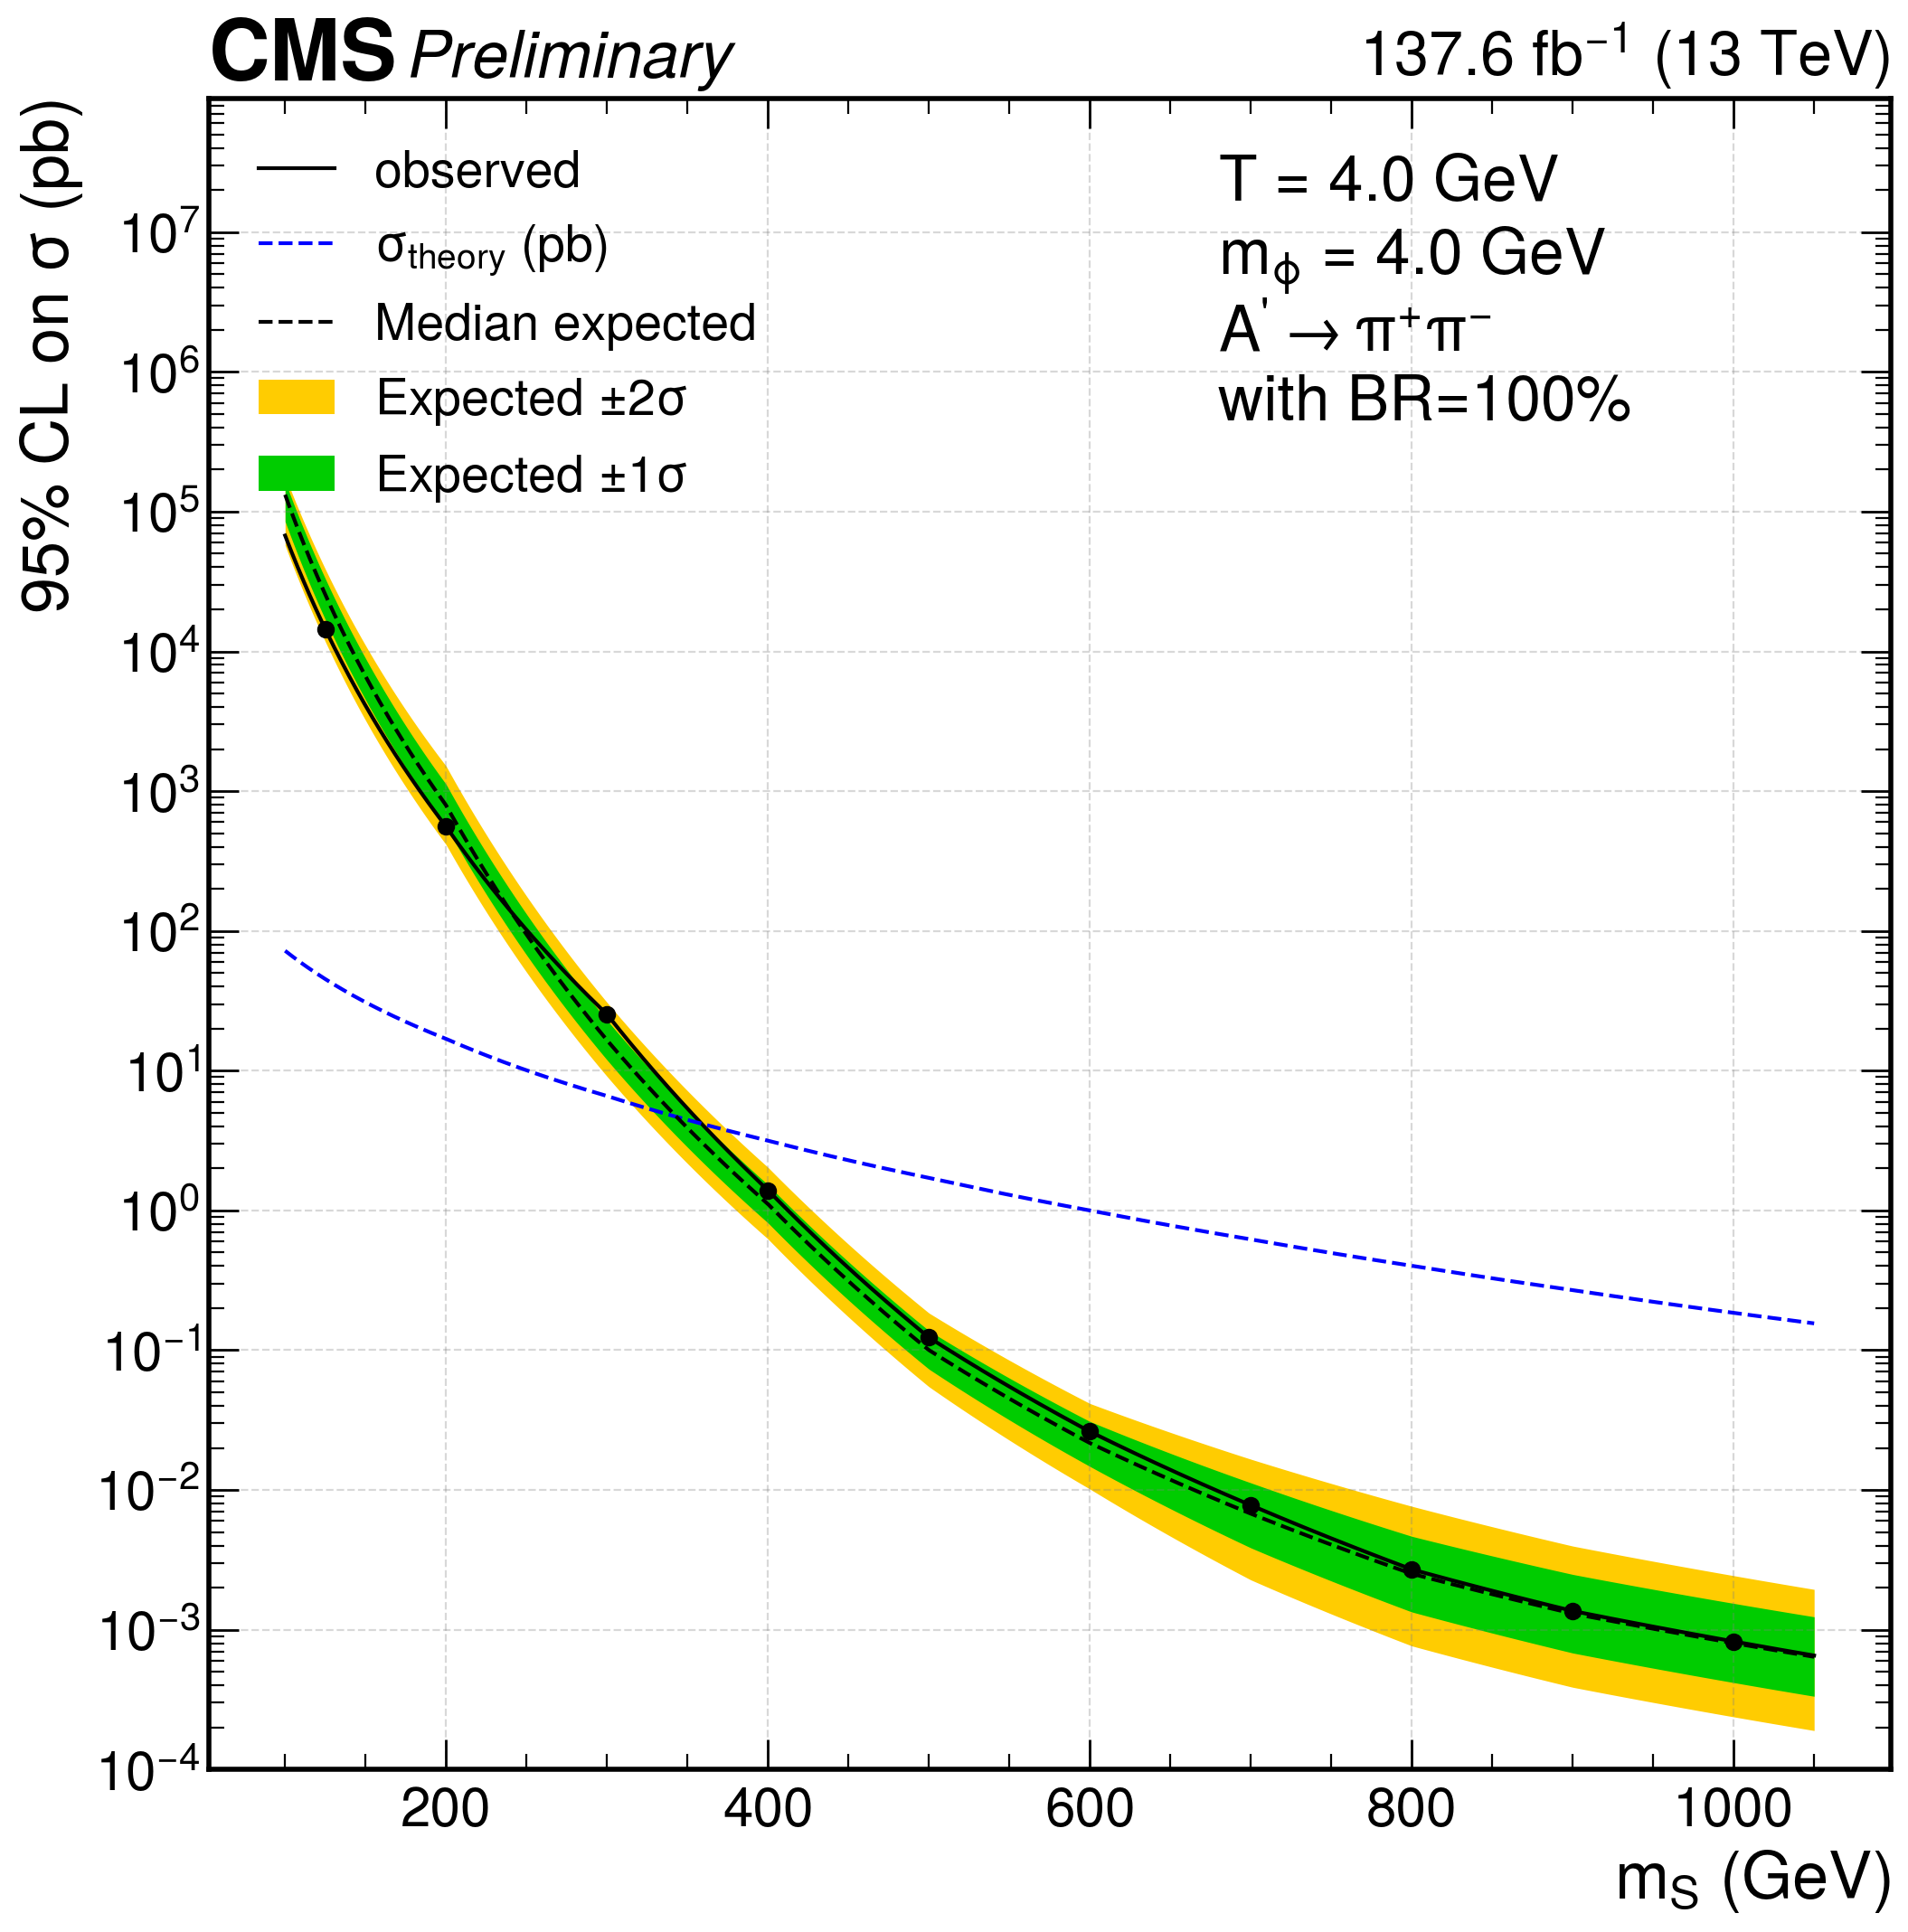

4.0 8.0 generic
[2.56280046e-01 8.64690637e+01 8.42263340e-01 5.21441991e+01
 3.77535836e+03 2.66989218e+00 1.13025066e-01 6.27107395e+02
 9.80714220e+00 1.68647176e+04]
[2.06478516e-01 6.83350000e+01 6.48539063e-01 3.90093750e+01
 7.02195000e+03 2.07161719e+00 9.05126953e-02 8.81412500e+02
 7.48437500e+00 1.37408000e+04]


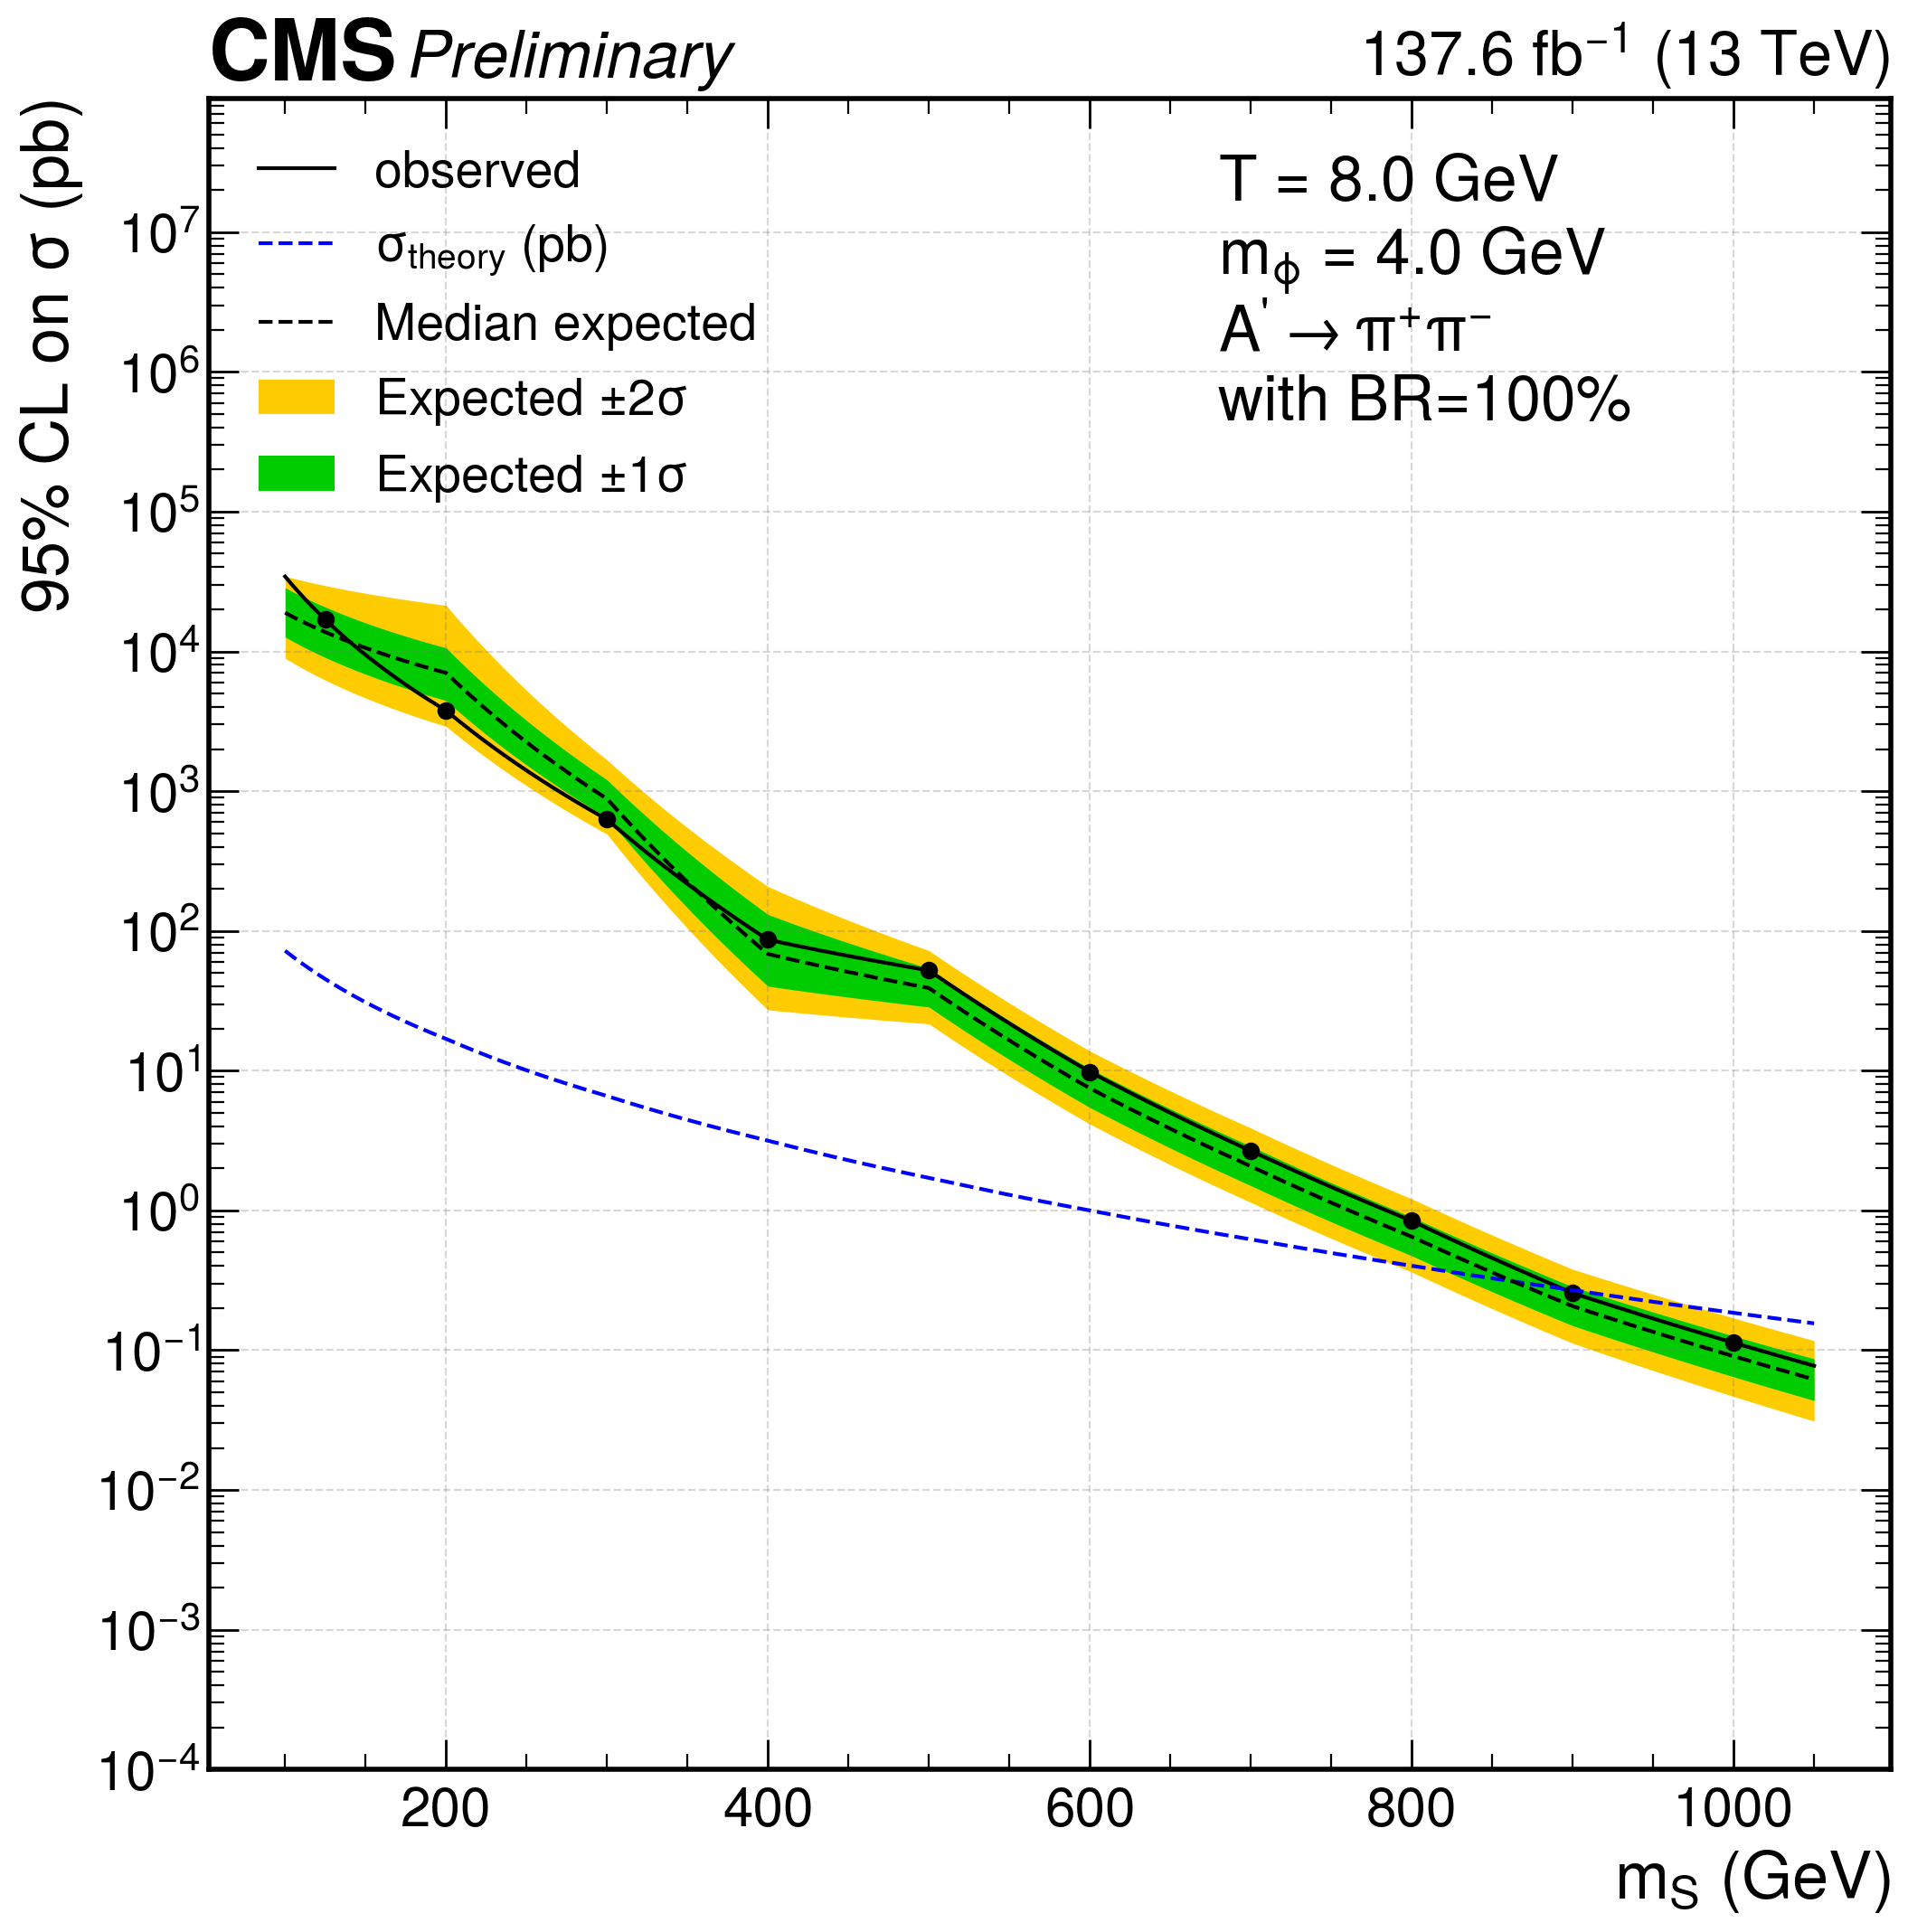

4.0 16.0 generic
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi4.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
[  244.36436658   352.87716959   665.71865812   240.4384672
  1912.36725916 39745.37135487    93.05578234  1203.62358351
  1718.80210967]
[  334.665    466.6815   895.5      235.135   1416.85   42554.2
   111.5005  1268.74    1972.485 ]


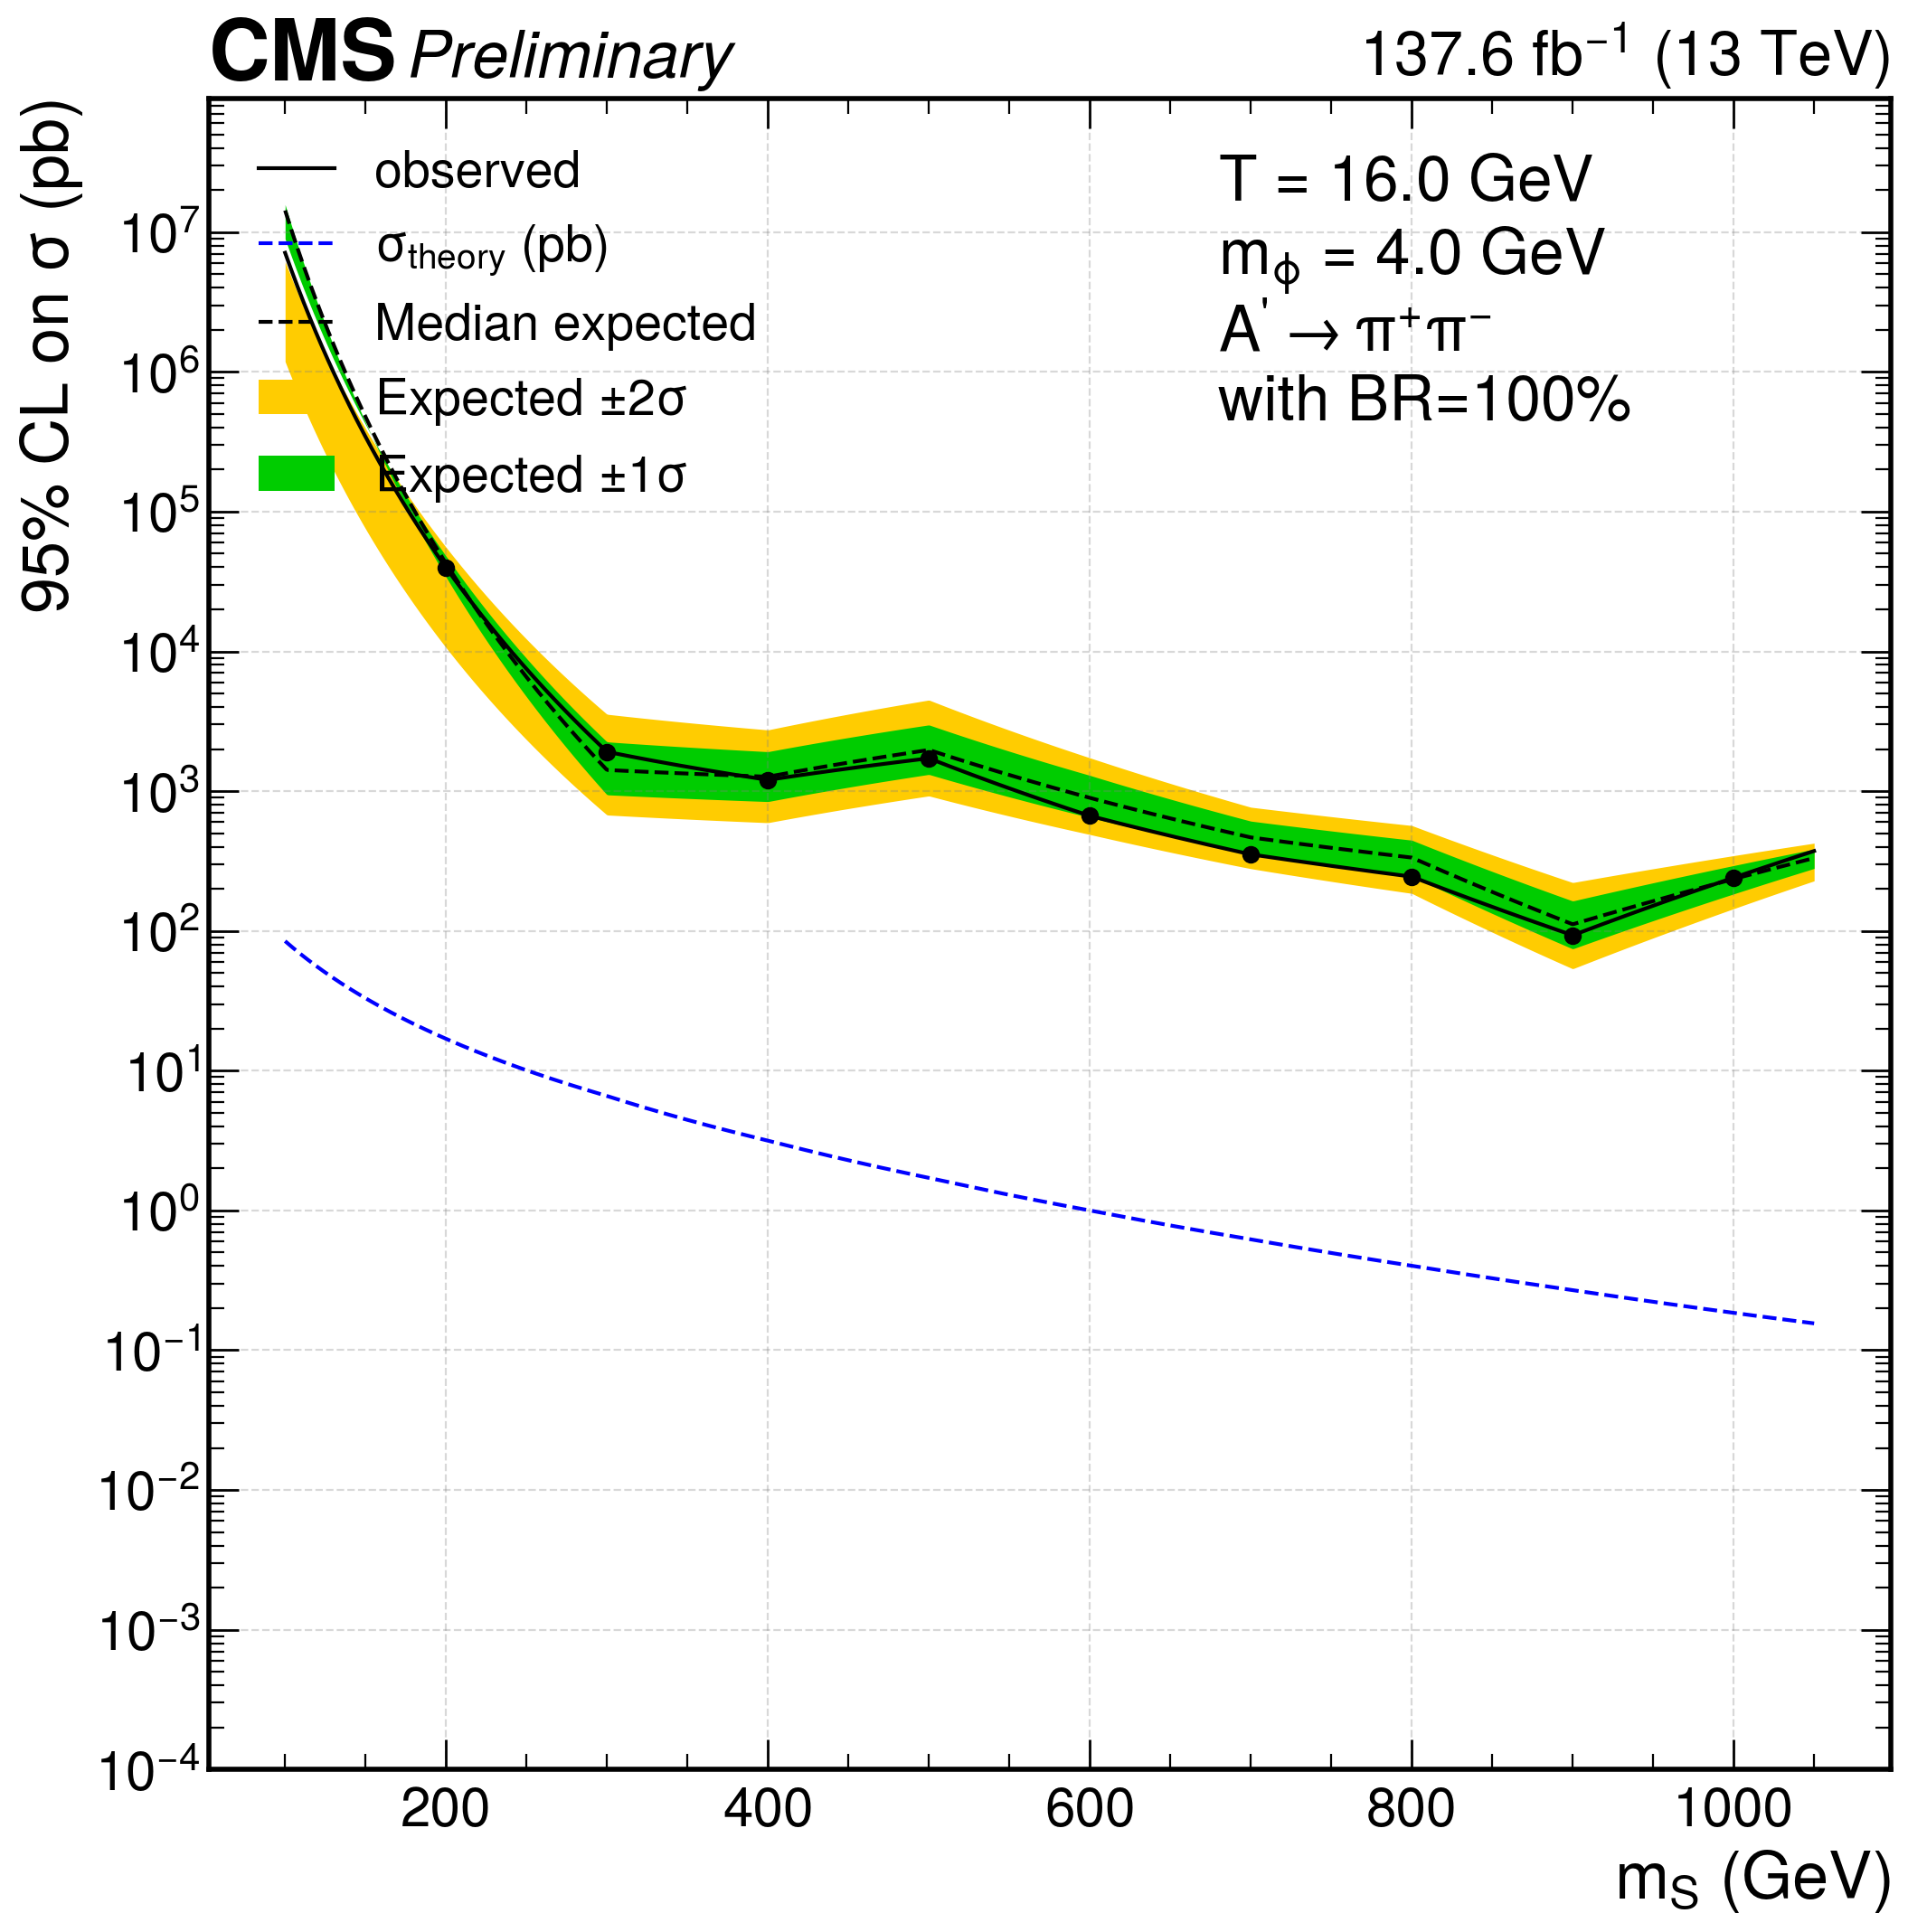

8.0 2.0 generic
[7.73920104e+03 8.66717948e+02 7.71448105e-04 3.23669092e-02
 3.15500951e-01 3.31017071e-04 7.01356613e-03 4.59165612e-04
 8.21588221e+00 1.73627380e-03]
[1.13339000e+04 1.38791250e+03 7.63687134e-04 2.69796753e-02
 2.63847656e-01 3.30276489e-04 6.16455078e-03 4.55612183e-04
 6.17812500e+00 1.67720032e-03]


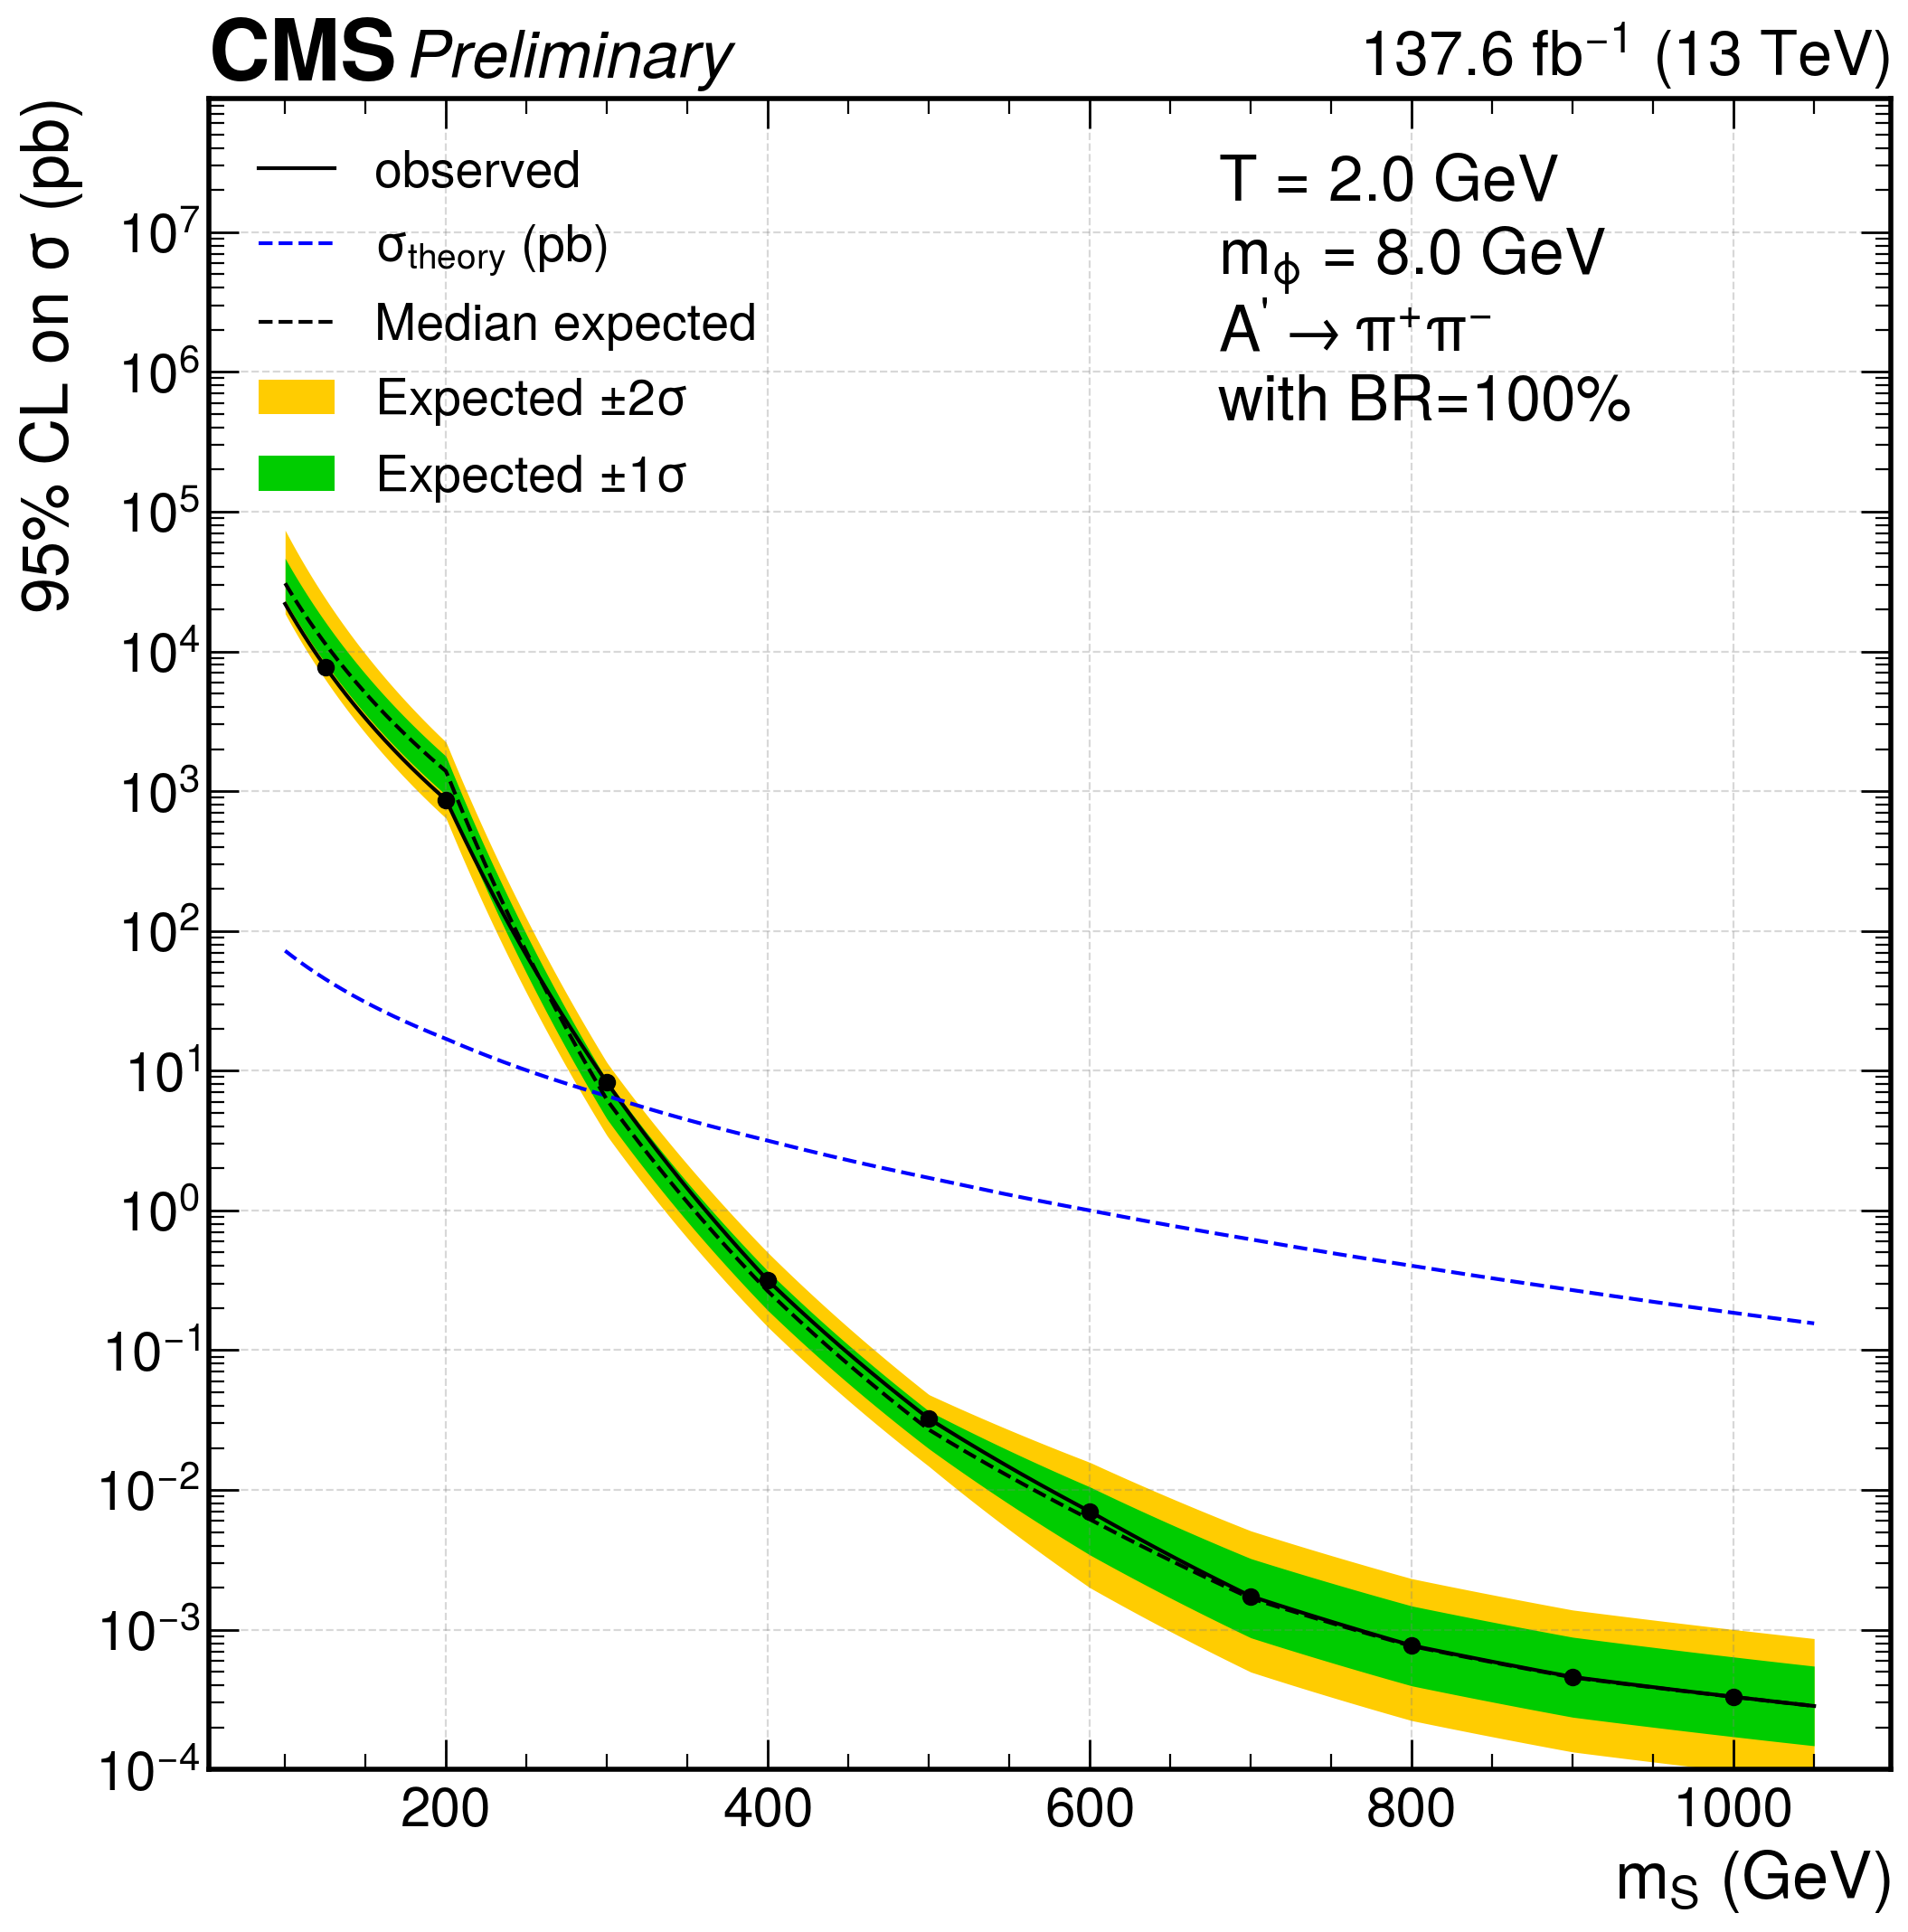

8.0 4.0 generic
[7.71109791e+02 1.32082217e-02 2.71689656e-03 1.09417235e+01
 3.78065809e-02 2.17463660e+02 1.51302058e-01 2.08300043e+04
 1.08835681e+00 5.45560718e-03]
[1.11751250e+03 1.07958984e-02 2.45025635e-03 7.50500000e+00
 3.11561279e-02 1.64750000e+02 1.23535156e-01 1.60008000e+04
 8.53330078e-01 4.71209717e-03]


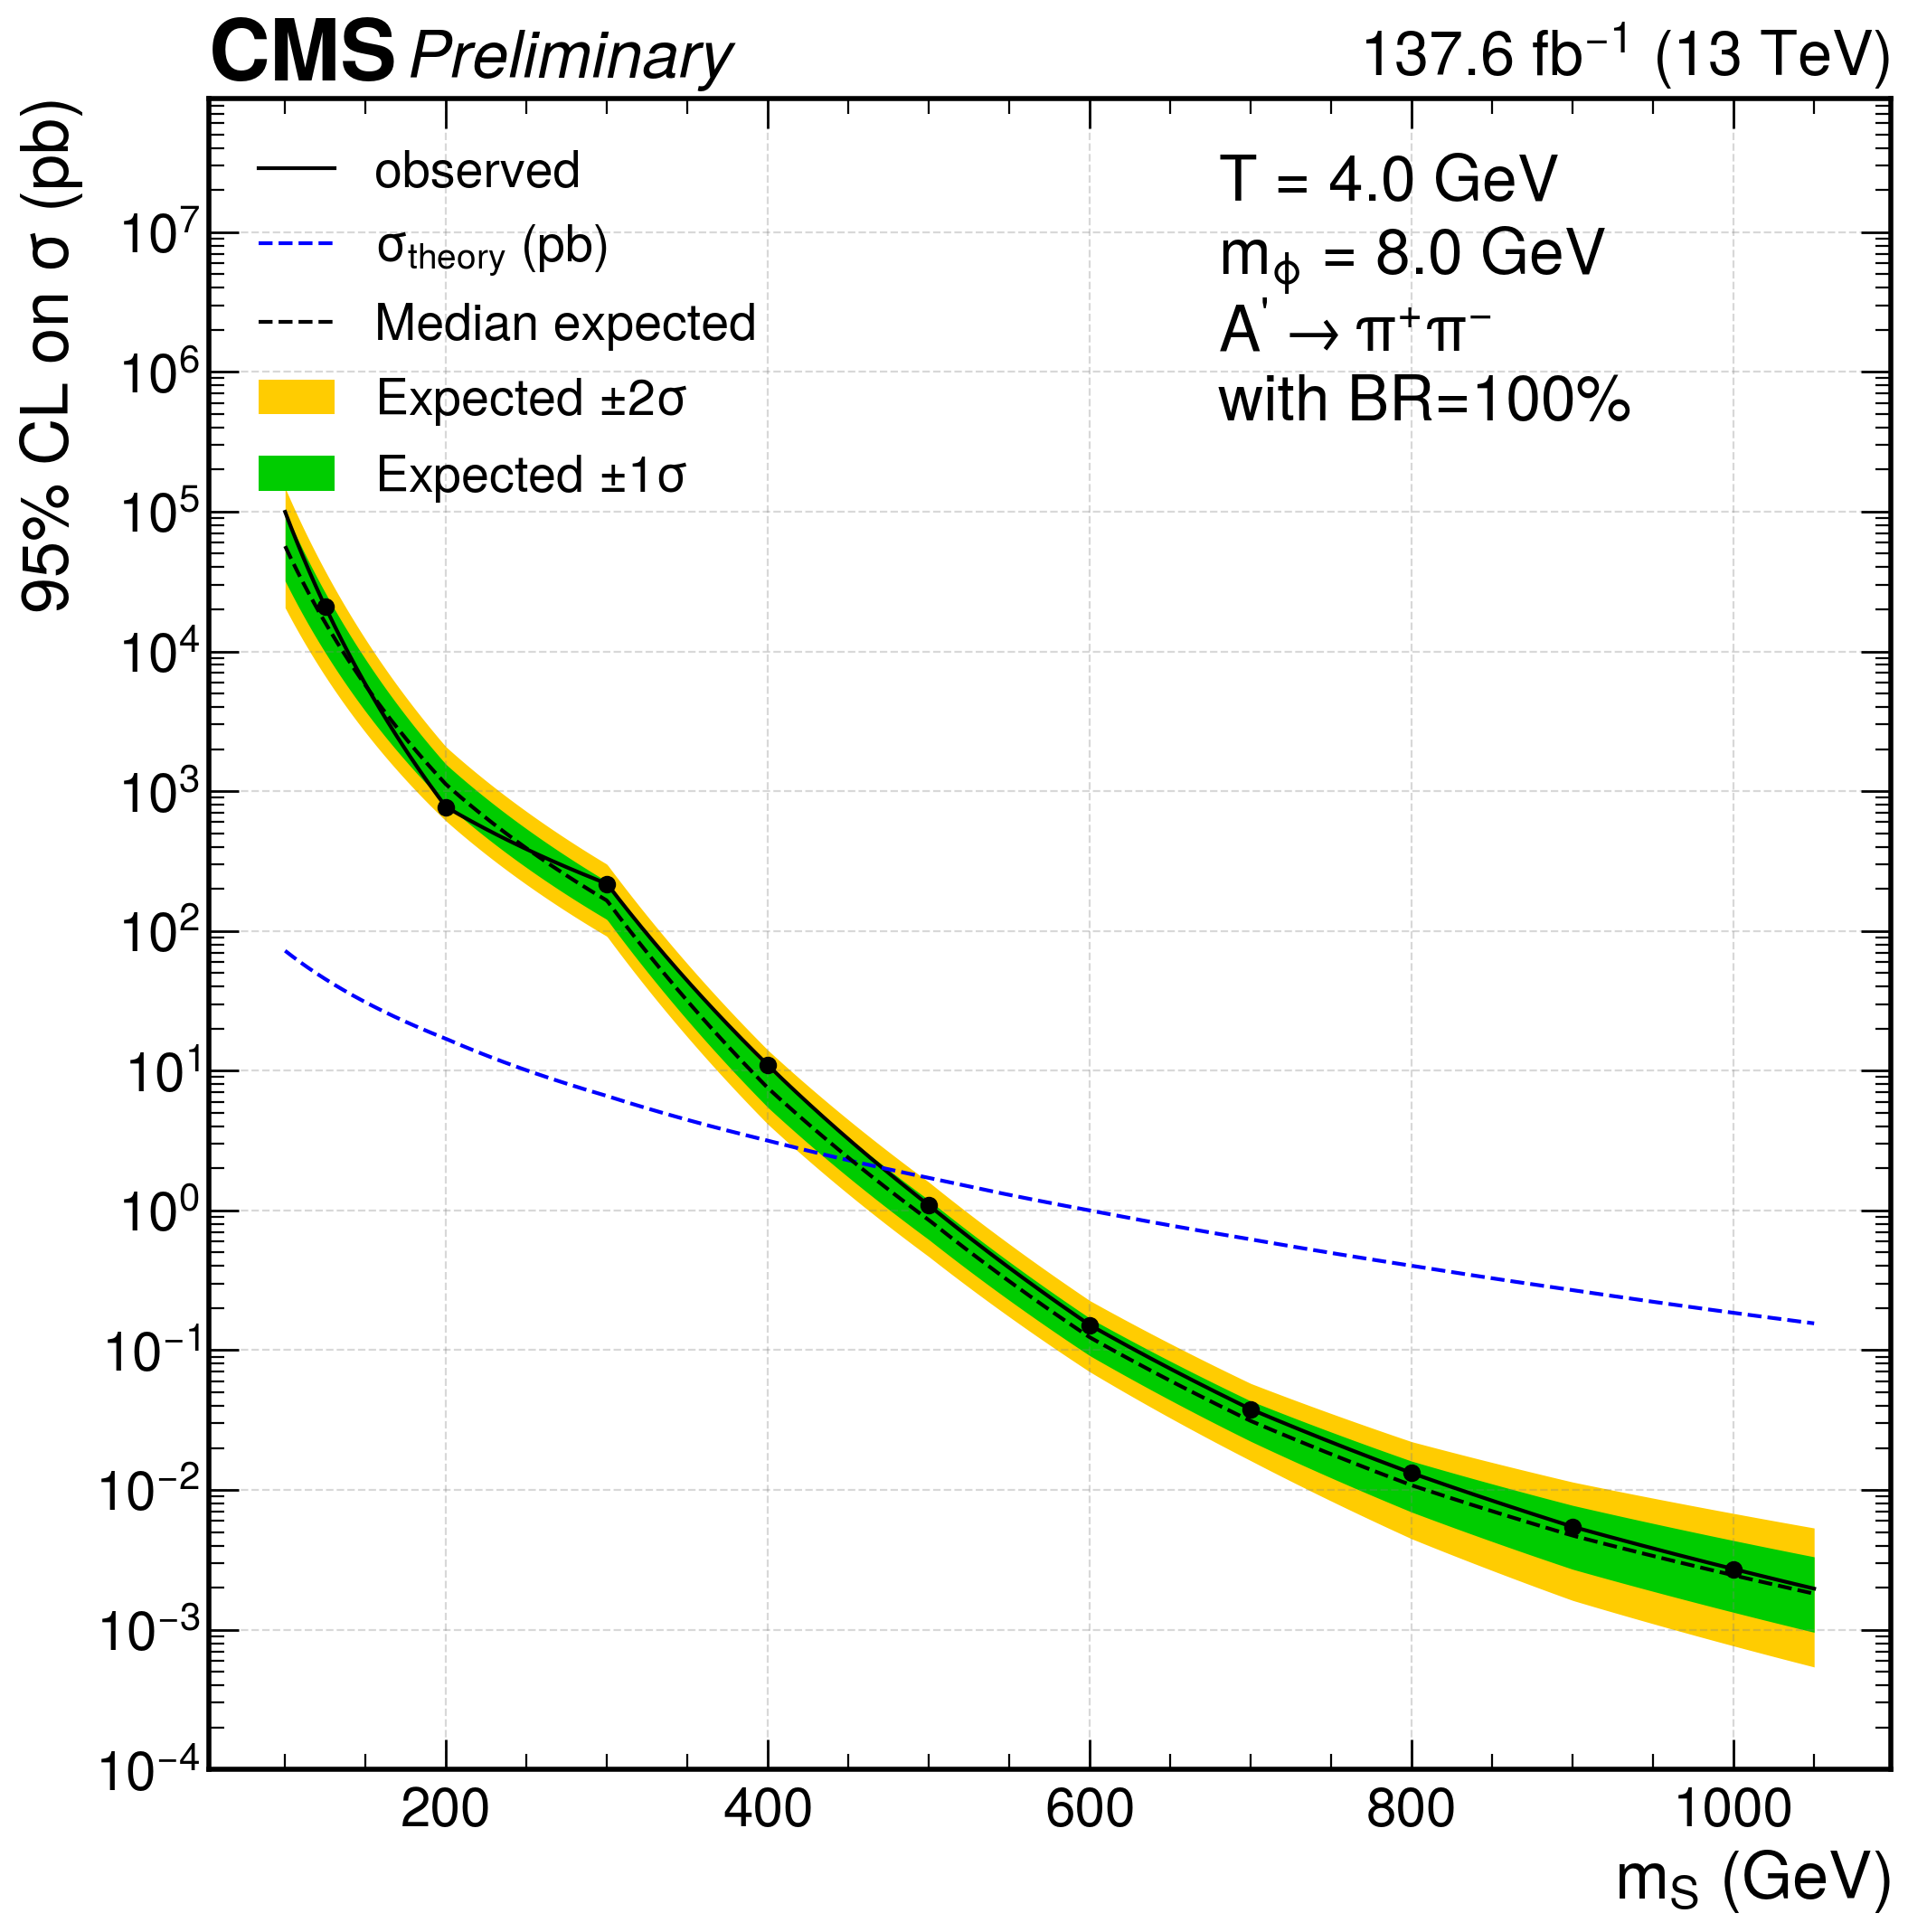

8.0 8.0 generic
[2.11228144e+02 2.38004583e+01 1.89107279e+00 6.82320783e+00
 2.60996312e-01 1.22619801e+03 7.37593059e-01 6.33227359e+03
 1.77810883e+02 7.78783220e+03]
[2.99410000e+02 1.65000000e+01 1.39129688e+00 4.63809375e+00
 2.10654297e-01 1.68045000e+03 5.59015625e-01 4.56722500e+03
 1.36158750e+02 8.50890000e+03]


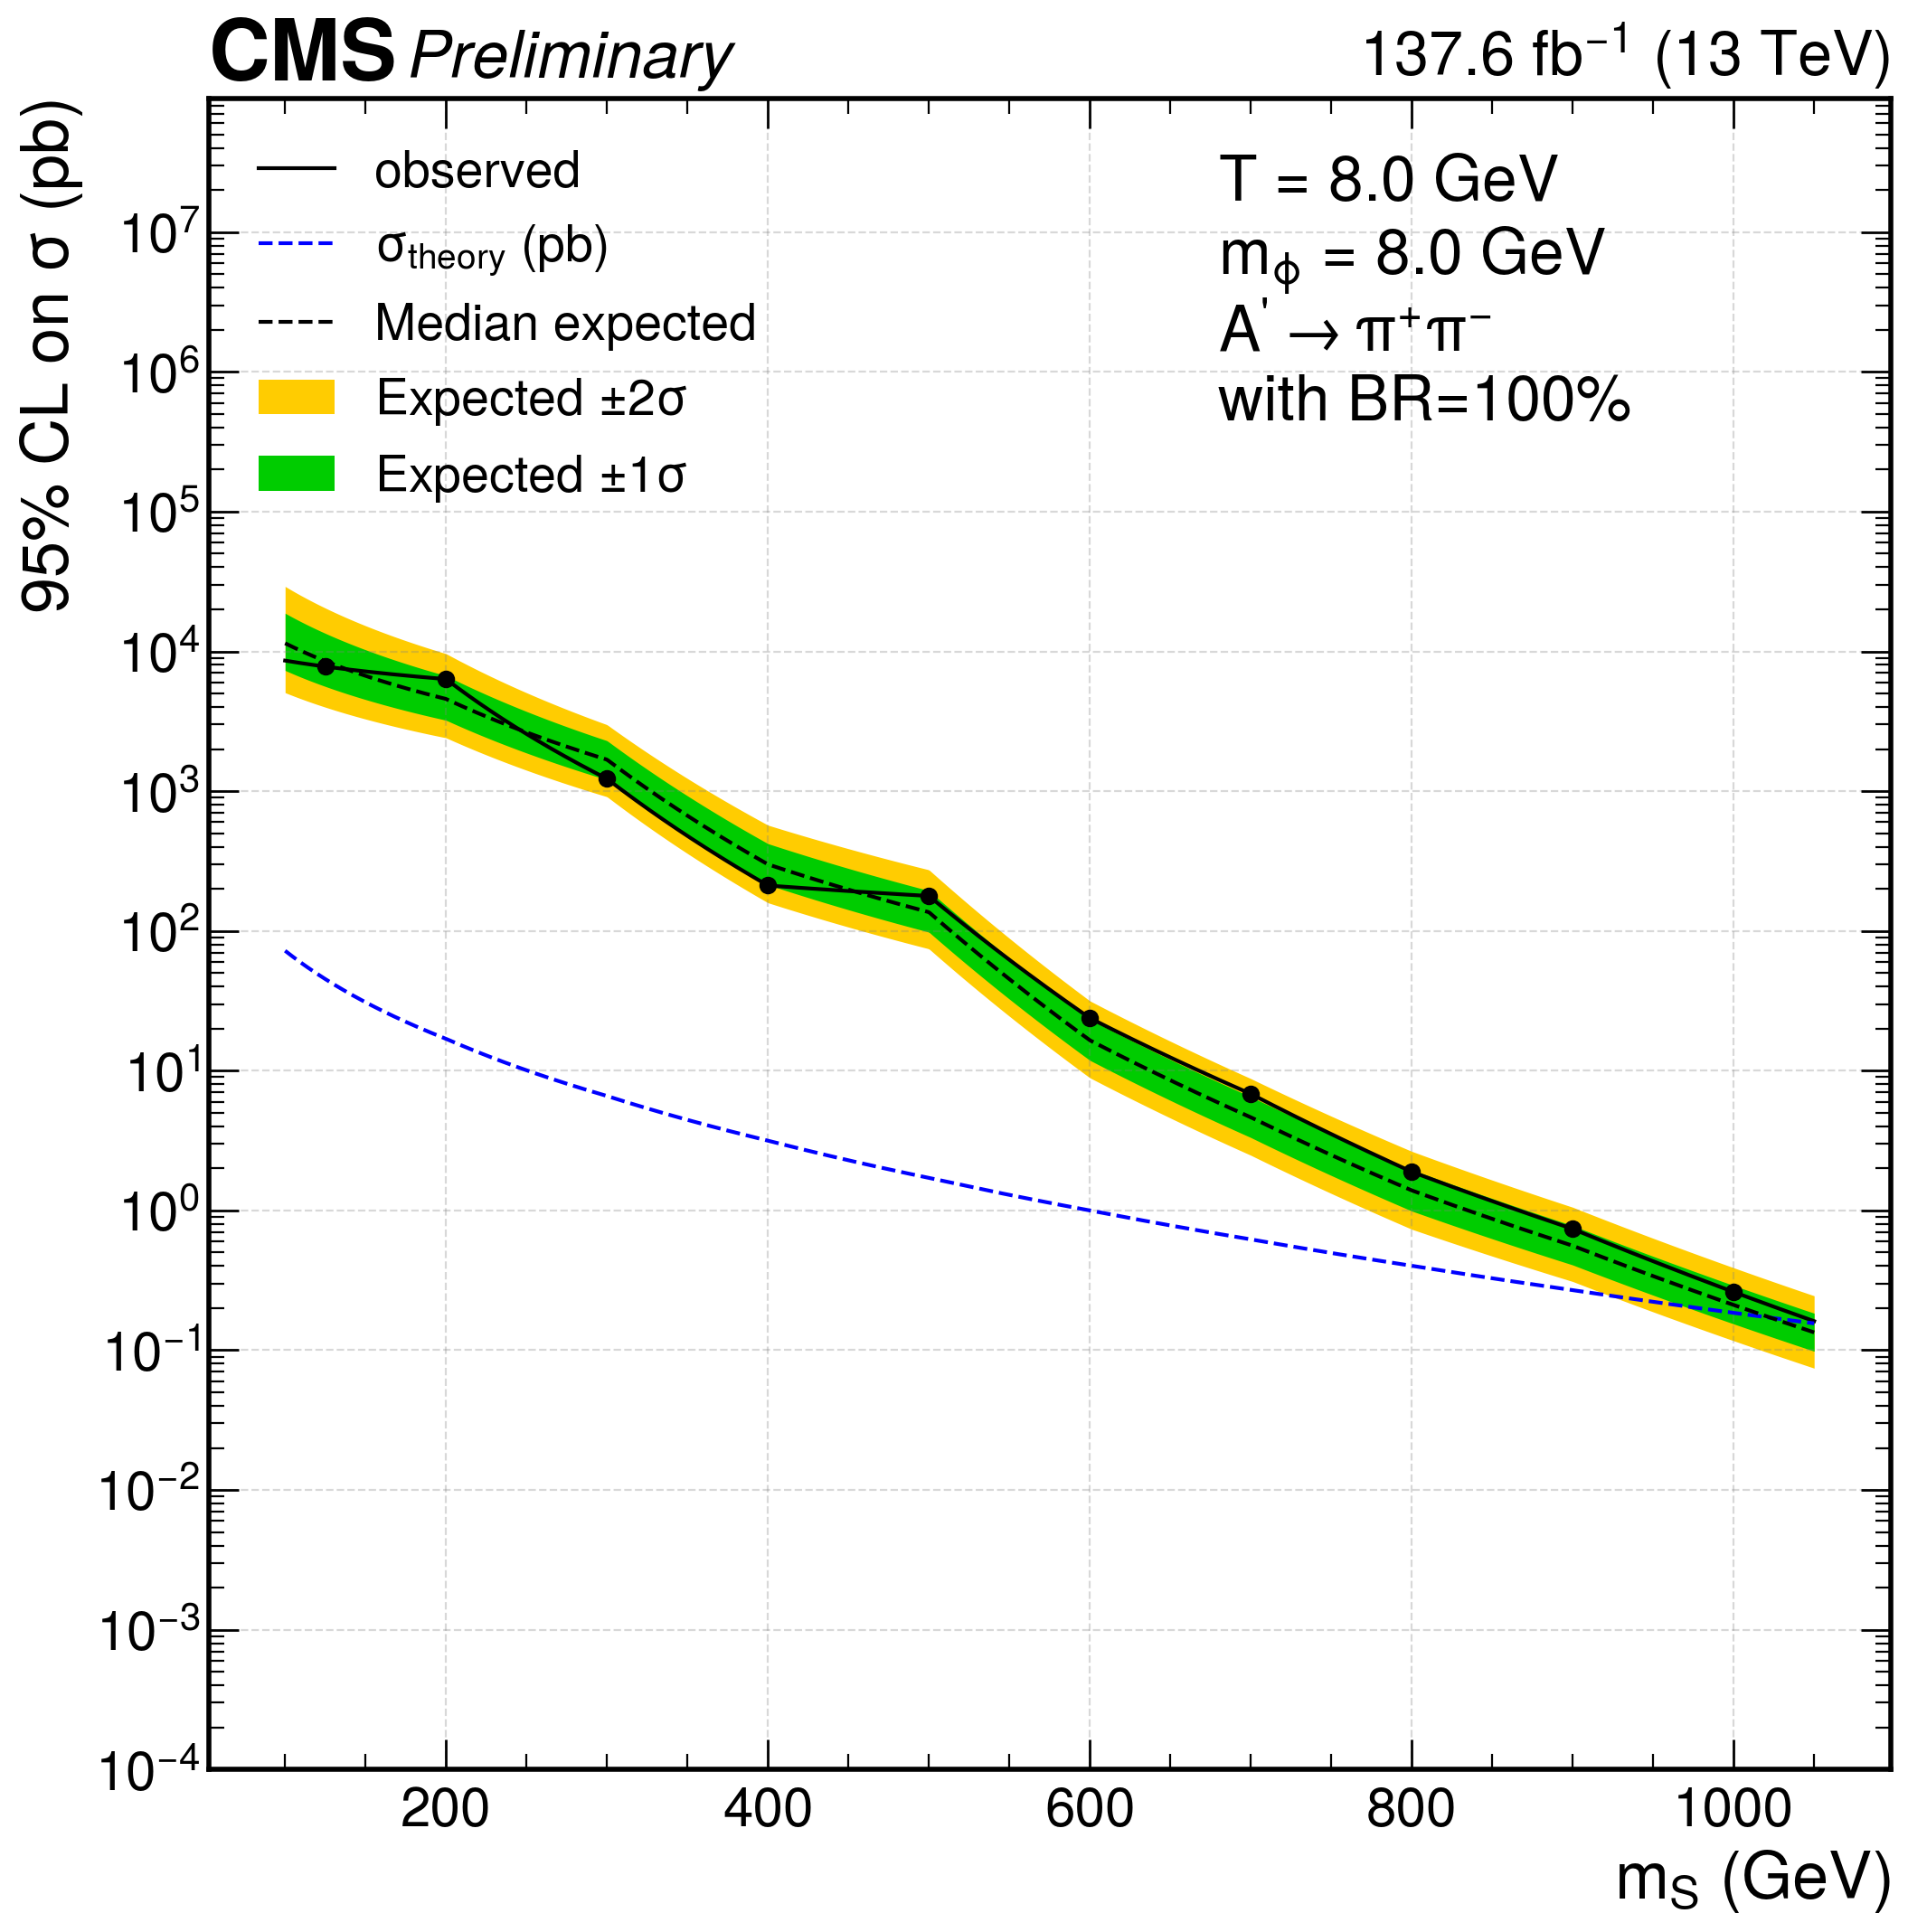

8.0 16.0 generic
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T16p0_mS125.000_mPhi8.000_T16.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
[4462.41636414  162.98913788  176.07792687 3865.10162374   65.69035436
 1419.26014156 1938.42457534  341.25952994  160.5722962 ]
[7148.7     205.1125  252.     3993.54     93.795  3341.7    2880.495
  461.0925  225.522 ]


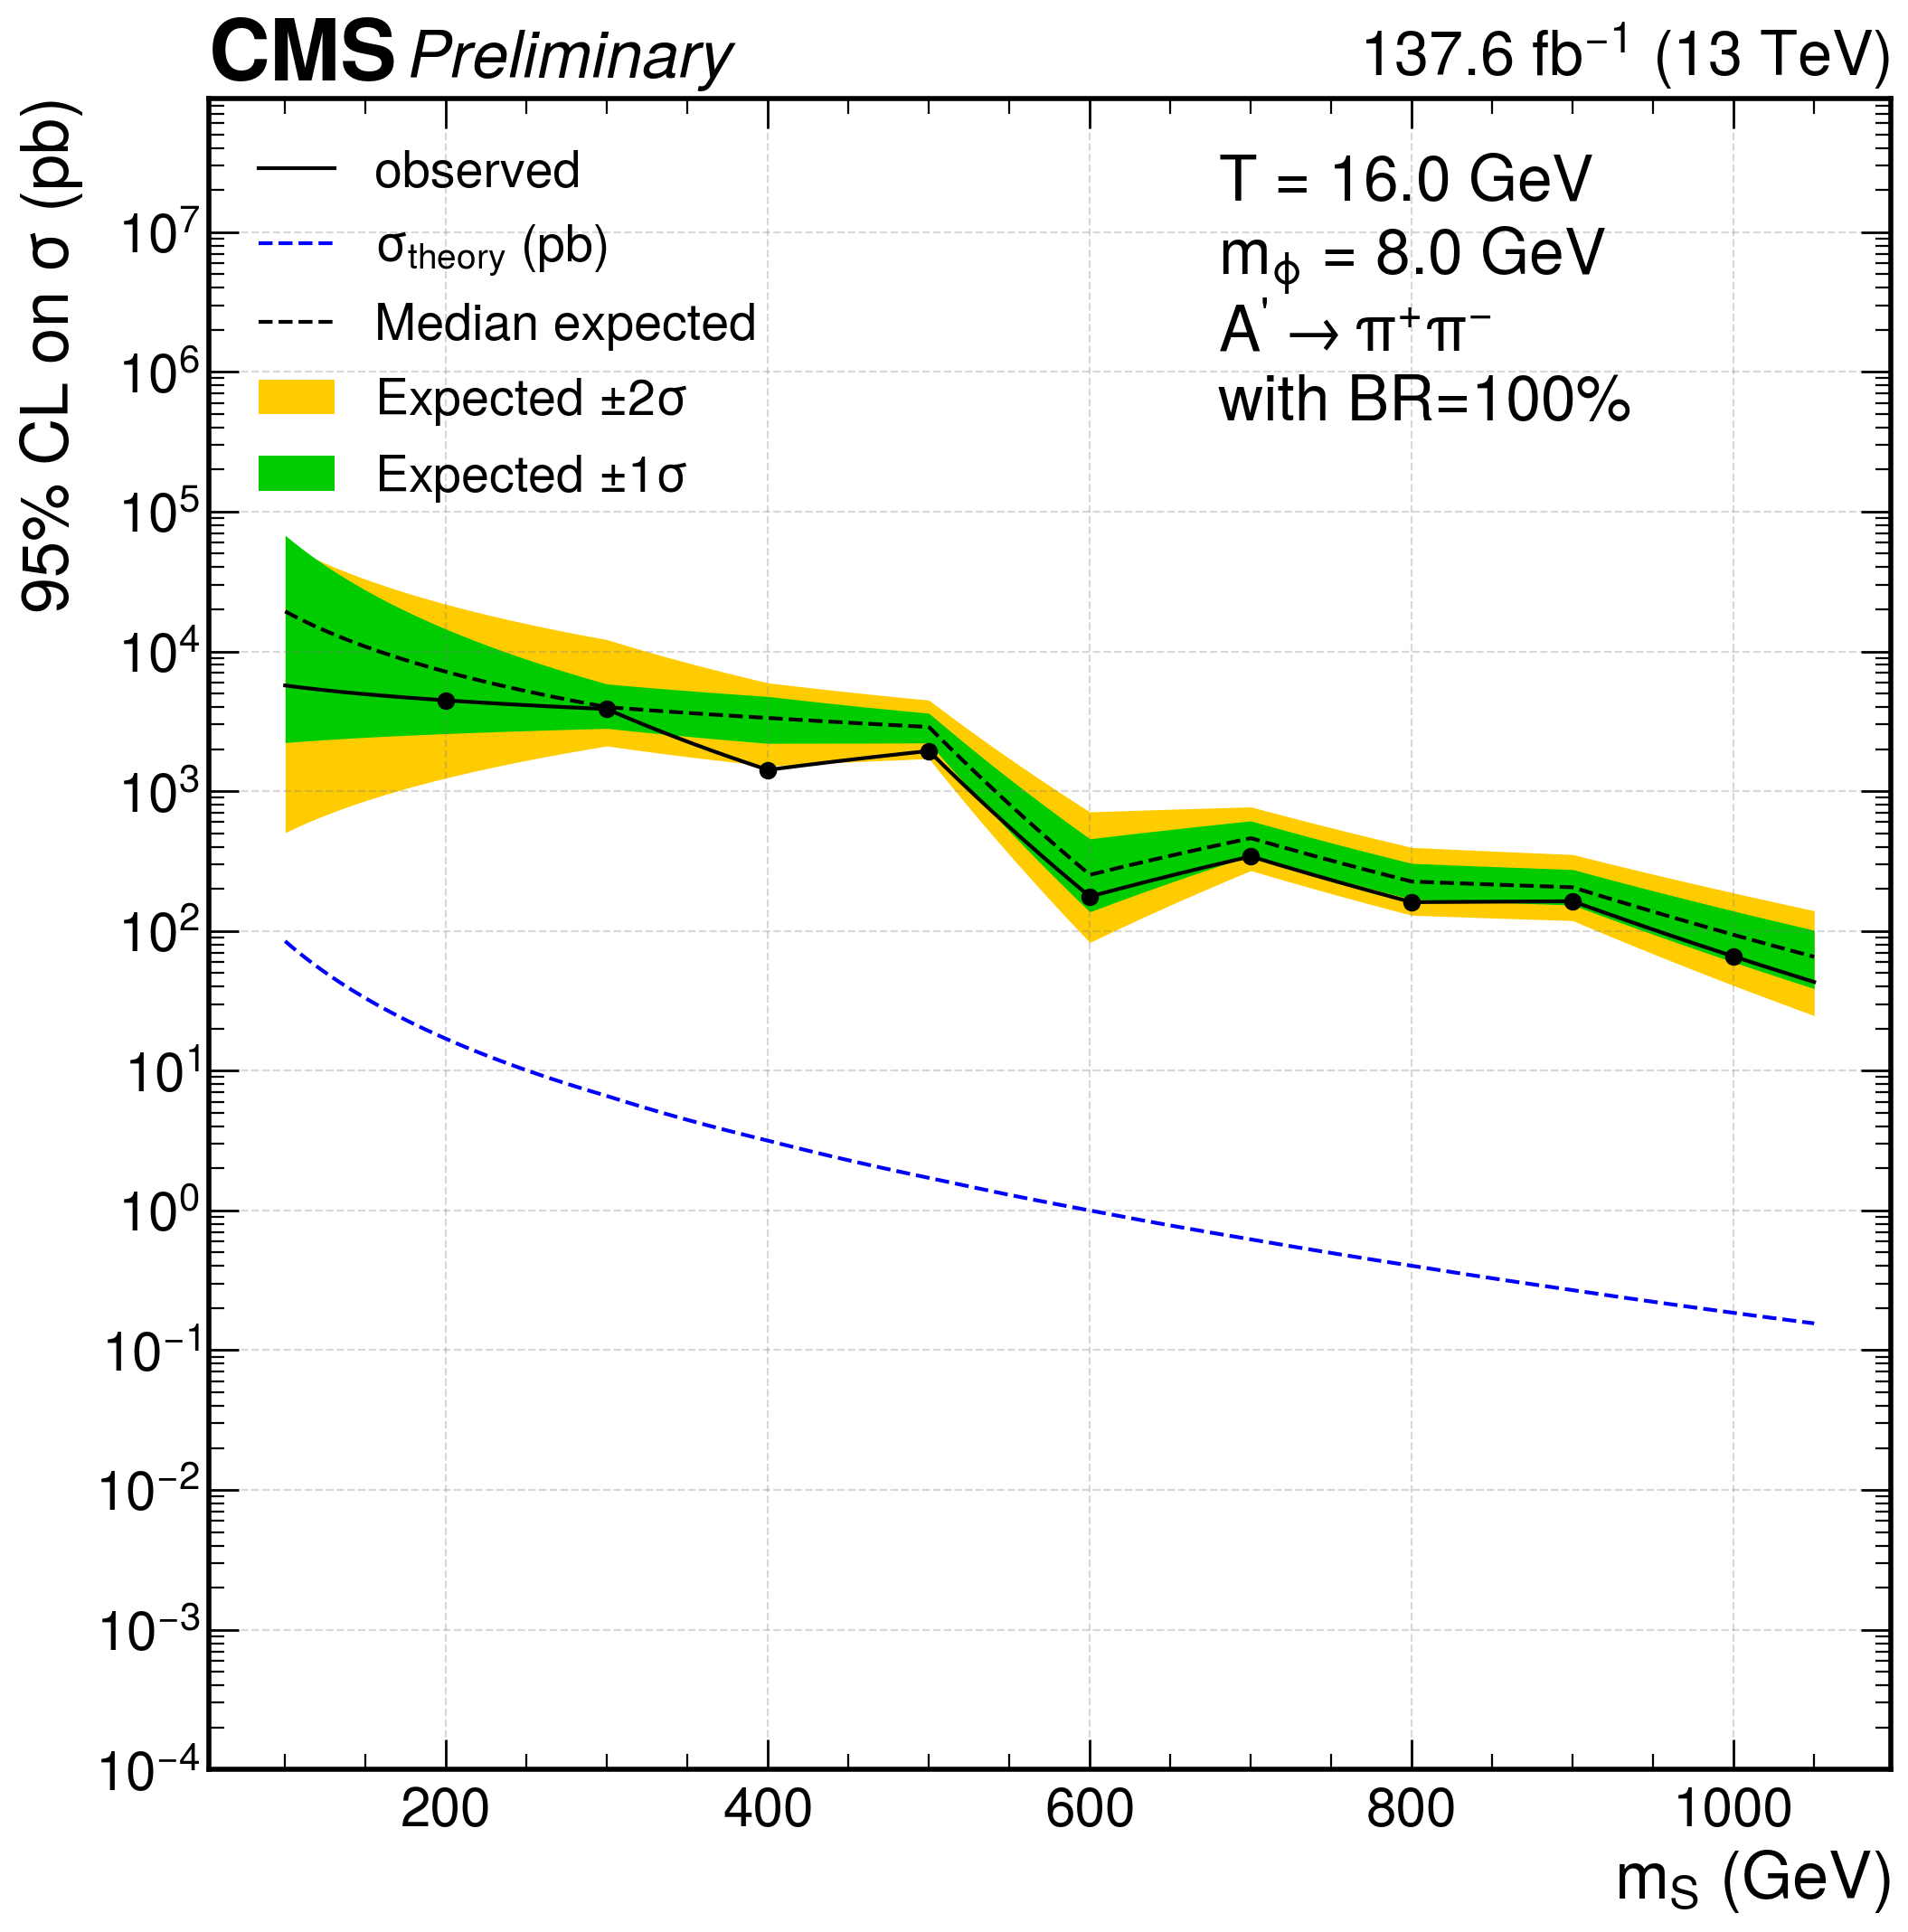

8.0 32.0 generic
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T32p0_mS200.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
Missing limits;  ../higgsCombineGluGluToSUEP_HT1000_T32p0_mS125.000_mPhi8.000_T32.000_modegeneric_TuneCP5_13TeV-pythia8.AsymptoticLimits.mH125.root
[  509.68437078 10548.69914875  2125.10072154  2335.82745807
 10459.25467886  3863.10557816  9564.47403902   708.84855755]
[  701.73   9141.88   1690.335  2125.638 12313.71   3558.504  9187.
  1058.57 ]


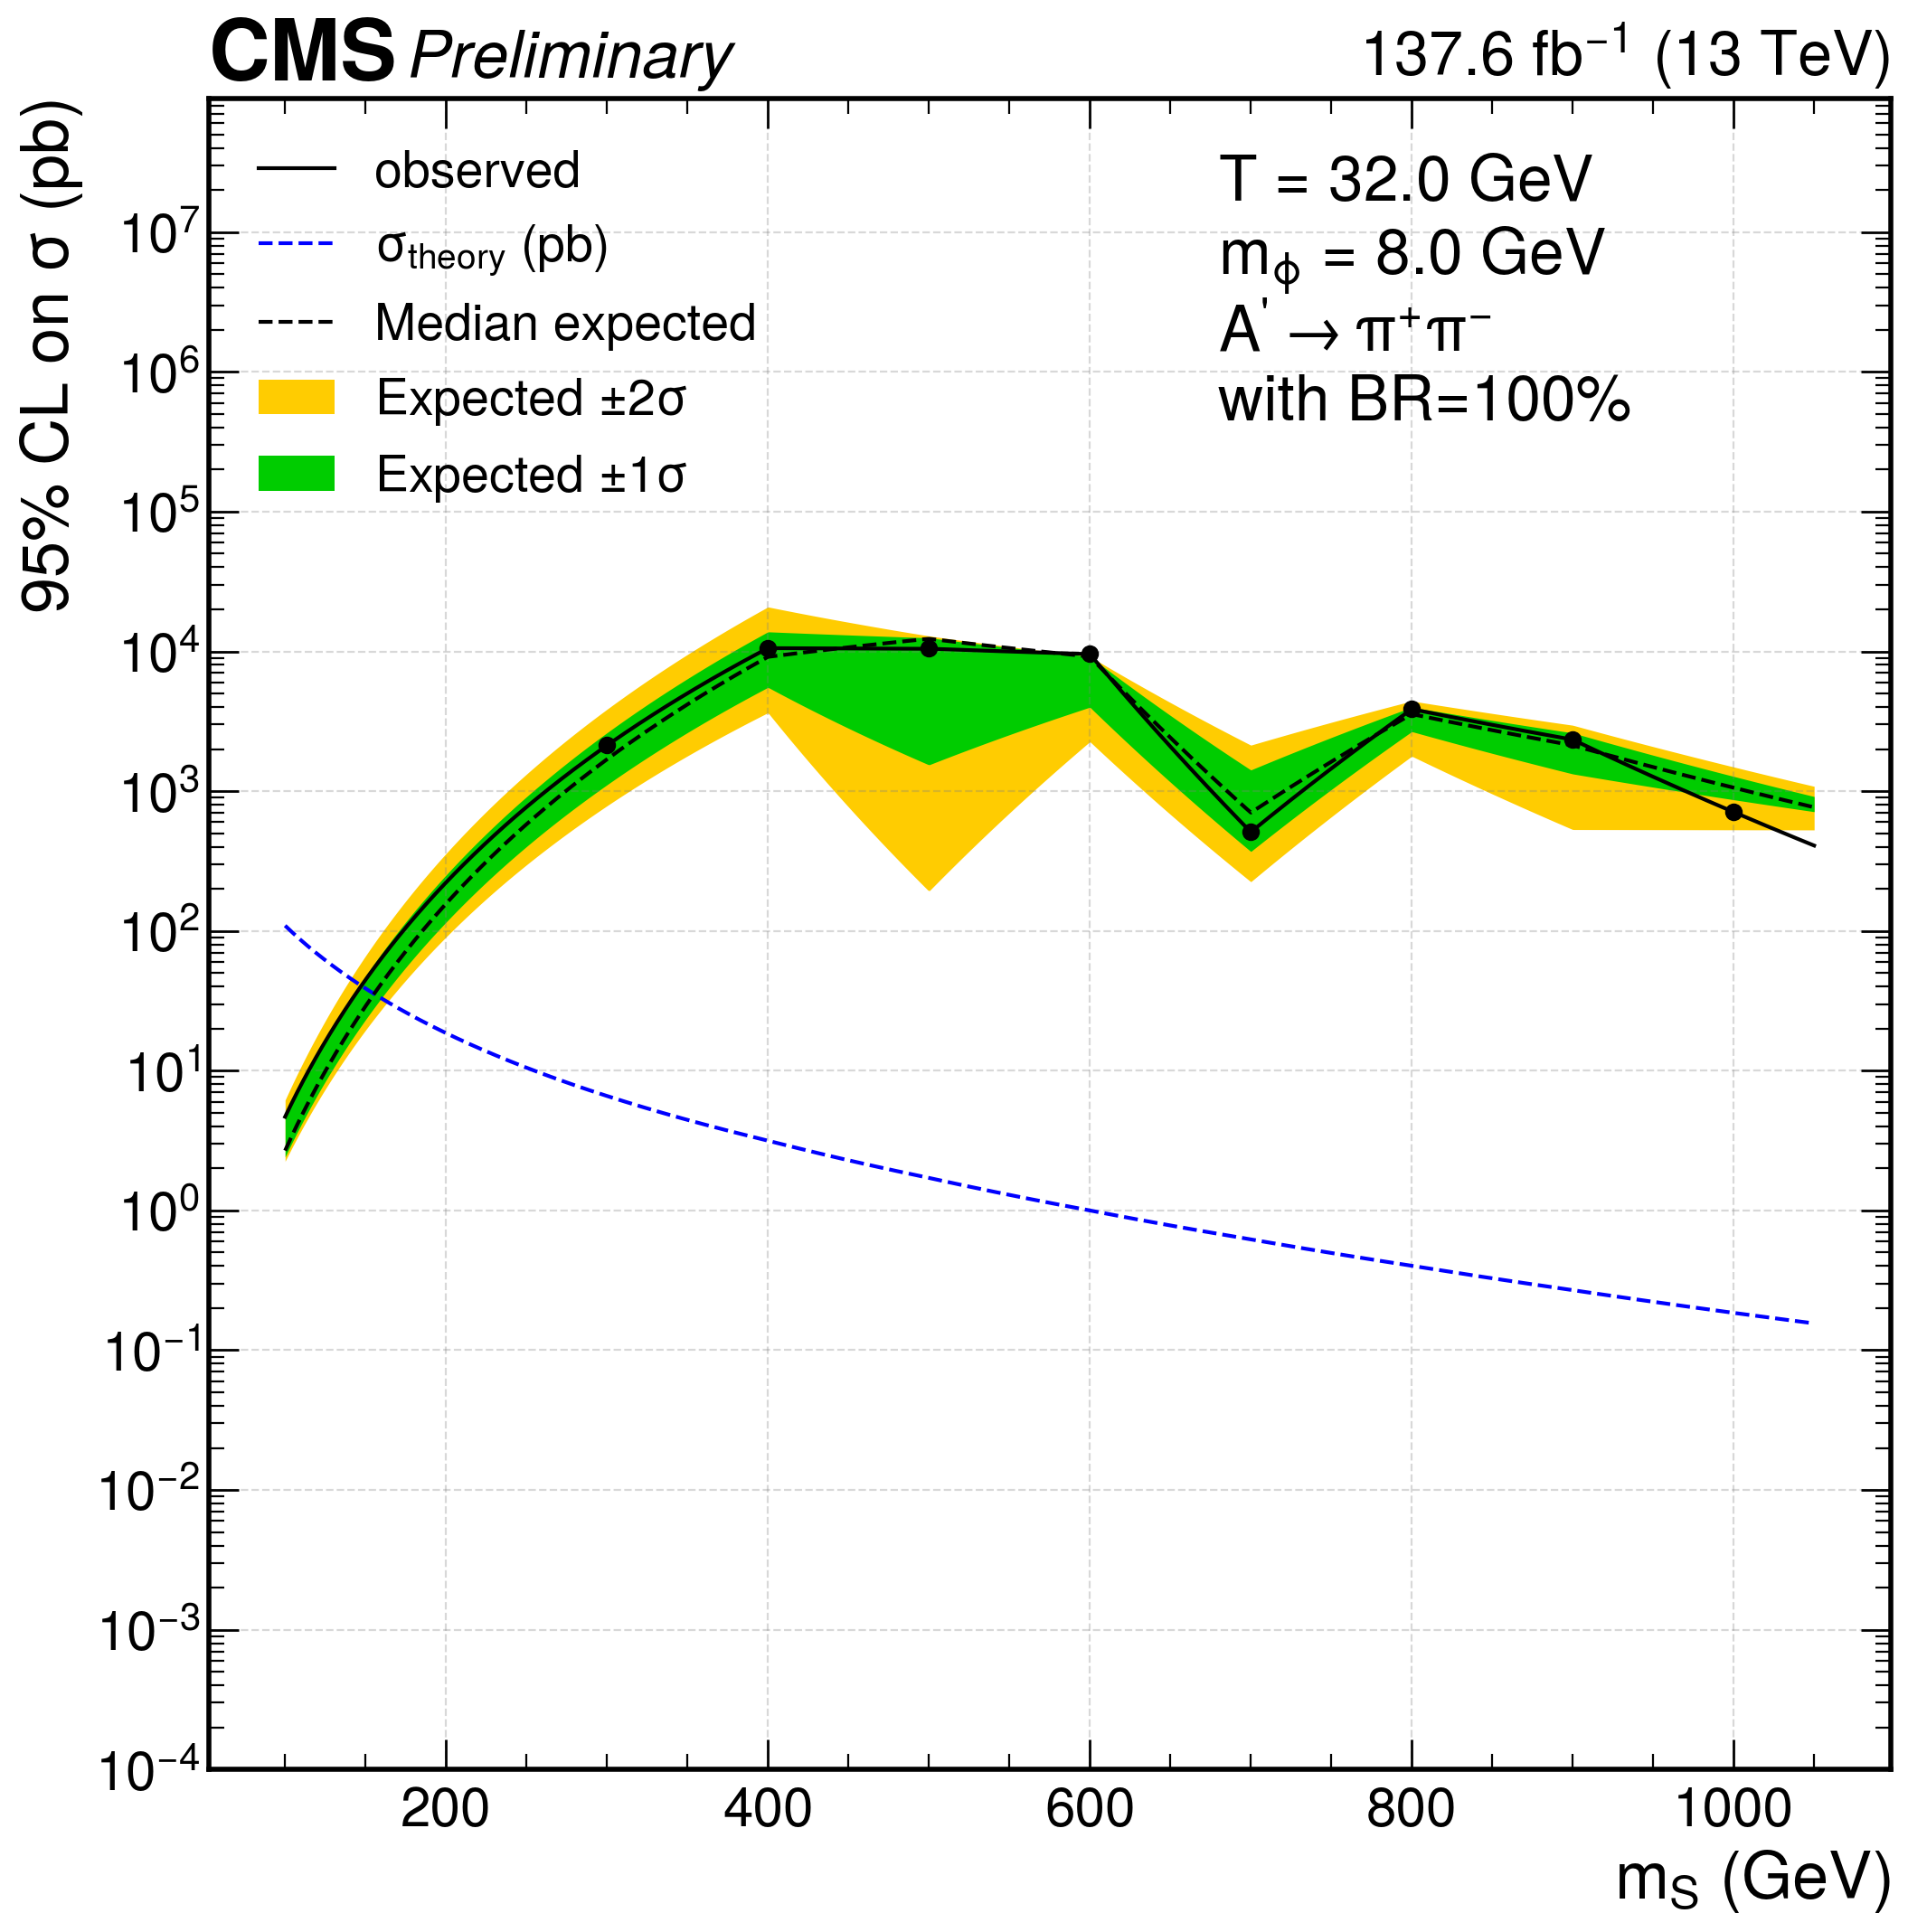

In [22]:
# Run over all phase space points, and all 3 decay modes

for (mdark,T) in tuples:

    for decay in ['generic']:
        if mdark ==1 and decay != 'leptonic': continue # leptonic
        if mdark ==1.4 and decay != 'hadronic': continue # leptonic

        print(mdark,T,decay)
        params = get_params(mdark, T,decay)
        plot_dim_interpolate(params)